In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

record_data = True
record_location = "./data_gym/test_results/test_random/"
os.makedirs(record_location, exist_ok=True)

class CompactCNN(nn.Module):
    def __init__(self):
        super(CompactCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, stride=4, padding=2)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=5, stride=4, padding=2)
        self.conv3 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=12, stride=4)
        self.conv4 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=1, stride=4)
        self.fc = nn.Linear(in_features=2*1*7, out_features=2)
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) 

    def forward(self, x):
        # Checking the input dimensions
        assert x.size()[2:] == (192, 1800), "Input dimensions must be 1x201x1800"
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        x = torch.tanh(self.conv4(x))
        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        x = x.view(-1, 1*7*2)
        x = self.fc(x)
        return x

# class CompactCNN(nn.Module):
#     def __init__(self):
#         super(CompactCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, stride=4)
#         self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=5, stride=4)
#         self.conv3 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=12, stride=4)
#         self.conv4 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=(1,26), stride=4)
#         # self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) 

#     def forward(self, x):
#         # Checking the input dimensions
#         assert x.size()[2:] == (201, 1800), "Input dimensions must be 1x201x1800"
#         x = torch.tanh(self.conv1(x))
#         x = torch.tanh(self.conv2(x))
#         x = torch.tanh(self.conv3(x))
#         x = torch.tanh(self.conv4(x))
#         # x = self.avgpool(x)
#         # x = x.view(x.size(0), -1)
#         # x = x.view(-1, 1*7*2)
#         # x = self.fc(x)
#         return x
    

# class CompactCNN(nn.Module):
#     def __init__(self):
#         super(CompactCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, stride=4)
#         self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5, stride=4)
#         self.fc = nn.Linear(in_features=4*12*112, out_features=2)

#     def forward(self, x):
#         # Checking the input dimensions
#         assert x.size()[2:] == (201, 1800), "Input dimensions must be 1x201x1800"
#         x = torch.tanh(self.conv1(x))
#         x = torch.tanh(self.conv2(x))
#         x = x.view(-1, 4*12*112)
#         x = self.fc(x)
#         return x


net = CompactCNN()

# net = net.half()


print(net)

total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters: {total_params}') 



CompactCNN(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(2, 2, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
  (conv3): Conv2d(2, 2, kernel_size=(12, 12), stride=(4, 4))
  (conv4): Conv2d(2, 2, kernel_size=(1, 1), stride=(4, 4))
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of parameters: 768


Training

In [2]:
# loss function: mean-squared error (MSE) on the predicted and ground-truth relative home vector
# a batch size: 1
# learning rate: 9e−4
# single epoch
# optimizer: Adam

# the dataset is grey-scale images of size 201x1800, stored in a folder called 'data_gym/training'.
# the labels are stored in a csv file called 'processed.csv' with the following format:
# "filename, id, gaze, pos_x, pos_y, label_1, label_2\n"
# both label 1 and label 2 are floats, representing the relative home position in the x and y directions, respectively.


# start loading the data and training the network

import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil

# define the dataset class
class GazeDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('L')  # Ensure the image is in 'L' mode (grayscale)
        # numeric_data is 5,6 and 8
        numeric_data = self.annotations.iloc[index, 4:6].values.astype(float)
        # numeric_data = np.append(numeric_data, self.annotations.iloc[index, 8])
        # numeric_data = self.annotations.iloc[index, 3:5].values.astype(float)  # train to output x,y instead of vector
        y_label = torch.tensor(numeric_data, dtype=torch.float)  # Explicitly specify the dtype as float

        if self.transform:
            image = self.transform(image)

        # print data type
        
        
            
        return (image, y_label)

    
# define the transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((192, 1800)),
    transforms.ToTensor()
])

# define the dataset
dataset = GazeDataset(
    csv_file="data_gym/processed_label_031901.csv",
    root_dir="data_gym/train_031901",
    transform=transform
)


# define the data loader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# define the loss function
# loss_function = nn.MSELoss()

# define the optimizer
optimizer = optim.Adam(net.parameters(), lr=9e-4)

# define the training loop
def train(net, dataloader, loss_function, optimizer, epochs=1):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        direction_loss_100 = 0.0
        distance_loss_100 = 0.0
        loss_100 = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = net(inputs)
            direction = outputs[..., :2]
            distance = outputs[..., 2:]
            direction_loss = F.mse_loss(direction, labels[..., :2])
            distance_loss = F.mse_loss(distance, labels[..., 2:])
            loss = direction_loss + 0.5 * distance_loss
            # loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            # running_loss += loss.item()

            ram = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2


            direction_loss_100 += direction_loss.item()
            distance_loss_100 += distance_loss.item()
            loss_100 += loss.item()
            
            
            if i % 100 == 99:
                print(f'[{i+1}, {i+1}] direction loss: {(direction_loss_100/100):.3f}, distance loss: {(distance_loss_100/100):.3f}, total loss: {(loss_100/100):.3f}, ram: {ram:.3f} MB')
                
                # save the iteration idx and loss
                if record_data:
                    with open(record_location+'loss2.txt', 'a') as f:
                        f.write(f'{i+1},{direction_loss_100/100},{distance_loss_100/100},{loss_100/100}\n')

            

                # running_loss = 0.0
                direction_loss_100 = 0.0
                distance_loss_100 = 0.0
                loss_100 = 0.0
        

            # with open(record_location+'ram_0.txt', 'a') as f:
            #     f.write(f'{i+1},{ram}\n')


# train the network
start_time = time.time()
num_epochs = 1
train(net, dataloader, None, optimizer, num_epochs)
end_time = time.time()
print(f'Training time: {end_time-start_time} seconds')

# save the model
if record_data:
    PATH = record_location+'gaze_net5.pth'
    torch.save(net.state_dict(), PATH)


[100, 100] direction loss: 0.504, distance loss: nan, total loss: nan, ram: 489.840 MB
[200, 200] direction loss: 0.501, distance loss: nan, total loss: nan, ram: 489.840 MB
[300, 300] direction loss: 0.502, distance loss: nan, total loss: nan, ram: 489.840 MB
[400, 400] direction loss: 0.502, distance loss: nan, total loss: nan, ram: 489.840 MB
[500, 500] direction loss: 0.506, distance loss: nan, total loss: nan, ram: 489.840 MB
[600, 600] direction loss: 0.501, distance loss: nan, total loss: nan, ram: 489.840 MB
[700, 700] direction loss: 0.482, distance loss: nan, total loss: nan, ram: 489.840 MB
[800, 800] direction loss: 0.452, distance loss: nan, total loss: nan, ram: 489.840 MB
[900, 900] direction loss: 0.295, distance loss: nan, total loss: nan, ram: 489.840 MB
[1000, 1000] direction loss: 0.123, distance loss: nan, total loss: nan, ram: 489.840 MB
[1100, 1100] direction loss: 0.092, distance loss: nan, total loss: nan, ram: 489.840 MB
[1200, 1200] direction loss: 0.081, dis

Text(0.5, 1.0, 'Loss Curve')

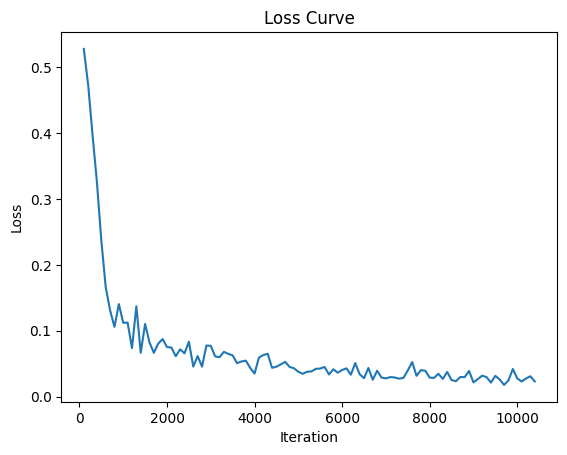

In [3]:
#  plot the loss curve
loss_data = np.loadtxt(record_location+'/loss2.txt', delimiter=',')
plt.plot(loss_data[:,0], loss_data[:,1])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
# if record_data:
#     plt.savefig(record_location+'/distance_loss_curve.png')

Time needed for each image: 0.000682830810546875 seconds
filename    0_rected.jpg
 gaze                359
 pos_x          0.055206
 pos_y         -0.035676
 label_1       -0.849233
 label_2        0.528018
Name: 0, dtype: object
Ground truth: [-0.8492329  0.5280184]
Prediction: [0.20686658 0.1338703 ]
Position: (0.055205964, -0.035675623)
Time needed for each image: 0.000682830810546875 seconds
filename    1_rected.jpg
 gaze                 14
 pos_x          0.067728
 pos_y         -0.031183
 label_1       -0.780191
 label_2        0.625541
Name: 1, dtype: object
Ground truth: [-0.7801913   0.62554103]
Prediction: [-0.04834272  0.26383695]
Position: (0.067727745, -0.031182662)
Time needed for each image: 0.0006124973297119141 seconds
filename    2_rected.jpg
 gaze                 11
 pos_x          0.163971
 pos_y          0.024884
 label_1       -0.999144
 label_2        0.041363
Name: 2, dtype: object
Ground truth: [-0.9991442   0.04136325]
Prediction: [0.00179282 0.07298927]
Posit

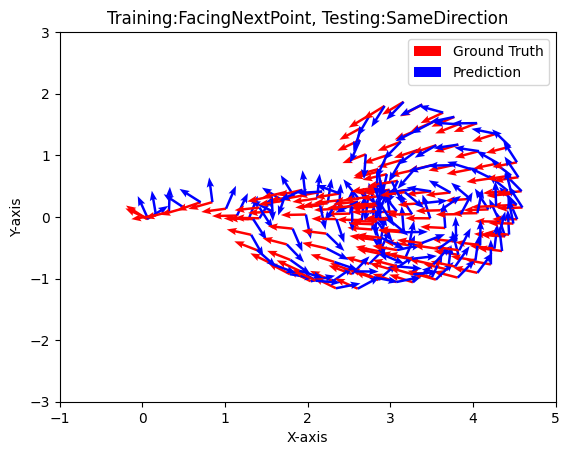

Test loss: 0.8276104259445812


In [7]:
# test the network
# test dataset is stored in a folder called 'data_gym/processed_testing'
# test labels are stored in a csv file called 'processed_testing.csv' with the following format:
# "filename, id, gaze, pos_x, pos_y, label_1, label_2\n"


"""import the model saved previously gaze_net.pth"""
# import the model saved previously gaze_net.pth
PATH = '/home/aoqiao/developer_dq/homingdrone-learning/data_gym/test_results/test_031801/gaze_net.pth'
net = CompactCNN()
net.load_state_dict(torch.load(PATH))



# define the test dataset
test_dataset = GazeDataset(
    # csv_file="./data_gym/processed_label_test.csv",
    csv_file="./data_gym/processed_label_test_.csv",
    root_dir="./data_gym/processed_031901",
    # root_dir="./data_gym/test",
    transform=transform
)

# define the test data loader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# define the test loop
def test(net, dataloader):
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            outputs = net(inputs)
            loss = F.mse_loss(outputs, labels)
            running_loss += loss.item()
            
            
    print(f'Test loss: {running_loss/len(dataloader)}')

# plot the results


def plot_results(net, dataloader, csv_file):
    net.eval()
    

    annotations = pd.read_csv(csv_file)

    fig, ax = plt.subplots()
    ax.set_xlim(-1, 5)
    ax.set_ylim(-3, 3)

    with torch.no_grad():
        with open('./data_gym/results.csv', 'a') as f:
            # f.write('GT0,GT1,GT2,Pred0,Pred1,Pred2,Pos0,Pos1\n')
            f.write('GT0,GT1,Pred0,Pred1,Pos0,Pos1\n')
            for i, data in enumerate(dataloader):
                # record how much time needed for each image
                start_time = time.time()

                inputs, labels = data
                outputs = net(inputs)

                # record how much time needed for each image
                end_time = time.time()
                print(f'Time needed for each image: {end_time-start_time} seconds')

                # Get the corresponding row from the CSV file
                row = annotations.iloc[i]
                print(row)
                pos_x, pos_y = row[' pos_x'], row[' pos_y']
                gaze = row[' gaze']

                

                # Ground truth and prediction vectors
                gt_vector = labels.numpy().squeeze()
                pred_vector = outputs.numpy().squeeze()

                # print gt, pred and pos
                print(f'Ground truth: {gt_vector}')
                print(f'Prediction: {pred_vector}')
                print(f'Position: ({pos_x}, {pos_y})')

                # if pos_x > 0:
                #     gaze_matrix = np.array([[np.cos(np.deg2rad(gaze)), np.sin(np.deg2rad(gaze))], [-np.sin(np.deg2rad(gaze)), np.cos(np.deg2rad(gaze))]])
                # elif pos_x <= 0:
                #     gaze_matrix = np.array([[np.cos(np.deg2rad(gaze)), -np.sin(np.deg2rad(gaze))], [np.sin(np.deg2rad(gaze)), np.cos(np.deg2rad(gaze))]])
                # gt_vector = np.matmul(np.linalg.inv(gaze_matrix), gt_vector)
                # pred_vector = np.matmul(np.linalg.inv(gaze_matrix), pred_vector)

                # convert gt and pred from vector to degree
                gt_degree = np.rad2deg(np.arctan2(gt_vector[1], gt_vector[0]))
                pred_degree = np.rad2deg(np.arctan2(pred_vector[1], pred_vector[0]))

                # add gaze to gt and pred
                gt_degree += gaze
                pred_degree += gaze

                # conver them back to vector and name them gt_show and pred_show
                gt_show = np.array([np.cos(np.deg2rad(gt_degree)), np.sin(np.deg2rad(gt_degree))])
                pred_show = np.array([np.cos(np.deg2rad(pred_degree)), np.sin(np.deg2rad(pred_degree))])

                # for each gt and pred, make a plot, with a vector showing the direction
                ax.quiver(pos_x, pos_y, gt_show[0], gt_show[1], color='r', headaxislength=3.5,  headwidth=3, headlength=4, width=0.005, scale=4, scale_units='inches')
                ax.quiver(pos_x, pos_y, pred_show[0], pred_show[1], color='b', headaxislength=3.5,  headwidth=3, headlength=4, width=0.005, scale=4, scale_units='inches')
                

                # plt.title(f'GT: {gt_vector}, Pred: {pred_vector}, Pos: ({pos_x}, {pos_y})')
                

                # write gt, pred and pos to file
                f.write(f'{gt_vector[0]},{gt_vector[1]},{pred_vector[0]},{pred_vector[1]},{pos_x},{pos_y}\n')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Training:FacingNextPoint, Testing:SameDirection')
    plt.legend(['Ground Truth', 'Prediction'])
    plt.show()

# plot_results(net, test_dataloader, "data_gym/processed_label_test.csv")
plot_results(net, test_dataloader, "data_gym/processed_label_test_031802.csv")
            

# test the network
test(net, test_dataloader)





In [6]:
import pandas as pd

data = pd.read_csv("./data_gym/processed_label_v2.csv")


with open("./data_gym/processed_label_test_samedirection.csv", "a") as f:
    f.write("filename, gaze, pos_x, pos_y, label_1, label_2\n")
    for i in range(4,31):
        filename = f"{i-1}_rected_360.jpg"

        idx = data['filename'] == filename 

        pos_x = data[idx][' pos_x'].values[0]
        pos_y = data[idx][' pos_y'].values[0]

        label_1 = data[idx][' label_1'].values[0]
        label_2 = data[idx][' label_2'].values[0]


        f.write(f"{i}_rected.jpg, 0, {pos_x}, {pos_y}, {label_1}, {label_2}\n")

In [11]:
a = 0
b = 0.1
n = 4
m = 30

theta = np.linspace(0, 2*n*np.pi, m)

r = a + b*theta

x = r*np.cos(theta)
y = r*np.sin(theta)

x = np.append(x, 0.0)
y = np.append(y, 0.0)

path = []
yaw_path = []
for i in range(m+1):
    path.append((float(x[i]), float(y[i])))

    if x[i]<0:
        yaw_path.append(np.arctan(y[i]/x[i]))
    else:
        yaw_path.append(min(np.pi + np.arctan(y[i]/x[i]), -np.pi + np.arctan(y[i]/x[i]), key=abs))

/tmp/ipykernel_647909/3477781477.py:24: RuntimeWarning: invalid value encountered in scalar divide
  yaw_path.append(min(np.pi + np.arctan(y[i]/x[i]), -np.pi + np.arctan(y[i]/x[i]), key=abs))


In [29]:
import pandas as pd

df = pd.read_csv("./data_gym/processed_label_test.csv")


for i in range(1,29):
    if df['filename'][i] == f"{i+1}_rected.jpg":
        df[' pos_x'][i] = x[i]
        df[' pos_y'][i] = y[i]
        gaze = int(yaw_path[i]*180/np.pi)
        df[' gaze'][i] = gaze
        # print(f'({x[i]}, {y[i]}), {np.rad2deg(yaw_path[i])}, {i}')
        print(x[i], y[i], np.rad2deg(yaw_path[i]), i+1)

df.to_csv("./data_gym/processed_label_test_.csv", index=False)

0.056105489553251855 0.06605248864093467 -130.3448275862069 2
-0.02804155210224855 0.17104590088739427 -80.68965517241381 3
-0.2227776173647278 0.13404084498514865 -31.034482758620683 4
-0.3285120265642994 -0.11068858939091582 18.62068965517241 5
-0.1603894220178142 -0.40254709494239665 68.27586206896551 6
0.24356665095424745 -0.4594154397003682 117.93103448275865 7
0.5924691790936587 -0.13041232799838418 167.58620689655172 8
0.5519448555684694 0.4195775710002099 -142.75862068965517 9
0.04222735385842329 0.7788377140929008 -93.10344827586205 10
-0.6291812700593147 0.5959921566376803 -43.44827586206897 11
-0.947722525003032 -0.1030710359705917 6.206896551724145 12
-0.5836207983995833 -0.860776278973832 55.862068965517274 13
0.30140816050638114 -1.0855740830963747 105.51724137931038 14
1.1011655667375813 -0.5094534409649122 155.1724137931034 15
1.1798202500759805 0.5458429724624048 -155.17241379310346 16
0.37096388985400647 1.336091179195538 -105.51724137931033 17
-0.8267961310660772 1.2

/tmp/ipykernel_647909/4201700100.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' pos_x'][i] = x[i]
/tmp/ipykernel_647909/4201700100.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.056105489553251855' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[' pos_x'][i] = x[i]
/tmp/ipykernel_647909/4201700100.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' pos_y'][i] = y[i]
/tmp/ipykernel_647909/4201700100.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

In [2]:
import numpy as np

a = 0
b = 0.1
n = 4
m = 30

theta = np.linspace(0, 2*n*np.pi, m)

r = a + b*theta

x = r*np.cos(theta)
y = r*np.sin(theta)

x = np.append(x, 0.0)
y = np.append(y, 0.0)

path = []
yaw_path = []
for i in range(m+1):
    path.append((float(x[i]), float(y[i])))

    if i == 0:
        yaw_path.append(0.0)
    else:
        if x[i]>x[i-1]:
            yaw_path.append(np.arctan((y[i]-y[i-1])/(x[i]-x[i-1])))
        else:
            yaw_path.append(min(np.pi + np.arctan((y[i]-y[i-1])/(x[i]-x[i-1])), -np.pi + np.arctan((y[i]-y[i-1])/(x[i]-x[i-1])), key=abs))

In [4]:
for i in range(m):
    print(f'({x[i]}, {y[i]}), {np.rad2deg(yaw_path[i])}, {i}')

(0.0, 0.0), 0.0, 0
(0.056105489553251855, 0.06605248864093467), 49.655172413793096, 1
(-0.02804155210224855, 0.17104590088739427), 128.71045401710816, 2
(-0.2227776173647278, 0.13404084498514865), -169.24055527311393, 3
(-0.3285120265642994, -0.11068858939091582), -113.366572636434, 4
(-0.1603894220178142, -0.40254709494239665), -60.05627308452989, 5
(0.24356665095424745, -0.4594154397003682), -8.013355076812752, 6
(0.5924691790936587, -0.13041232799838418), 43.31860778327644, 7
(0.5519448555684694, 0.4195775710002099), 94.21404921513677, 8
(0.04222735385842329, 0.7788377140929008), 144.82297399961936, 9
(-0.6291812700593147, 0.5959921566376803), -164.76600236701464, 10
(-0.947722525003032, -0.1030710359705917), -114.49727198671133, 11
(-0.5836207983995833, -0.860776278973832), -64.33421897997229, 12
(0.30140816050638114, -1.0855740830963747), -14.251768666738714, 13
(1.1011655667375813, -0.5094534409649122), 35.7678181730488, 14
(1.1798202500759805, 0.5458429724624048), 85.73744016899

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plot_file = './data_gym/test_results/distance_output/validation_results.csv'

def plot_vector(gt_vector, pred_vector, pos):

    pos_x = pos[:, 0]
    pos_y = pos[:, 1]

    fig, ax = plt.subplots()
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

    for i in range(len(gt_vector)):
        # plot the ground truth and prediction vectors
        angle_gt = np.arctan2(gt_vector[i][1], gt_vector[i][0])
        angle_pred = np.arctan2(pred_vector[i][1], pred_vector[i][0])

        rot_mat_gt = np.array([[np.cos(angle_gt), np.sin(angle_gt)], [-np.sin(angle_gt), np.cos(angle_gt)]])
        rot_mat_pred = np.array([[np.cos(angle_pred), np.sin(angle_pred)], [-np.sin(angle_pred), np.cos(angle_pred)]])

        gt_vector[i] = np.matmul(rot_mat_gt, np.array([0, 1]))
        pred_vector[i] = np.matmul(rot_mat_pred, np.array([0, 1]))

        
        ax.quiver(pos_x[i], pos_y[i], gt_vector[i][0], gt_vector[i][1], color='cyan')
        ax.quiver(pos_x[i], pos_y[i], pred_vector[i][0], pred_vector[i][1], angles='xy', scale_units='xy', color='orange')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Predicted vs Ground Truth Vectors')
    plt.legend(['Ground Truth', 'Prediction'], loc='upper right')
    plt.show()

def reverse_normalize(value, min_distance, max_distance):
    return ((value + 1) * (max_distance - min_distance) / 2) + min_distance

def plot_distance(gt_distance, pred_distance):
    fig, ax = plt.subplots()
    
    # for i in range(len(gt_distance)):
    #     # draw a histogram
    #     # x is i
    #     # for each x, there are two bars, one for gt and one for pred
    #     # the height of each bar is the distance

    x = np.arange(len(gt_distance))
    width = 0.35

    # min_distance = np.min(gt_distance)
    # max_distance = np.max(gt_distance)

    min_distance = 1
    max_distance = 7.07

    gt_distance = reverse_normalize(gt_distance, min_distance, max_distance)
    pred_distance = reverse_normalize(pred_distance, min_distance, max_distance)

    # # for both gt and pred, keep 0:6, for 7:the end, reverse the order
    # gt_distance = np.concatenate((gt_distance[:6], gt_distance[6:][::-1]))
    # pred_distance = np.concatenate((pred_distance[:6], pred_distance[6:][::-1]))

    # only plot the outest loop, so 0:11, -12:-1 and 11,22,33,44,55,66,77,88,99, 21, 32, 43, 54, 65, 76, 87, 98, 109
    # x = list(x[0:11]) + list(x[110:121]) + [x[i] for i in range(11, 110, 11)] + [x[i] for i in range(21, 110, 11)]
    x = np.arange(8)
    # gt_distance = list(gt_distance[0:11]) + list(gt_distance[109:]) + [gt_distance[i] for i in range(11, 56, 11)] +\
    #                 [gt_distance[i] for i in range(65, 110, 11)] +[gt_distance[i] for i in range(21, 65, 11)] + \
    #                 [gt_distance[i] for i in range(75, 110, 11)]
    
    # pred_distance = list(pred_distance[0:11]) + list(pred_distance[109:]) + [pred_distance[i] for i in range(11, 56, 11)] +\
    #                 [pred_distance[i] for i in range(65, 110, 11)] +[pred_distance[i] for i in range(21, 65, 11)] + \
    #                 [pred_distance[i] for i in range(75, 110, 11)]

    gt_distance = list(gt_distance[48:51]) + list(gt_distance[59:61]) + list(gt_distance[69:72])
    pred_distance = list(pred_distance[48:51]) + list(pred_distance[59:61]) + list(pred_distance[69:72])

    ax.bar(x - width/2, gt_distance, width,color='cyan')
    ax.bar(x + width/2, pred_distance, width,color='orange')
    ax.set_xticks(x)
    # ax.set_xticklabels(x)
    ax.legend()
        
    plt.xlabel('Ground Truth Distance')
    plt.ylabel('Predicted Distance')
    plt.title('Predicted vs Ground Truth Distance (outeset loop))')
    plt.legend(['Ground Truth', 'Prediction'], loc='upper right')
    plt.show()




# load data from csv file
data = pd.read_csv(plot_file)
data = data.to_numpy()
gt_vectors = data[:, :2]
pred_vectors = data[:, 3:5]
pos = data[:, 6:]

# plot the vectors
plot_vector(gt_vectors, pred_vectors, pos)

# plot the distance
gt_distance = data[:, 2]
pred_distance = data[:, 5]
plot_distance(gt_distance, pred_distance)

    

FileNotFoundError: [Errno 2] No such file or directory: './data_gym/test_results/distance_output/validation_results.csv'

In [4]:
fig, ax = plt.subplots()
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)


plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Predicted vs Ground Truth Vectors')
    plt.legend(['Ground Truth', 'Prediction'])
    if record_data:
        plt.savefig(record_location+'output.png')
    plt.show()

angle_gt = np.arctan2(gt_vector[1], gt_vector[0])
            angle_pred = np.arctan2(pred_vector[1], pred_vector[0])

            rot_mat_gt = np.array([[np.cos(angle_gt), np.sin(angle_gt)], [-np.sin(angle_gt), np.cos(angle_gt)]])
            rot_mat_pred = np.array([[np.cos(angle_pred), np.sin(angle_pred)], [-np.sin(angle_pred), np.cos(angle_pred)]])

            gt_vector = np.matmul(rot_mat_gt, np.array([0, 1]))
            pred_vector = np.matmul(rot_mat_pred, np.array([0, 1]))

            # transformation_matrix = np.array([[0, 1], [-1, 0]])
            # # transform both gt and pred vectors
            # gt_vector = np.matmul(transformation_matrix, gt_vector)
            # pred_vector = np.matmul(transformation_matrix, pred_vector)

           

            # Plotting
            ax.quiver(pos_x, pos_y, gt_vector[0], -gt_vector[1], color='cyan')
            ax.quiver(pos_x, pos_y, pred_vector[0], -pred_vector[1], angles='xy', scale_units='xy', color='orange')


            """For relocalization only from here onwards"""
            # Plotting
            # from i=7 on, plot the ground truth using dots and connect them with lines
            # also plot the predicted points and connect them with lines
            # if i>=1 and i<7:
            #     prev_pos_x, prev_pos_y = annotations.iloc[i-1][' pos_x'], annotations.iloc[i-1][' pos_y']
            #     # ax.scatter(pos_x, pos_y, color='g')
            #     # plot the predicted
            #     # ax.scatter(prev_pred_x, prev_pred_y, color='r')
               
            #     ax.plot([prev_pos_x, pos_x], [prev_pos_y, pos_y], color='g')
            #     ax.plot([prev_pred_x, pred_vector[0]], [prev_pred_y, pred_vector[1]], color='r')

            """only plot the dataset from point 7 on"""
            # if i >= 7:
            #     # plot the ground truth
            #     prev_pos_x, prev_pos_y = annotations.iloc[i-1][' pos_x'], annotations.iloc[i-1][' pos_y']
            #     # ax.scatter(pos_x, pos_y, color='g')
            #     # plot the predicted
            #     # ax.scatter(prev_pred_x, prev_pred_y, color='r')
            #     if i >= 8:
            #         ax.plot([prev_pos_x, pos_x], [prev_pos_y, pos_y], color='g')
            #         ax.plot([prev_pred_x, pred_vector[0]], [prev_pred_y, pred_vector[1]], color='r')

            # prev_pred_x, prev_pred_y = pred_vector[0], pred_vector[1]

0

In [11]:
"""import the model saved previously gaze_net.pth"""
# import the model saved previously gaze_net.pth

import torch
import torch.nn as nn

# class CompactCNN(nn.Module):
#     def __init__(self):
#         super(CompactCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, stride=4)
#         self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5, stride=4)
#         self.fc = nn.Linear(in_features=4*12*112, out_features=2)

#     def forward(self, x):
#         # Checking the input dimensions
#         assert x.size()[2:] == (201, 1800), "Input dimensions must be 1x201x1800"
#         x = torch.tanh(self.conv1(x))
#         x = torch.tanh(self.conv2(x))
#         x = x.view(-1, 4*12*112)
#         x = self.fc(x)
#         return x

# PATH = './.gaze_net.pth'
# net = CompactCNN()
# net.load_state_dict(torch.load(PATH))

# define the test dataset
test_dataset = GazeDataset(
    csv_file="data_gym/processed_label.csv",
    root_dir="data_gym/train",
    transform=transform
)

# choose only the first 360 images

# define the test data loader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# plot the results
    
def plot_results(net, dataloader, csv_file):
    net.eval()

    annotations = pd.read_csv(csv_file)

    with torch.no_grad():
        with open('./data_gym/test_results/distance_output/validation_results.csv', 'a') as f:
            f.write('GT0,GT1,GT2,Pred0,Pred1,Pred2,Pos0,Pos1\n')
            for i, data in enumerate(dataloader):
                if (i+0)%360 == 0:

                    inputs, labels = data
                    outputs = net(inputs)


                    # Get the corresponding row from the CSV file
                    row = annotations.iloc[i]
                    pos_x, pos_y = row[' pos_x'], row[' pos_y']

                    # Ground truth and prediction vectors
                    gt_vector = labels.numpy().squeeze()
                    pred_vector = outputs.numpy().squeeze()

                    # print gt, pred and pos
                    print(f'Ground truth: {gt_vector}')
                    print(f'Prediction: {pred_vector}')
                    print(f'Position: ({pos_x}, {pos_y})')

                    # write gt, pred and pos to file
                    f.write(f'{gt_vector[0]},{gt_vector[1]},{gt_vector[2]},{pred_vector[0]},{pred_vector[1]},{pred_vector[2]},{pos_x},{pos_y}\n')


                

                # Plotting
                # if in quadrant 2,4
                # if (pos_x < 0 and pos_y > 0) or (pos_x > 0 and pos_y < 0):
                #     ax.quiver(pos_x, pos_y, -gt_vector[0], -gt_vector[1], color='cyan')
                #     ax.quiver(pos_x, pos_y, -pred_vector[0], -pred_vector[1], angles='xy', scale_units='xy', color='orange')
                # elif (pos_x < 0 and pos_y < 0) or (pos_x > 0 and pos_y > 0):
                #     ax.quiver(pos_x, pos_y, gt_vector[0], gt_vector[1], color='cyan')
                #     ax.quiver(pos_x, pos_y, pred_vector[0], pred_vector[1], angles='xy', scale_units='xy', color='orange')
                # else:
                #     ax.quiver(pos_x, pos_y, gt_vector[1],gt_vector[0], color='cyan')
                #     ax.quiver(pos_x, pos_y, pred_vector[1],pred_vector[0], angles='xy', scale_units='xy', color='orange')
            





plot_results(net, test_dataloader, "data_gym/processed_label_new.csv")



Ground truth: [ 0.695 -0.719  1.   ]
Prediction: [ 0.28989512 -0.649508    0.6409402 ]
Position: (5, -5)
Ground truth: [ 0.611  -0.7915  0.7803]
Prediction: [ 0.73058003 -0.46975318  0.17150217]
Position: (5, -4)
Ground truth: [ 0.4995 -0.866   0.592 ]
Prediction: [ 0.500364   -0.76921105  0.37357324]
Position: (5, -3)
Ground truth: [ 0.3552 -0.935   0.4453]
Prediction: [ 0.79276586 -0.9912205   0.27621165]
Position: (5, -2)
Ground truth: [ 0.179  -0.984   0.3496]
Prediction: [ 4.9802933e-02 -8.9215422e-01 -7.4178912e-04]
Position: (5, -1)
Ground truth: [-0.01746 -1.       0.3184 ]
Prediction: [-0.15654466 -1.079621    0.02089932]
Position: (5, 0)
Ground truth: [-0.2133 -0.977   0.3496]
Prediction: [-0.02255809 -1.2219688  -0.02095153]
Position: (5, 1)
Ground truth: [-0.3875 -0.922   0.4453]
Prediction: [-0.5353889  -0.9244763   0.24100244]
Position: (5, 2)
Ground truth: [-0.5293 -0.848   0.592 ]
Prediction: [-0.61419725 -0.665838    0.4807228 ]
Position: (5, 3)
Ground truth: [-0.638  

In [17]:
# give some insight of the dataloader
for i, data in enumerate(test_dataloader):
    if (i+1)%360 == 0:
        inputs, labels = data
        print(i, labels)
    

359 tensor([[ 0.7071, -0.7071]])
719 tensor([[ 0.6247, -0.7809]])
1079 tensor([[ 0.5145, -0.8575]])
1439 tensor([[ 0.3714, -0.9285]])
1799 tensor([[ 0.1961, -0.9806]])
2159 tensor([[-1.8370e-16, -1.0000e+00]])


KeyboardInterrupt: 

Test the network that from the same position but different gaze angle


Time needed for each image: 0.0015079975128173828 seconds
Ground truth: [ 0.7193398 -0.6946584]
Prediction: [ 0.6202363  -0.29785025]
Position: (5, -5)
Time needed for each image: 0.0034890174865722656 seconds
Ground truth: [ 0.7313537 -0.6819984]
Prediction: [ 0.63279873 -0.26653385]
Position: (5, -5)
Time needed for each image: 0.003068208694458008 seconds
Ground truth: [ 0.7431448 -0.6691306]
Prediction: [ 0.63204956 -0.281432  ]
Position: (5, -5)
Time needed for each image: 0.0021491050720214844 seconds
Ground truth: [ 0.7547096 -0.656059 ]
Prediction: [ 0.6006809  -0.27828538]
Position: (5, -5)
Time needed for each image: 0.0016210079193115234 seconds
Ground truth: [ 0.76604444 -0.64278764]
Prediction: [ 0.58737814 -0.29982644]
Position: (5, -5)
Time needed for each image: 0.0007853507995605469 seconds
Ground truth: [ 0.777146  -0.6293204]
Prediction: [ 0.66024804 -0.27937478]
Position: (5, -5)
Time needed for each image: 0.0007562637329101562 seconds
Ground truth: [ 0.7880108 -0.

/var/folders/xf/6mc7pcrj7996jhpdx12lmq640000gn/T/ipykernel_24480/4123981253.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Time needed for each image: 0.0007560253143310547 seconds
Ground truth: [ 0.97437006 -0.22495106]
Prediction: [ 0.65742576 -0.08639926]
Position: (5, -5)
Time needed for each image: 0.0005981922149658203 seconds
Ground truth: [ 0.9781476  -0.20791169]
Prediction: [ 0.67968994 -0.04583761]
Position: (5, -5)
Time needed for each image: 0.0006189346313476562 seconds
Ground truth: [ 0.98162717 -0.190809  ]
Prediction: [ 0.7123864  -0.04653271]
Position: (5, -5)
Time needed for each image: 0.0006470680236816406 seconds
Ground truth: [ 0.9848077  -0.17364818]
Prediction: [ 0.7286959  -0.05898729]
Position: (5, -5)
Time needed for each image: 0.0006229877471923828 seconds
Ground truth: [ 0.98768836 -0.15643446]
Prediction: [ 0.7180493  -0.02325094]
Position: (5, -5)
Time needed for each image: 0.0006618499755859375 seconds
Ground truth: [ 0.99026805 -0.1391731 ]
Prediction: [0.7200105 0.0129365]
Position: (5, -5)
Time needed for each image: 0.00063323974609375 seconds
Ground truth: [ 0.992546

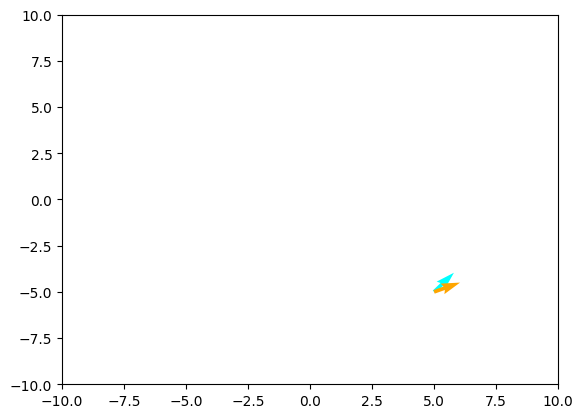

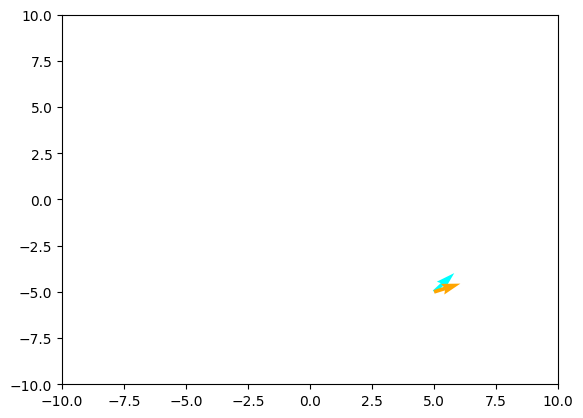

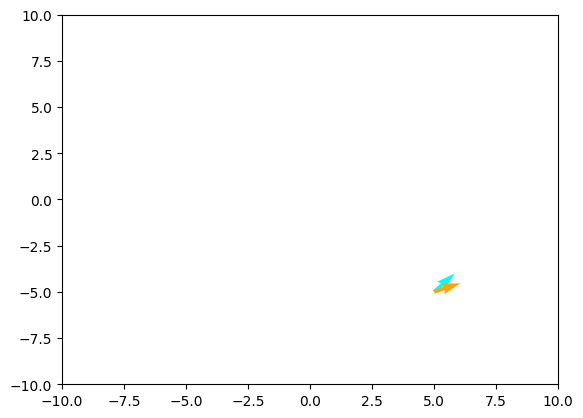

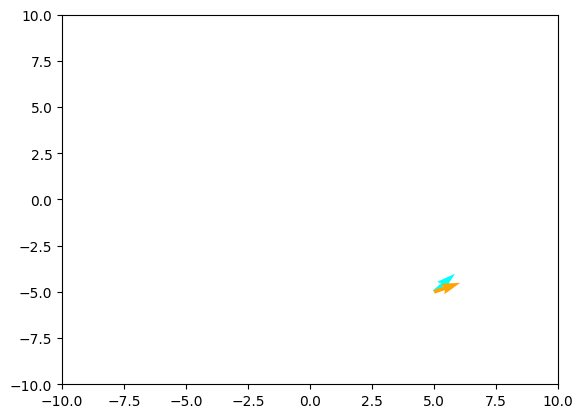

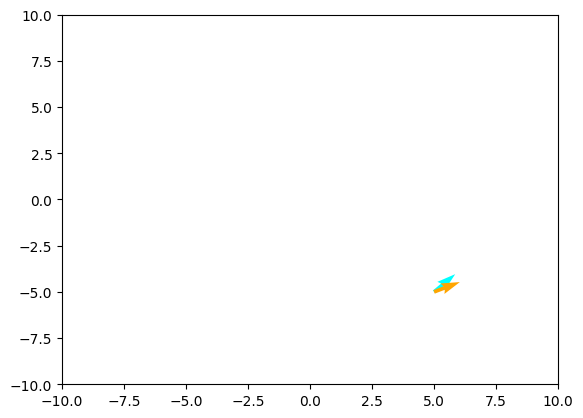

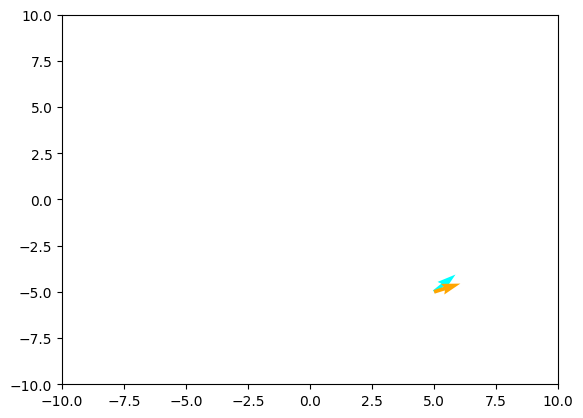

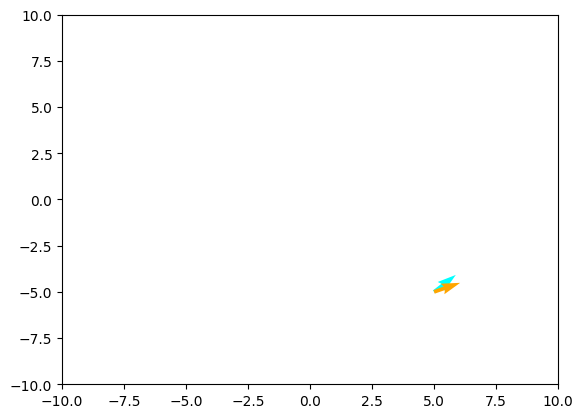

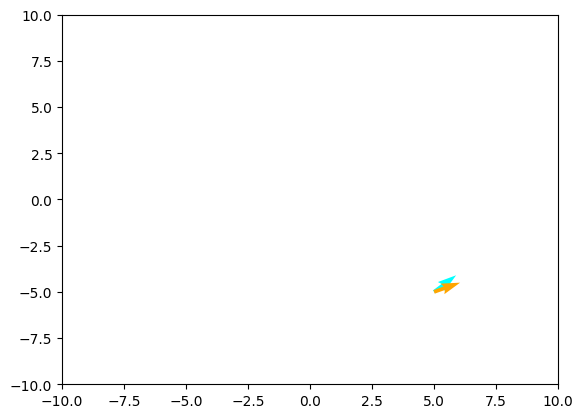

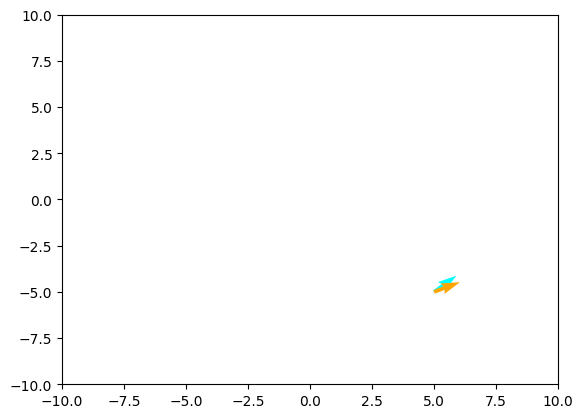

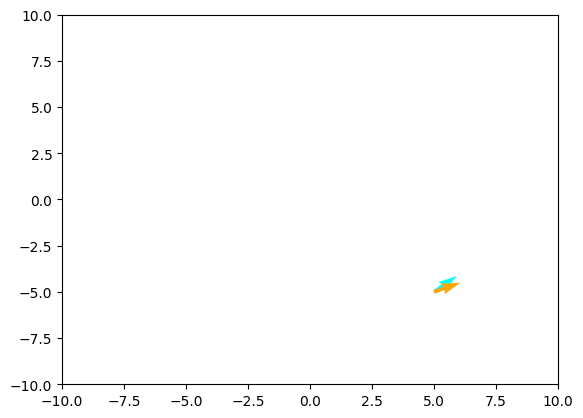

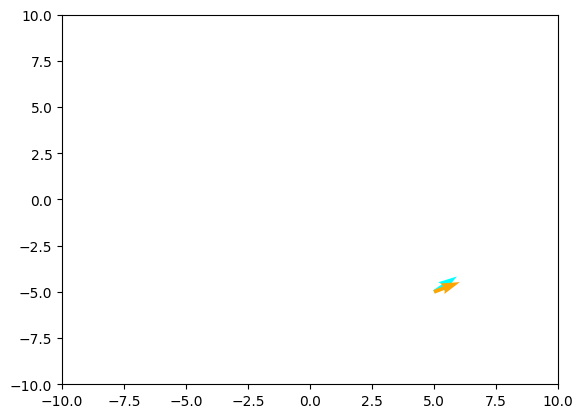

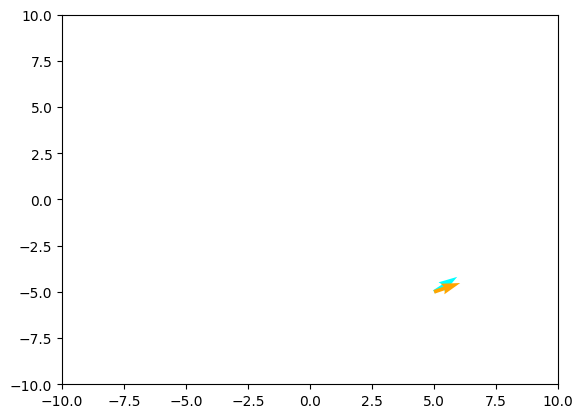

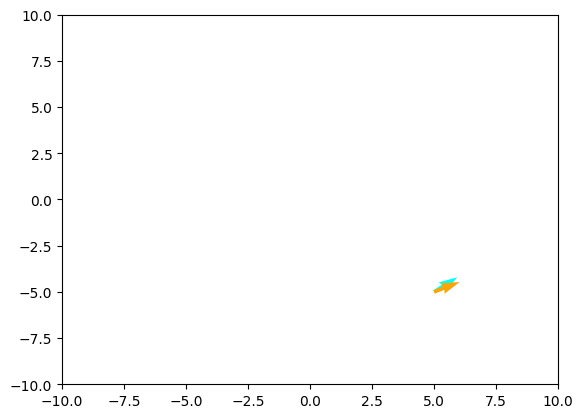

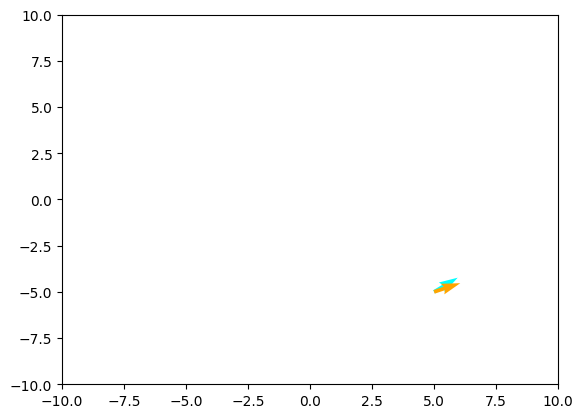

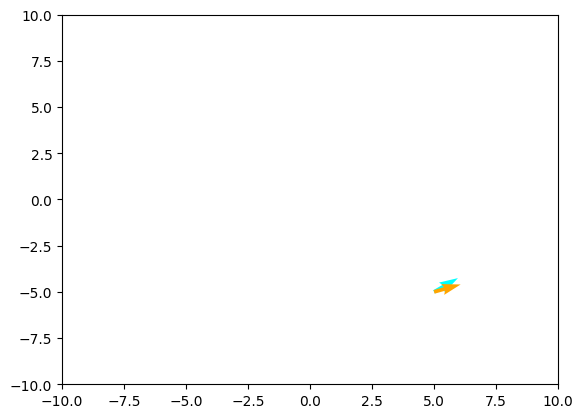

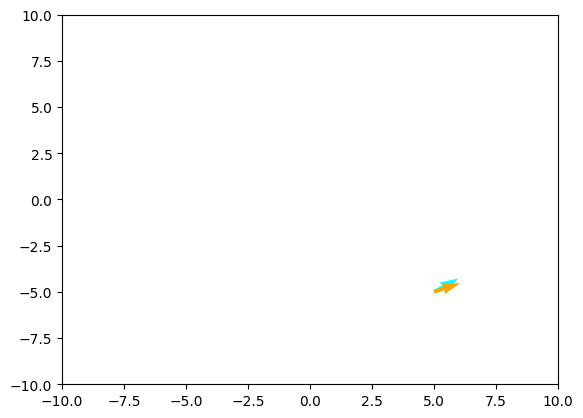

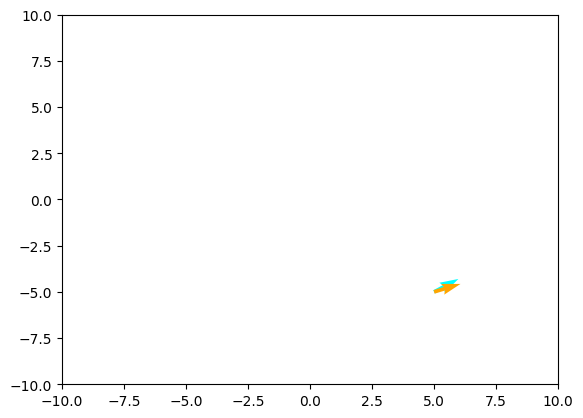

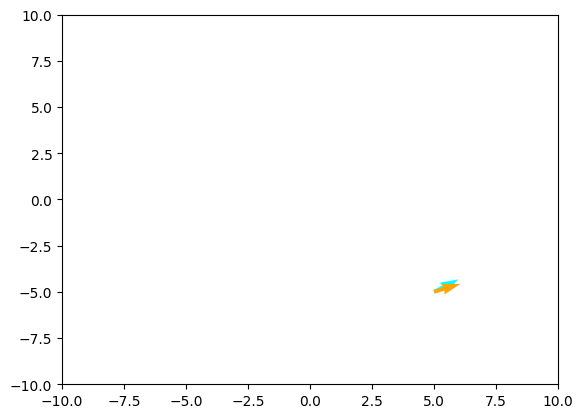

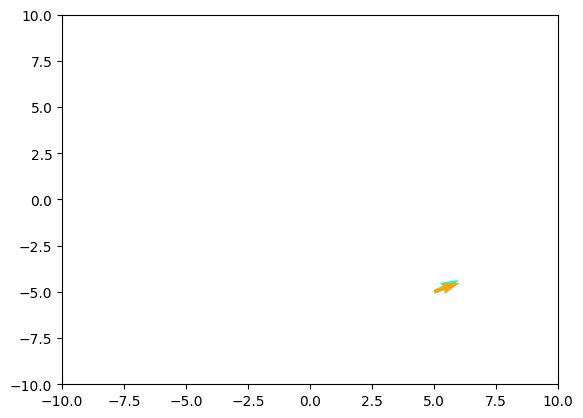

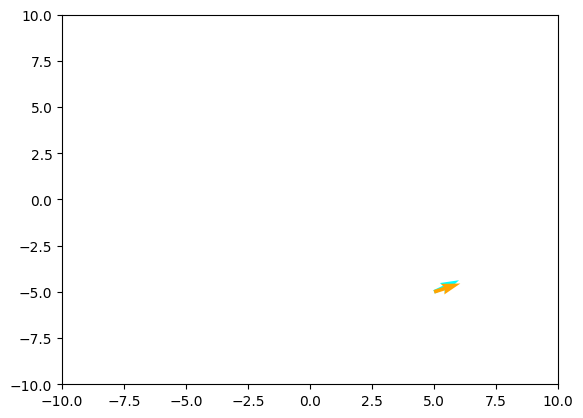

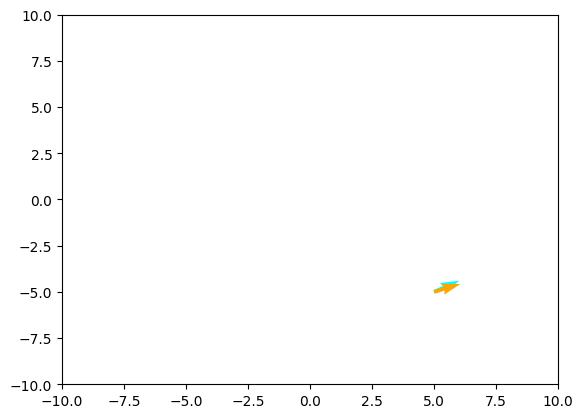

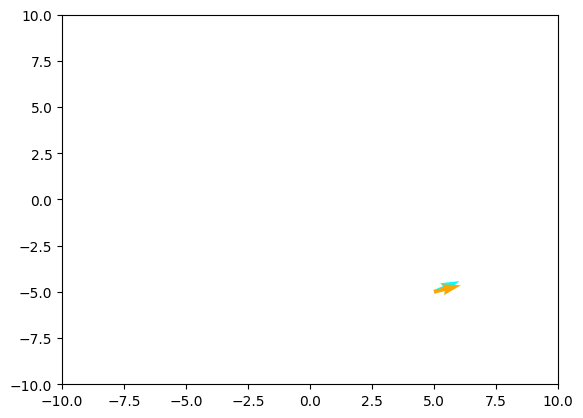

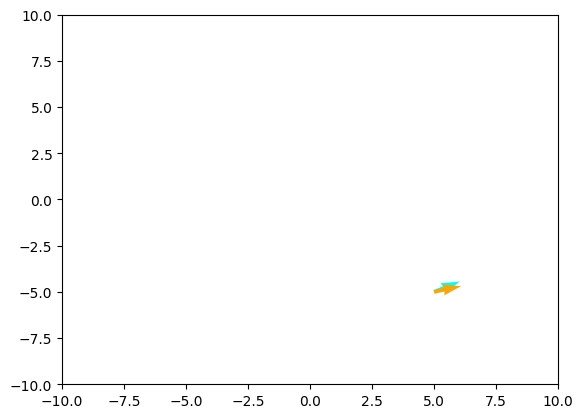

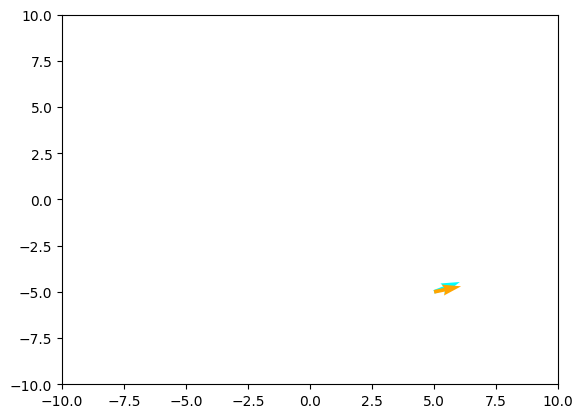

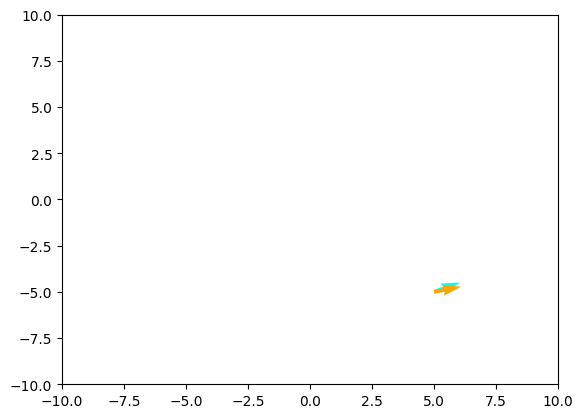

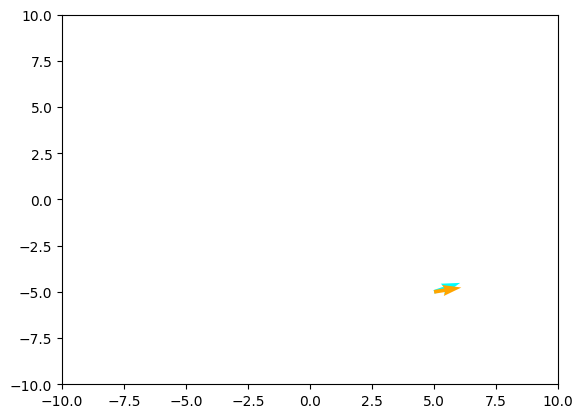

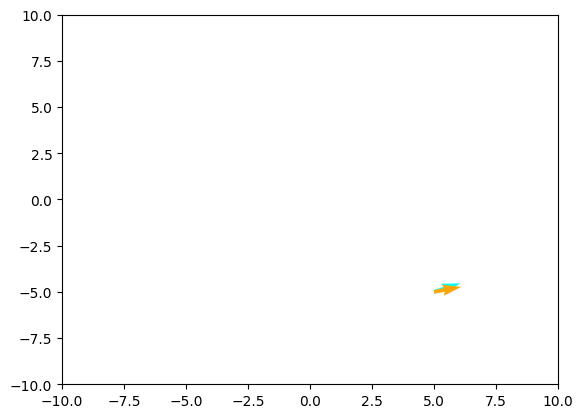

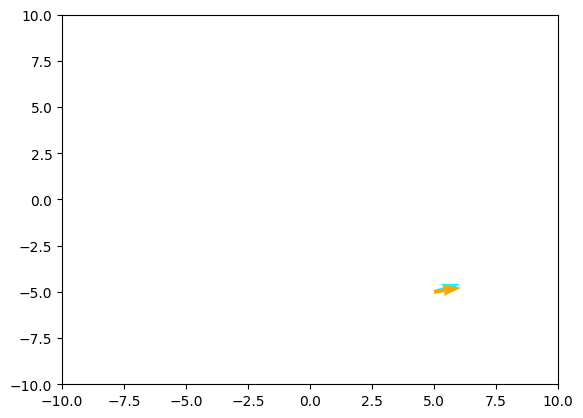

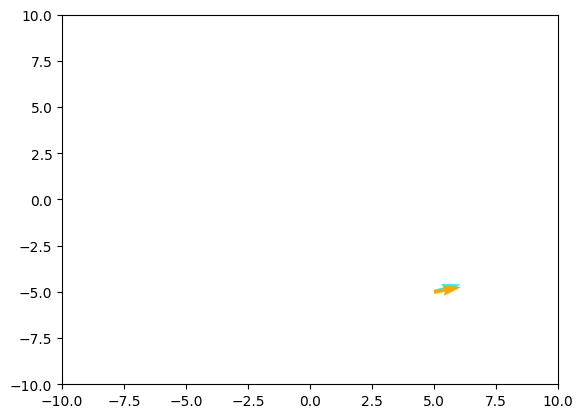

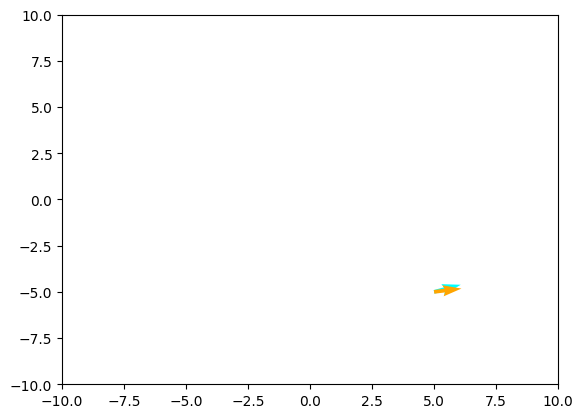

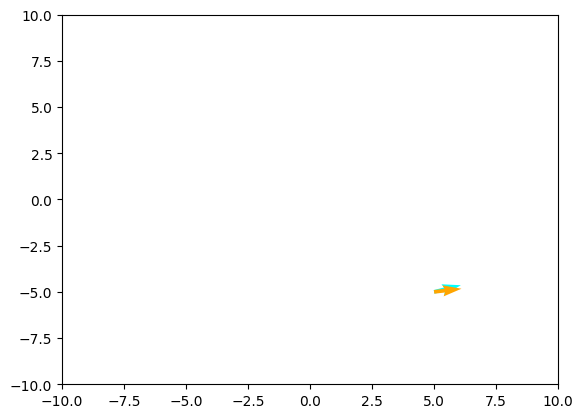

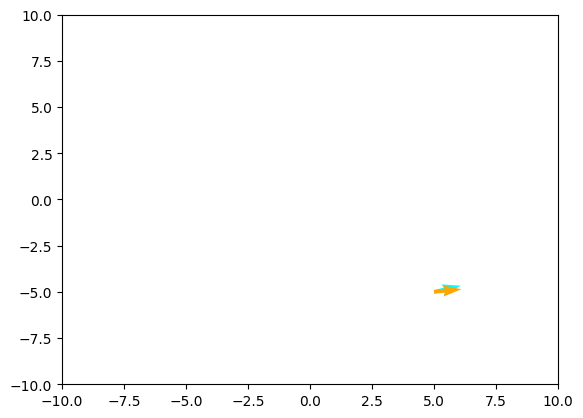

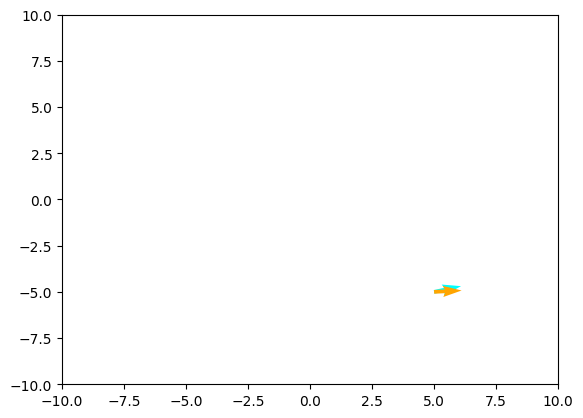

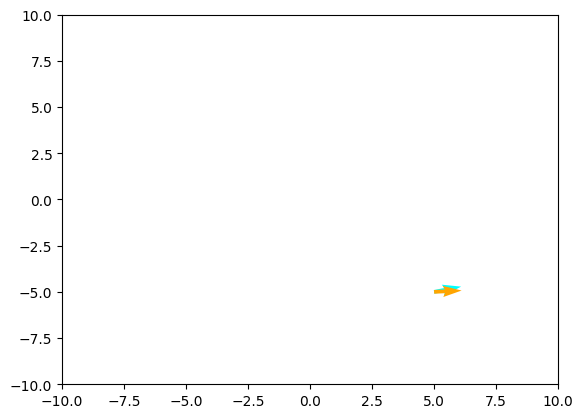

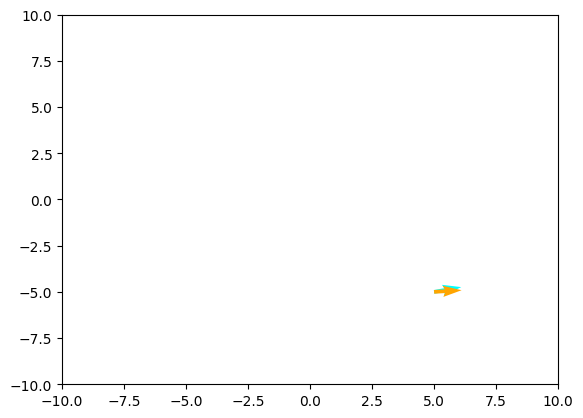

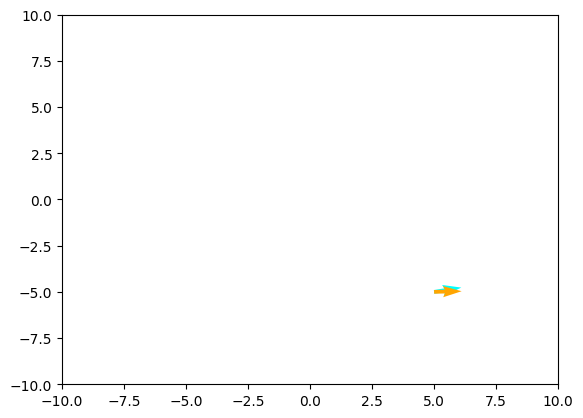

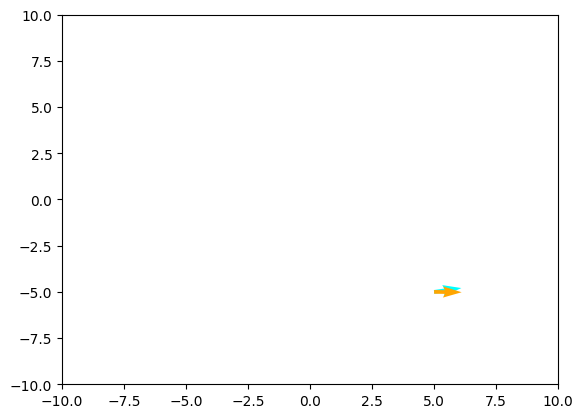

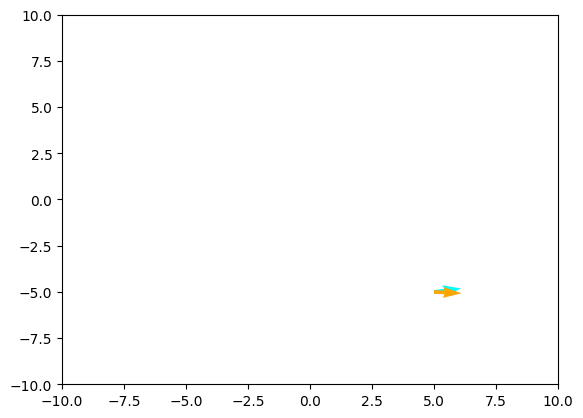

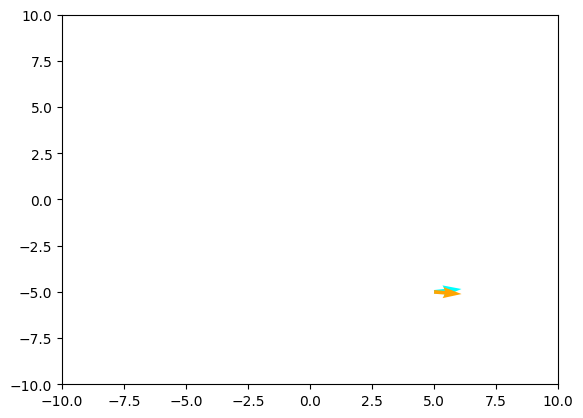

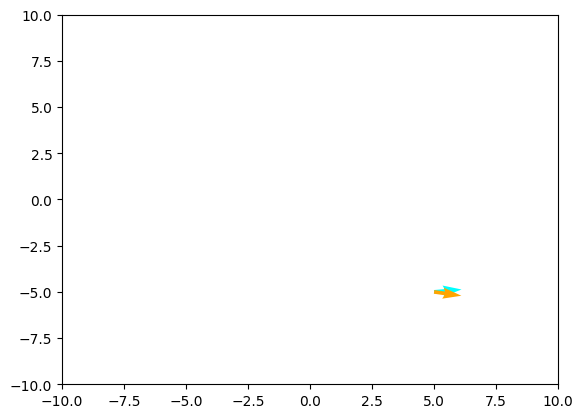

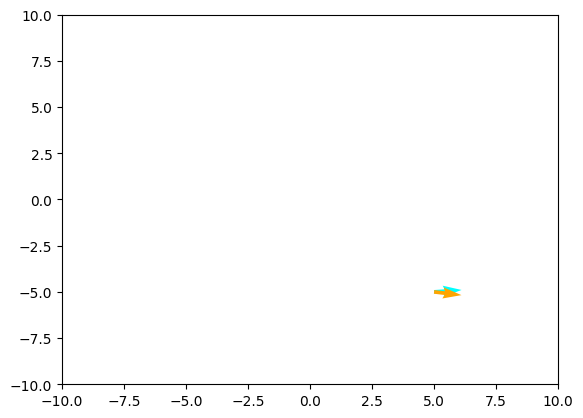

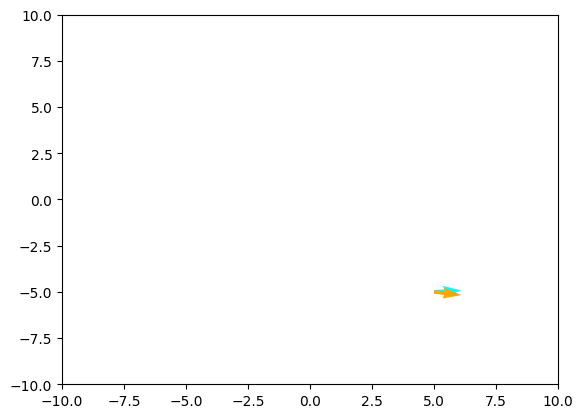

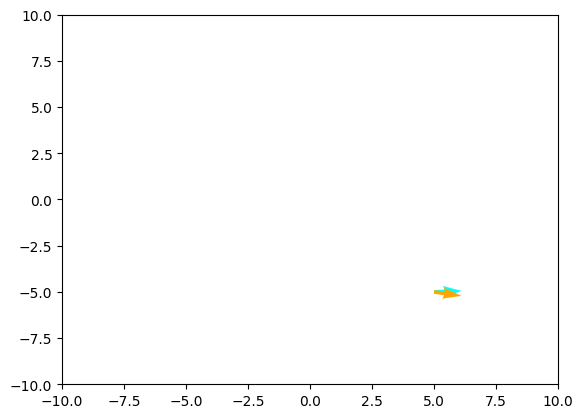

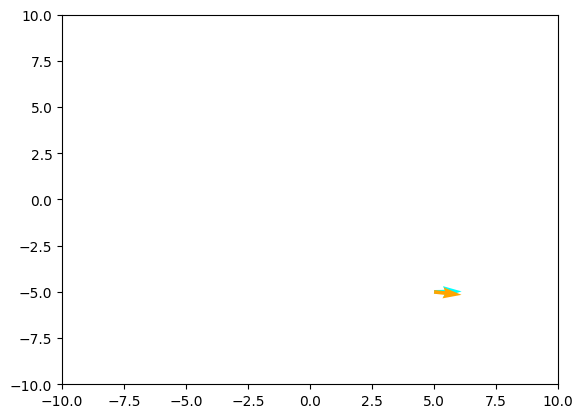

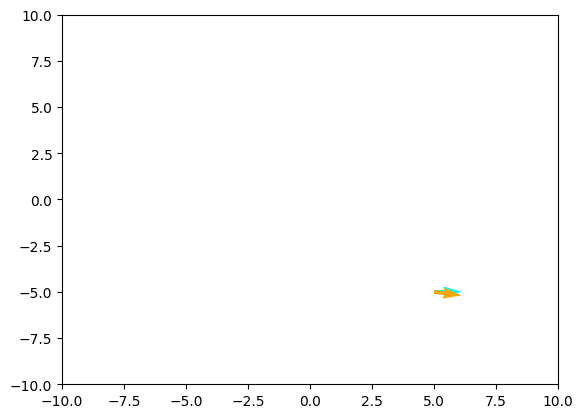

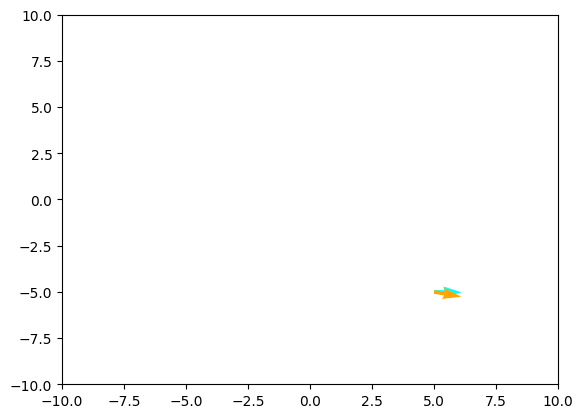

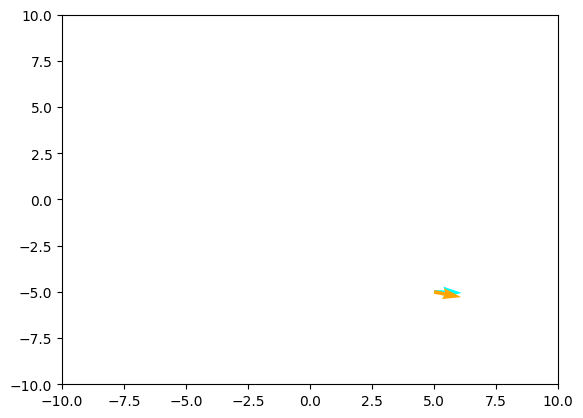

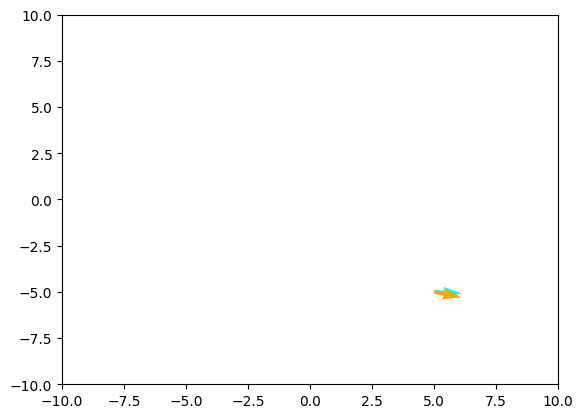

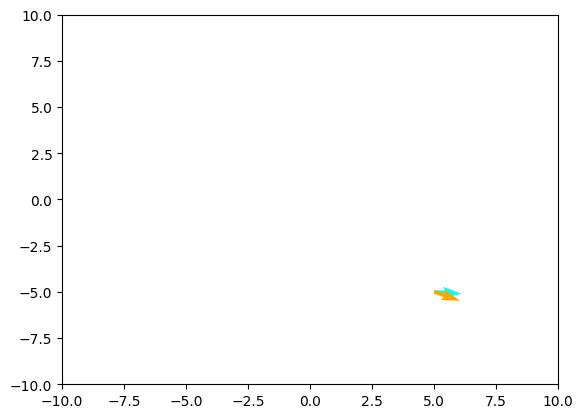

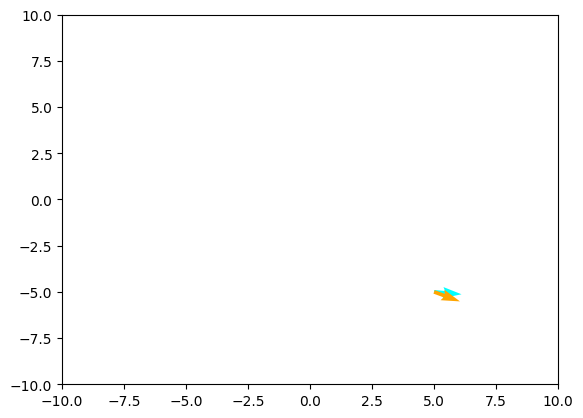

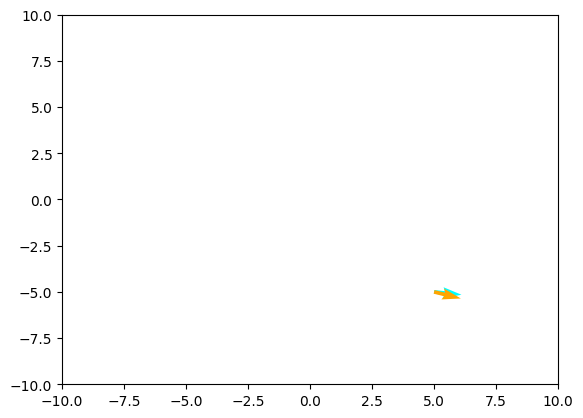

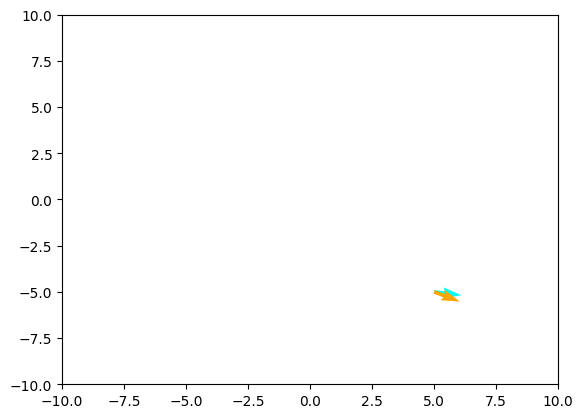

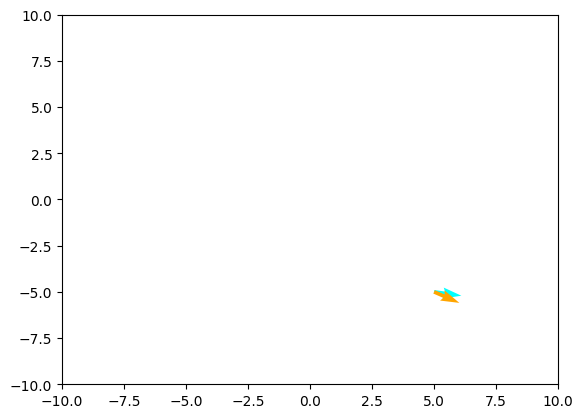

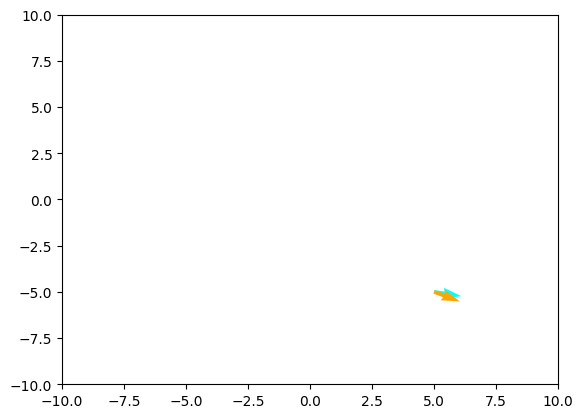

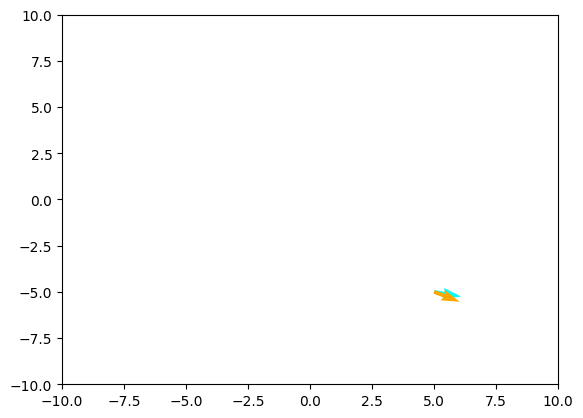

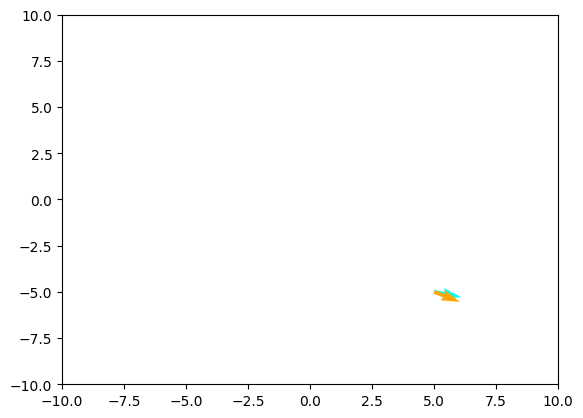

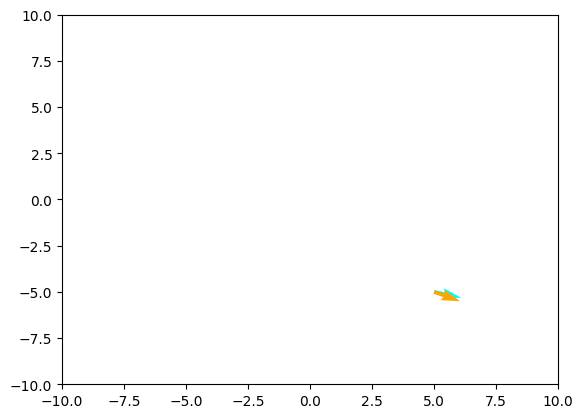

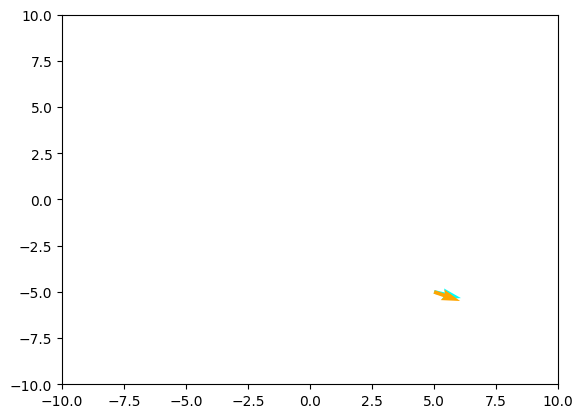

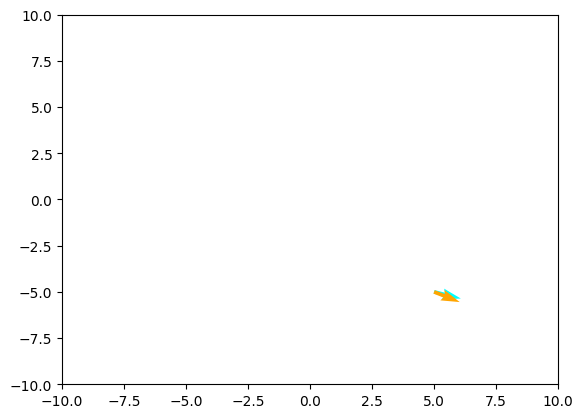

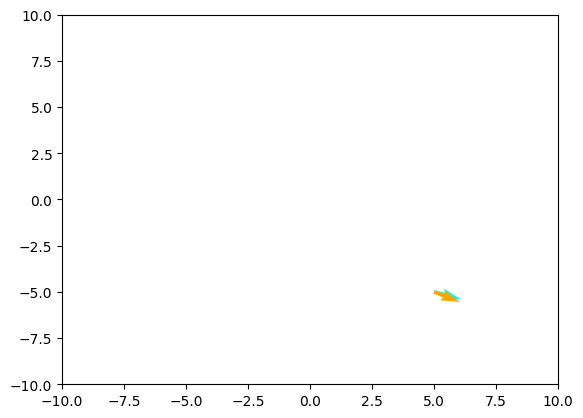

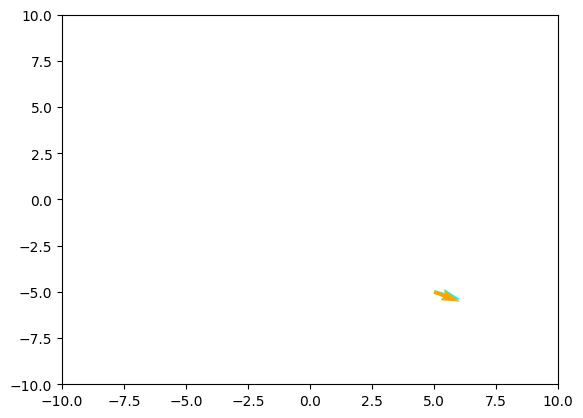

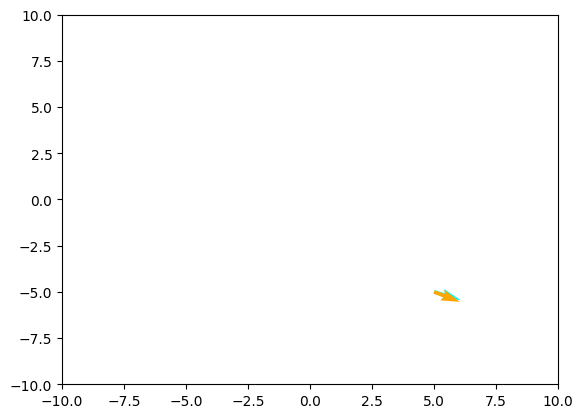

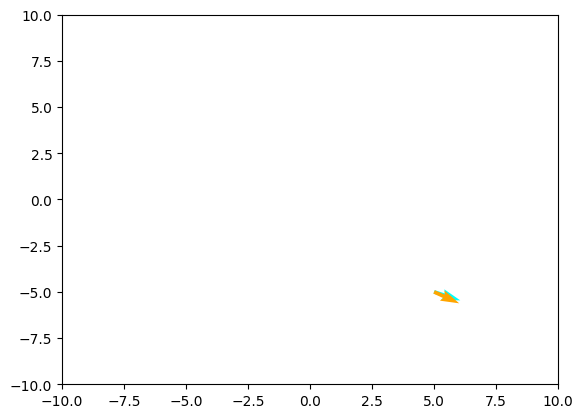

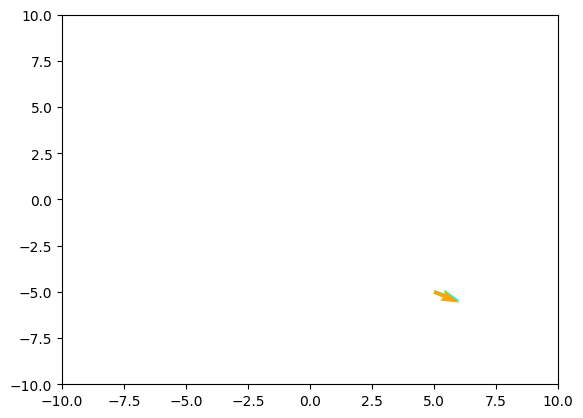

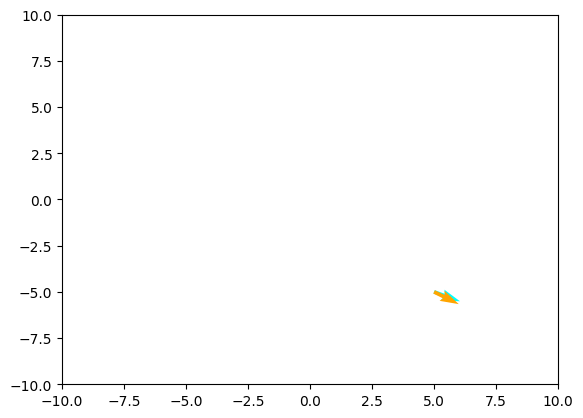

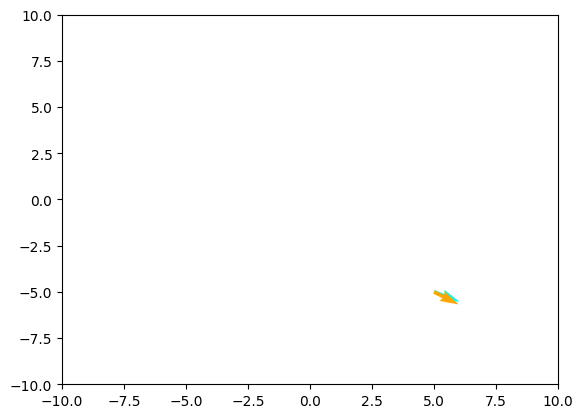

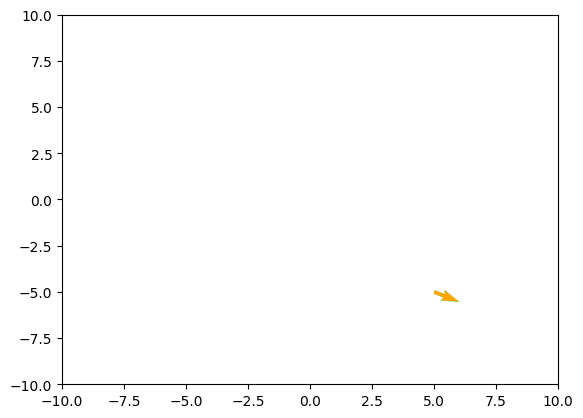

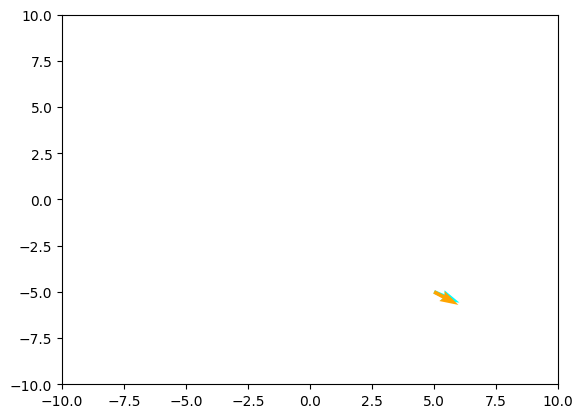

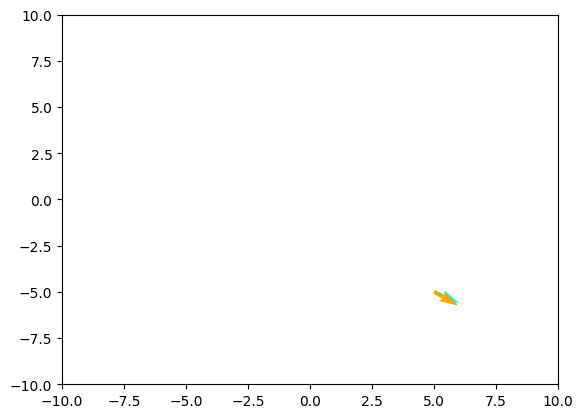

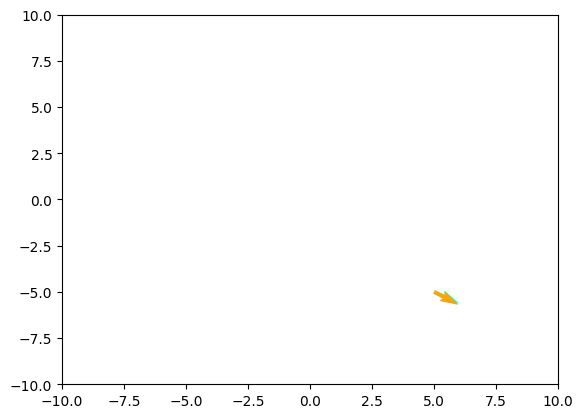

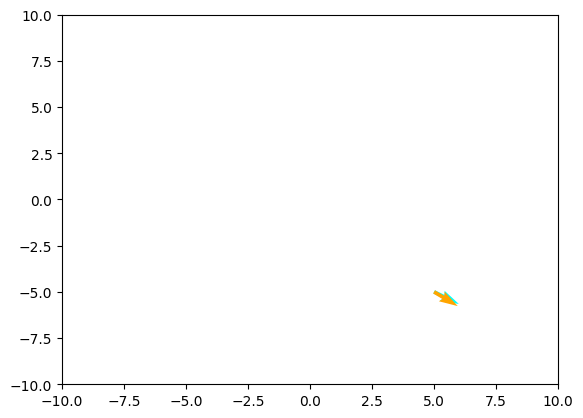

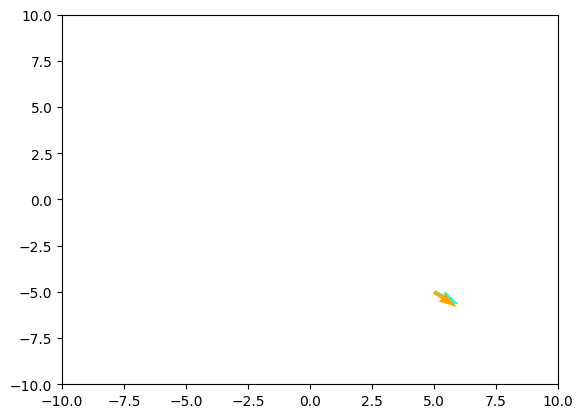

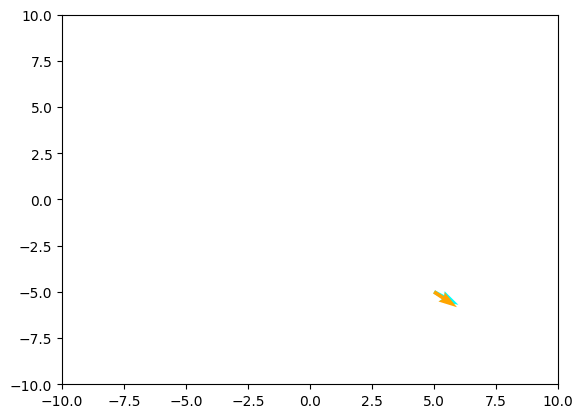

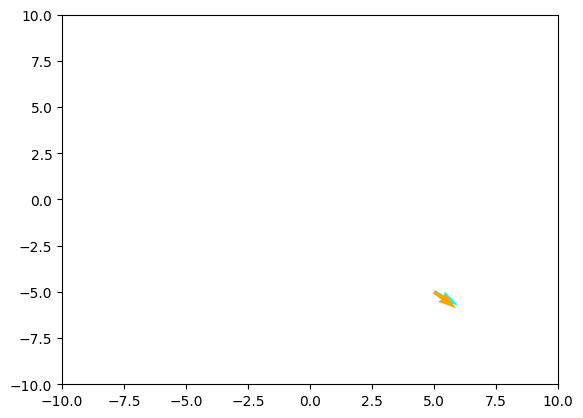

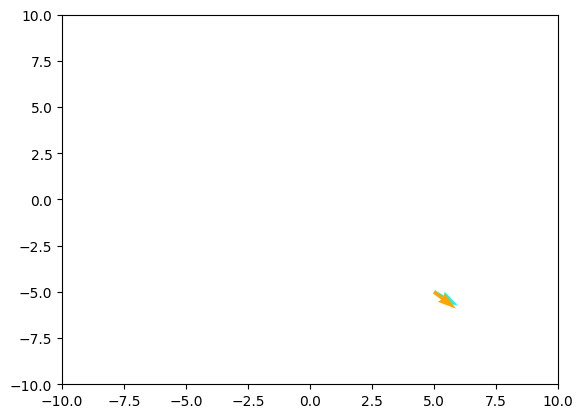

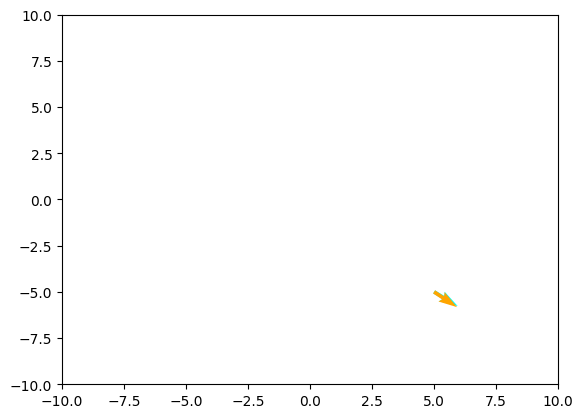

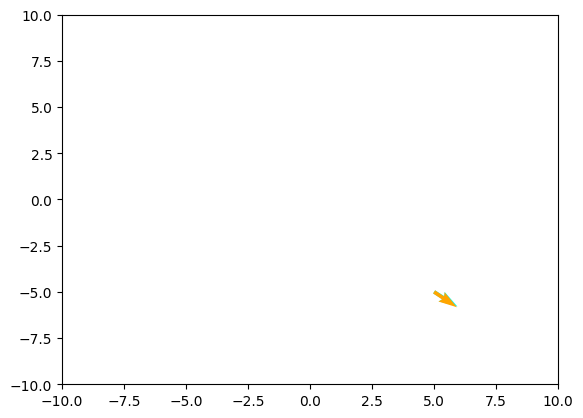

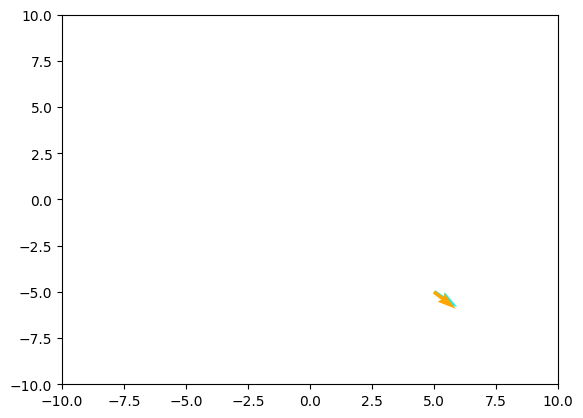

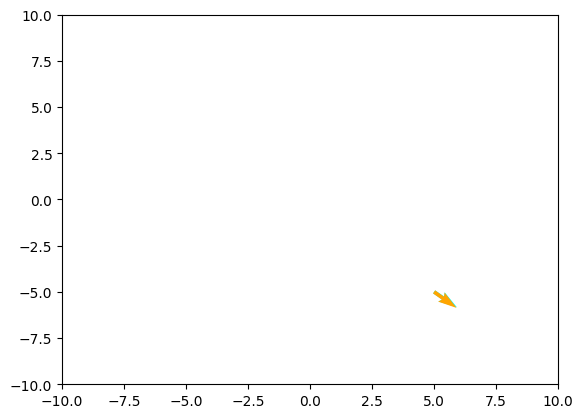

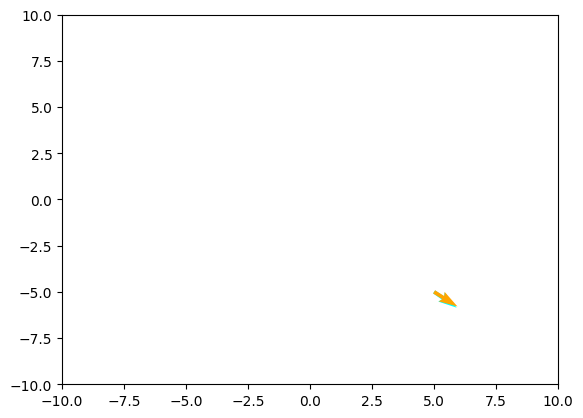

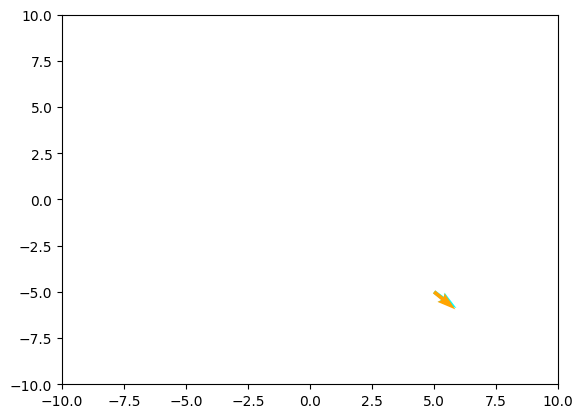

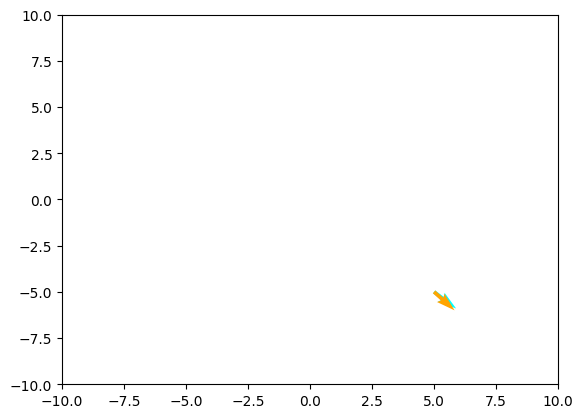

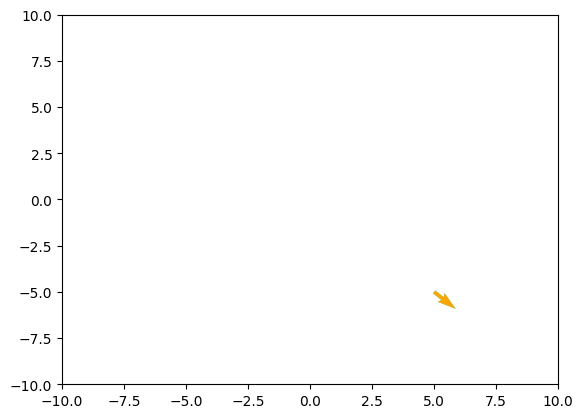

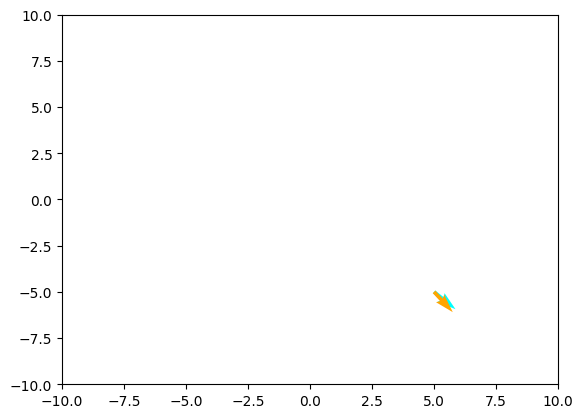

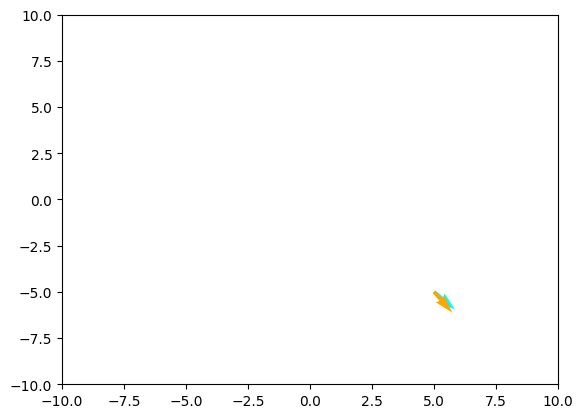

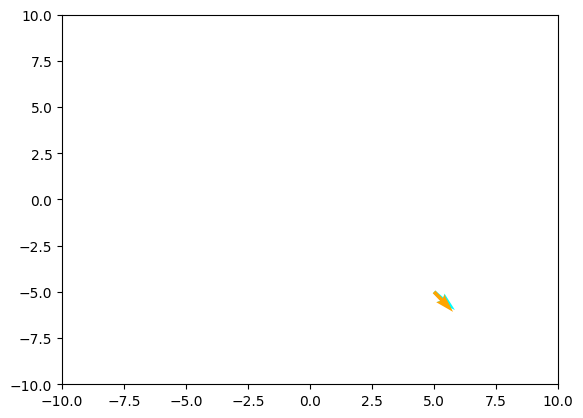

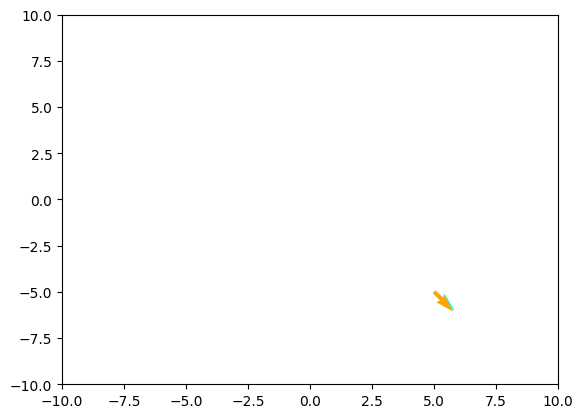

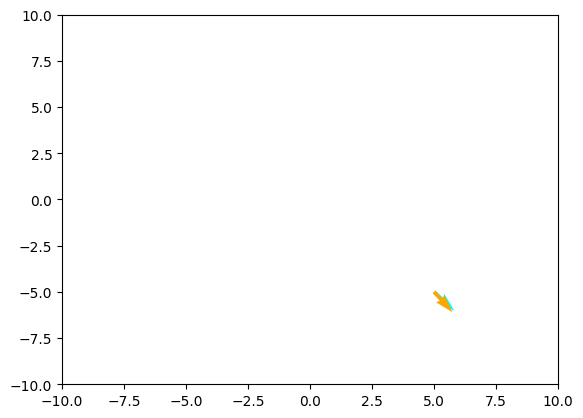

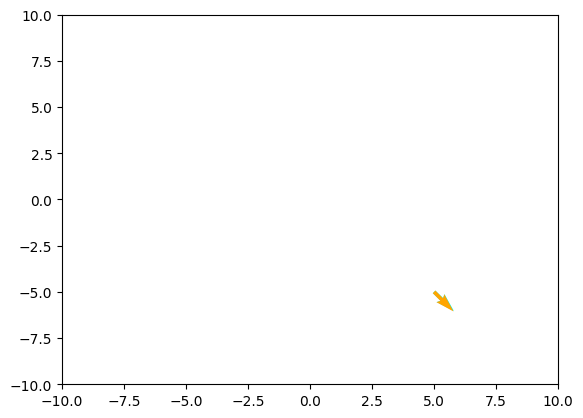

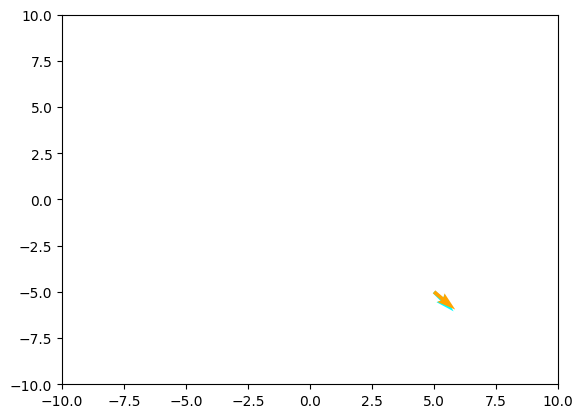

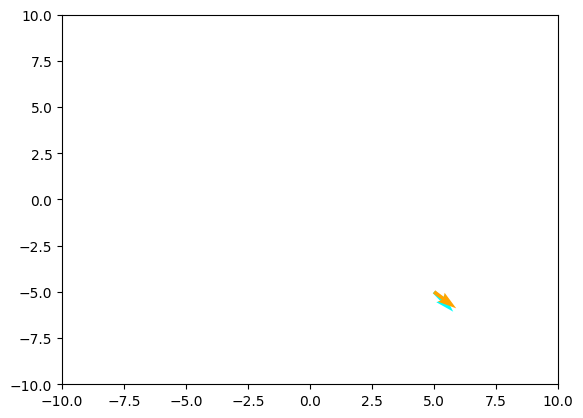

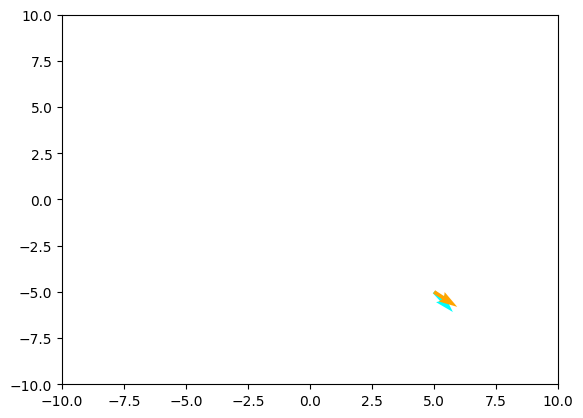

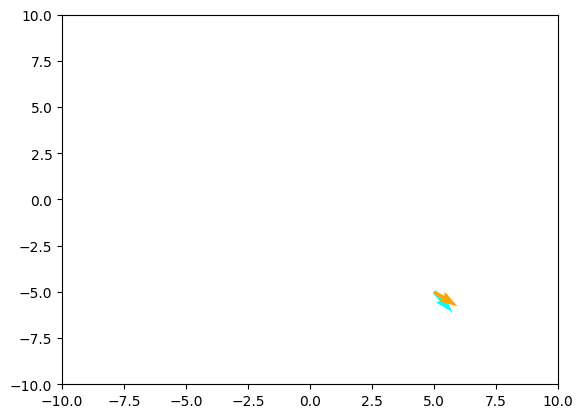

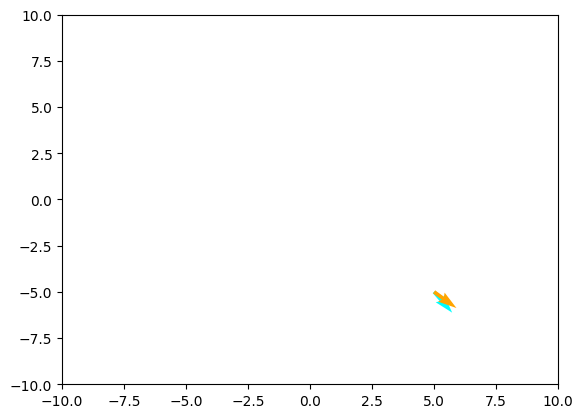

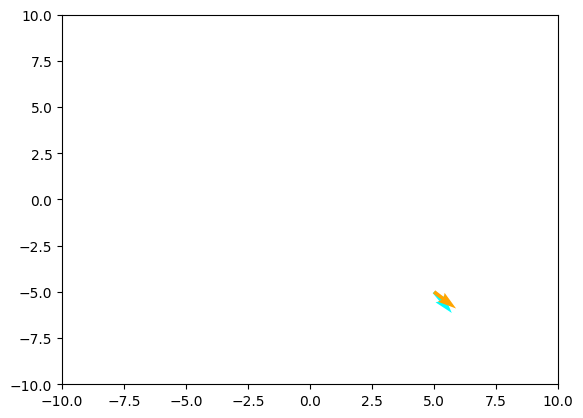

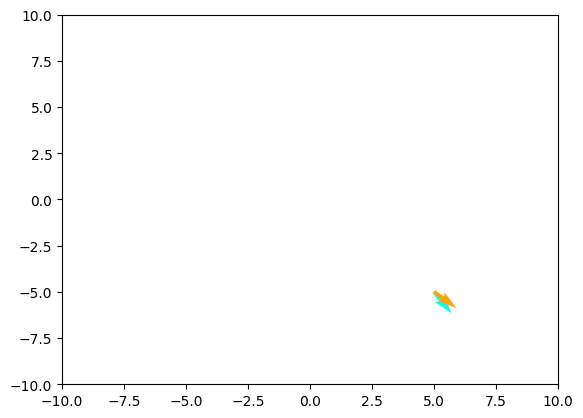

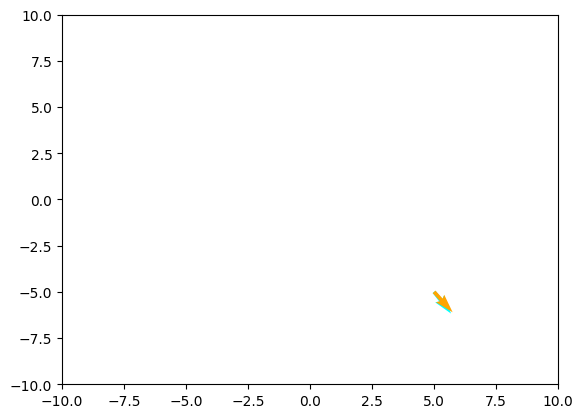

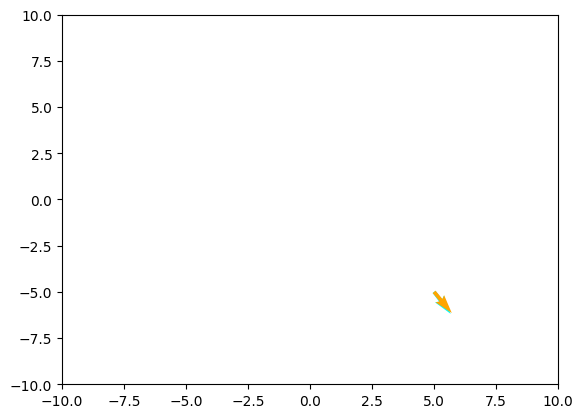

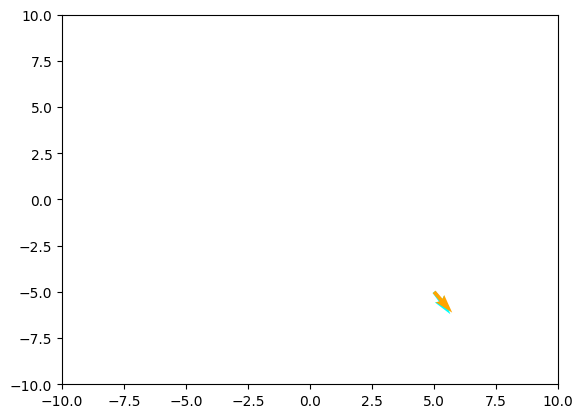

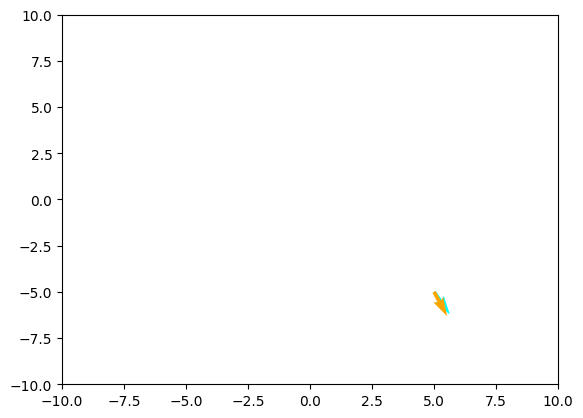

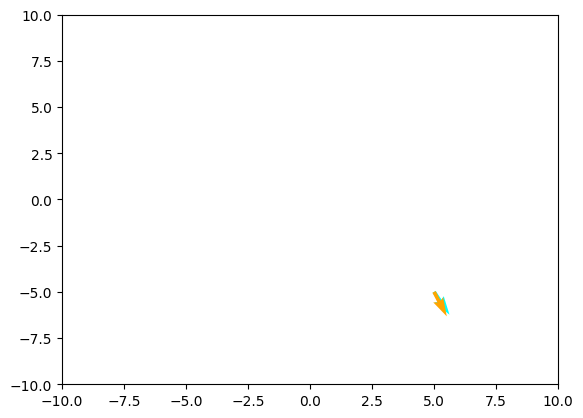

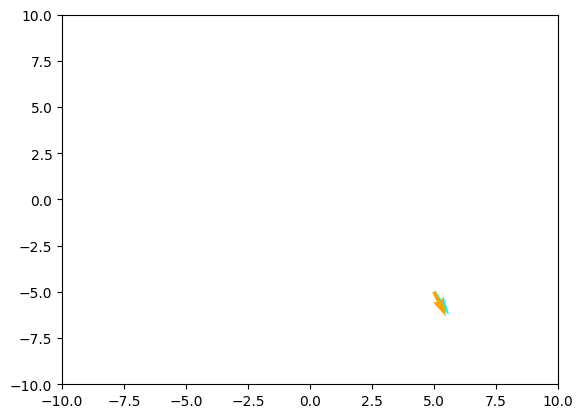

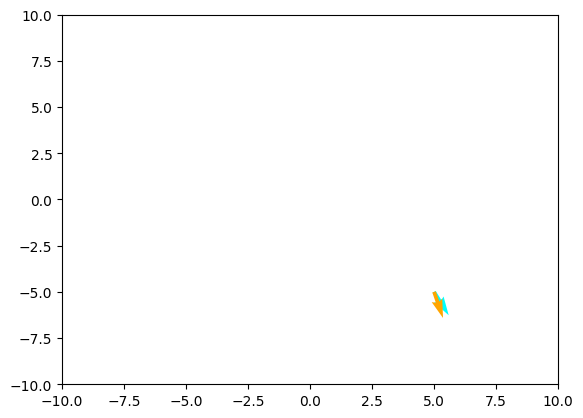

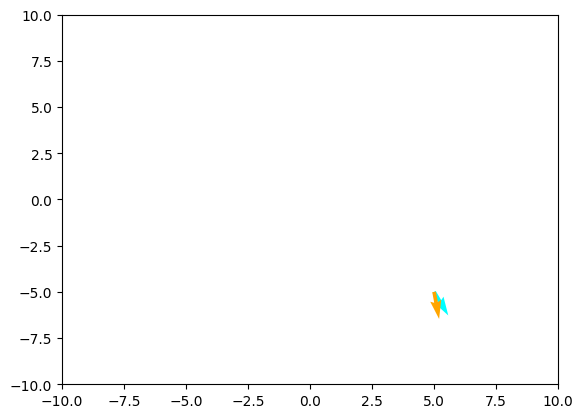

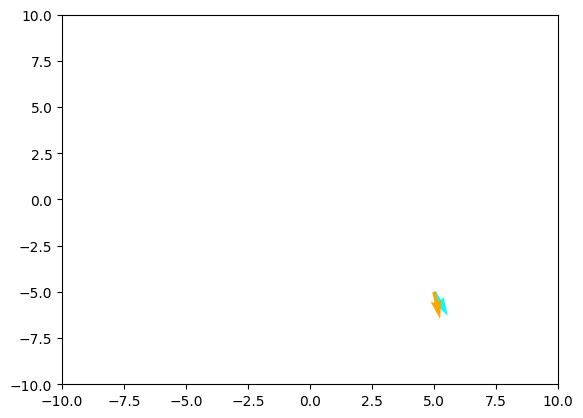

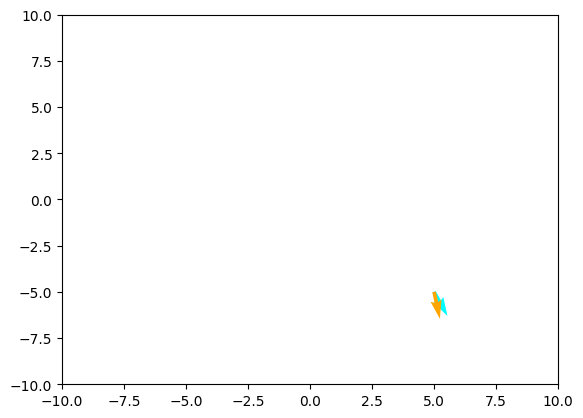

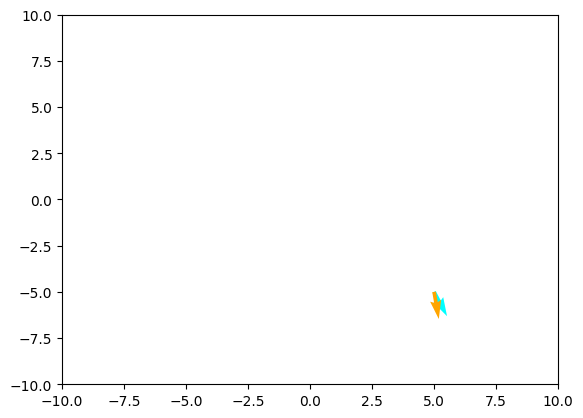

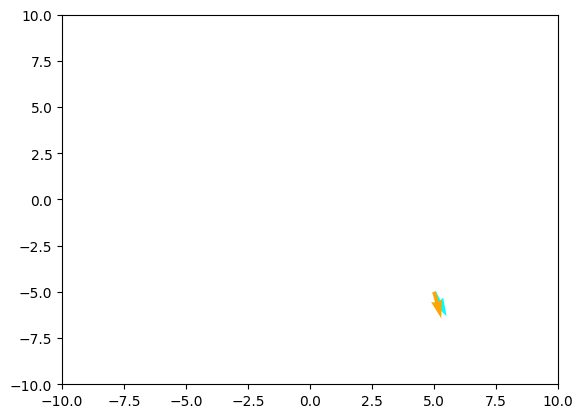

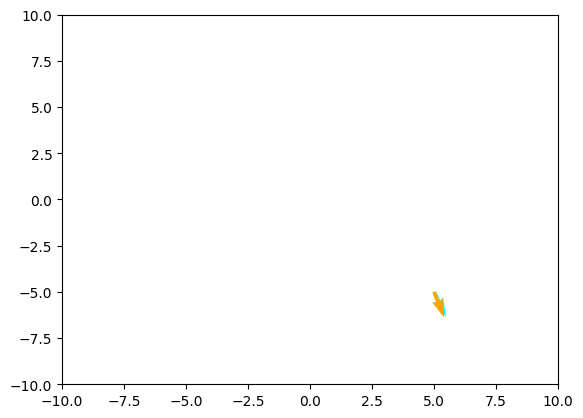

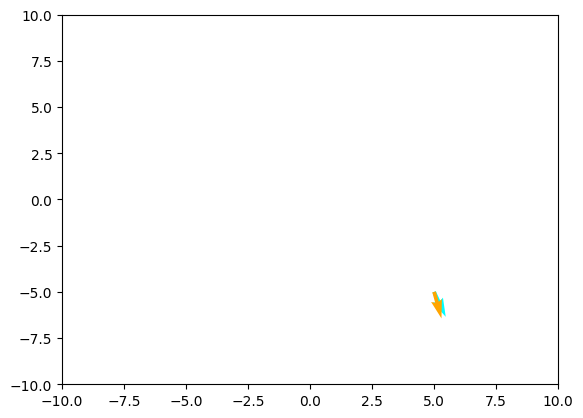

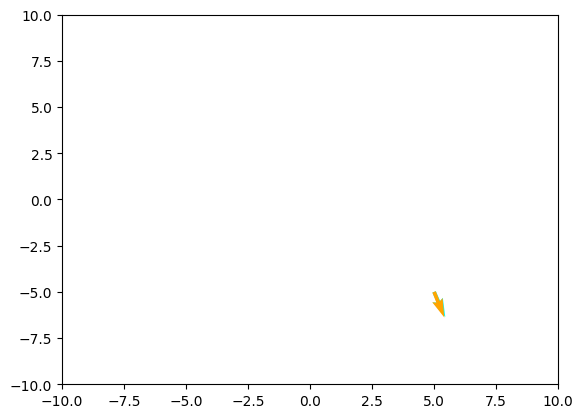

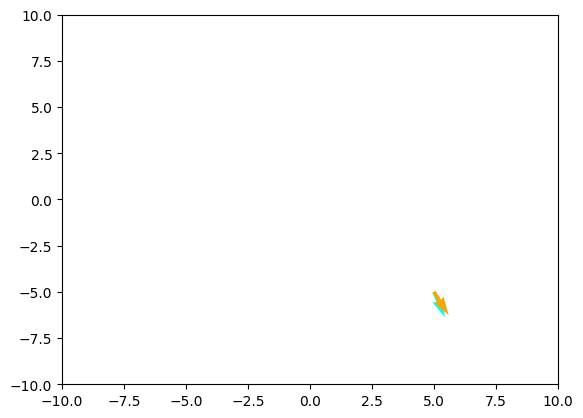

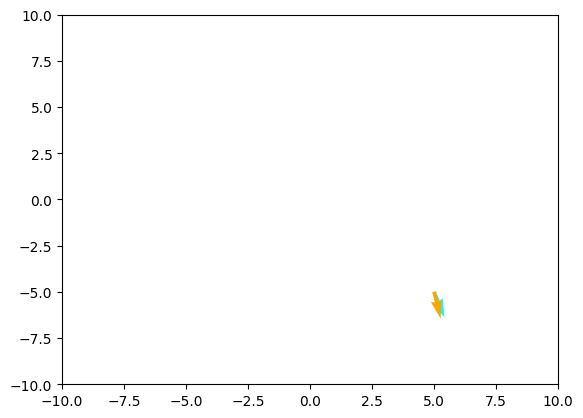

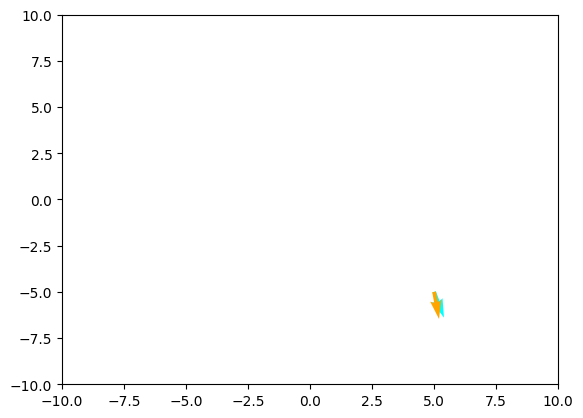

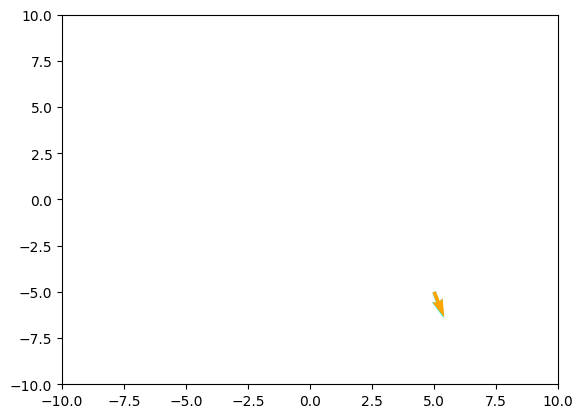

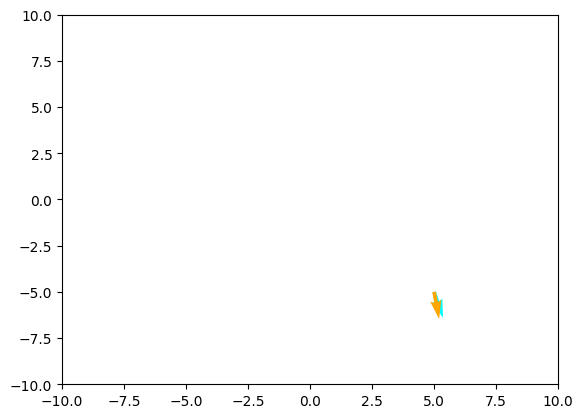

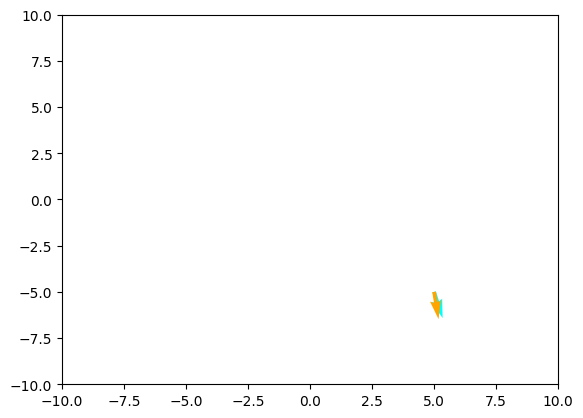

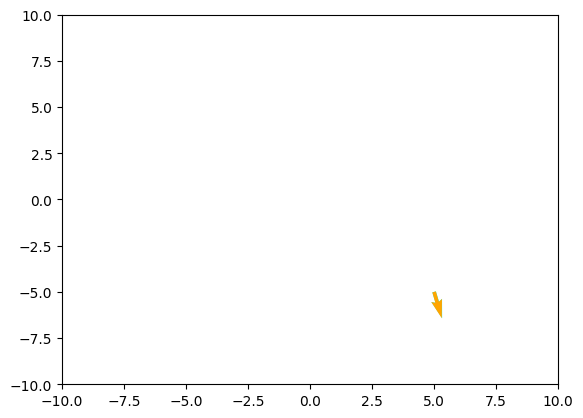

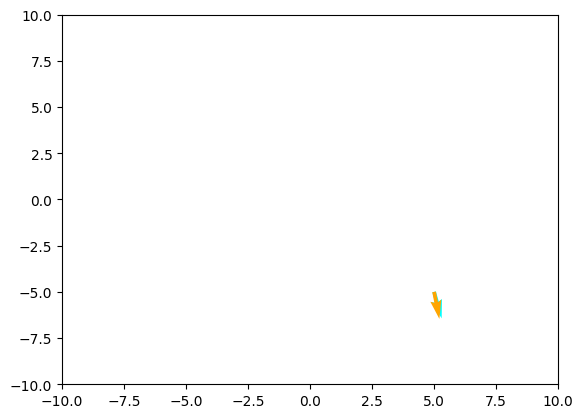

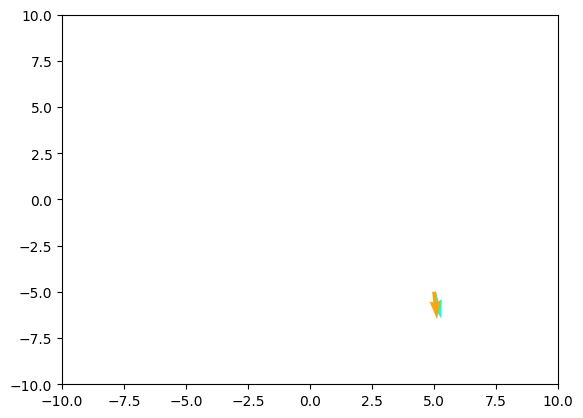

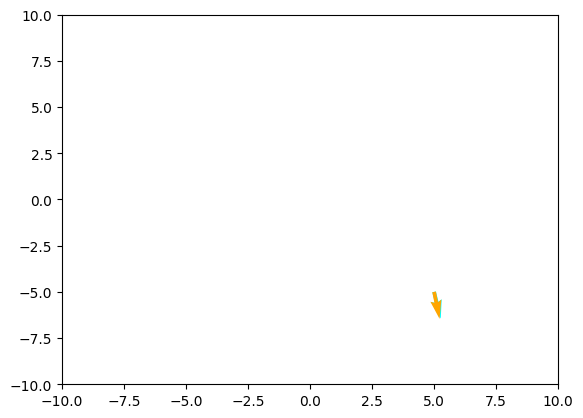

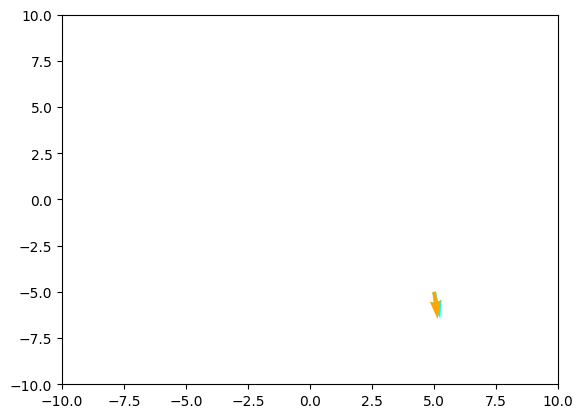

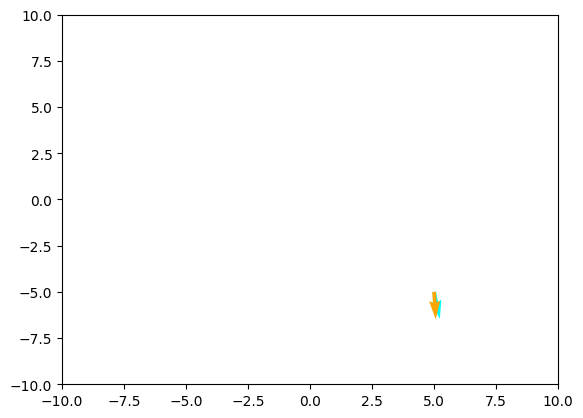

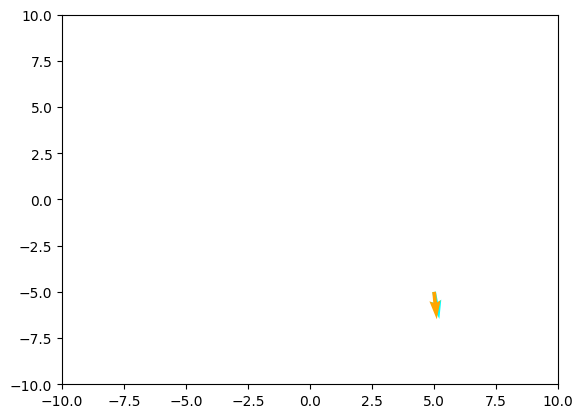

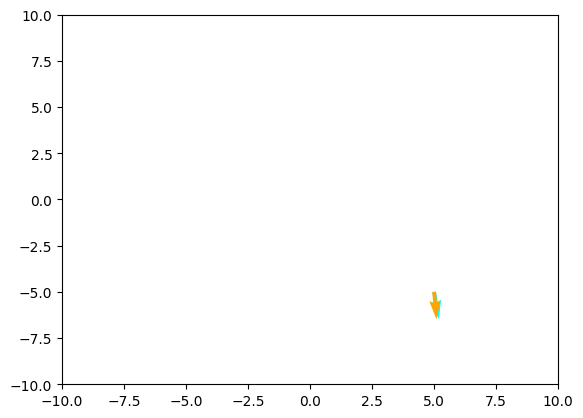

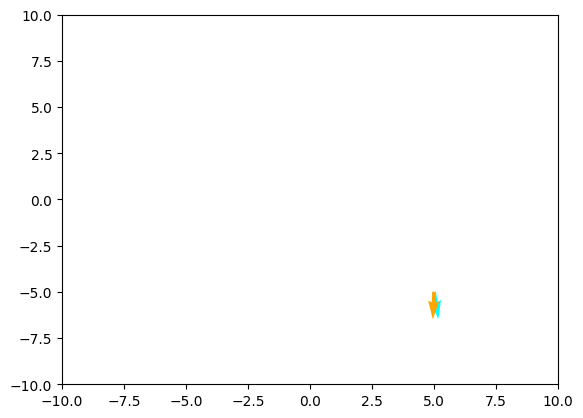

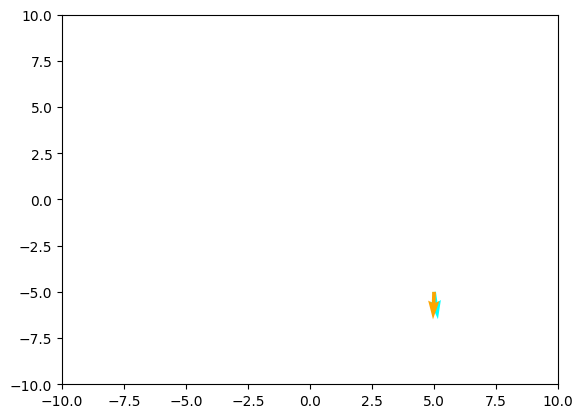

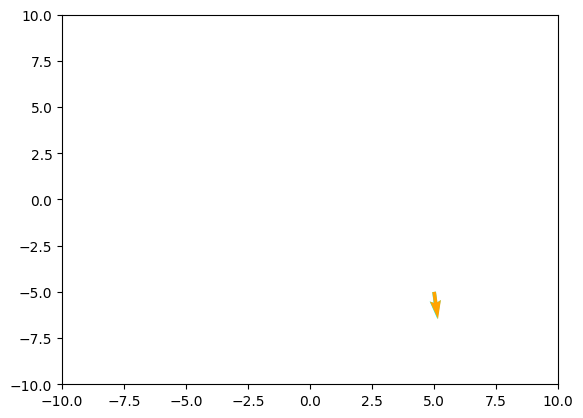

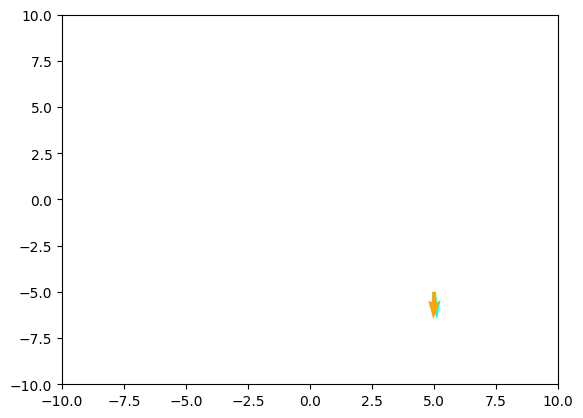

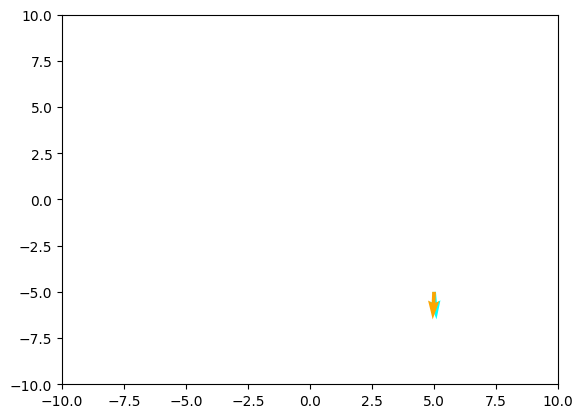

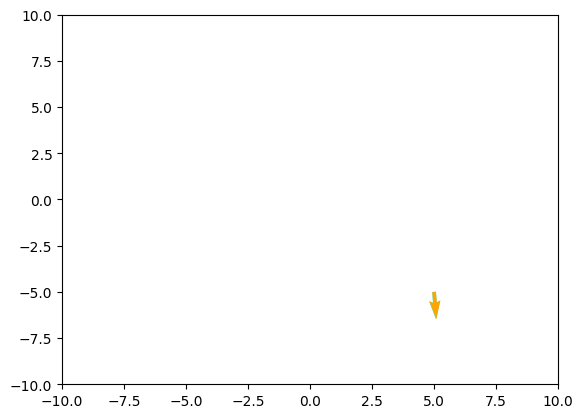

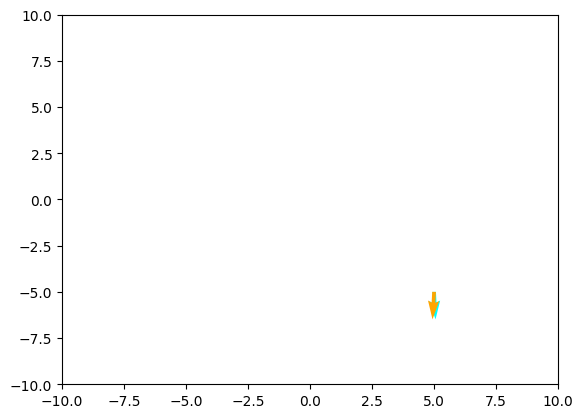

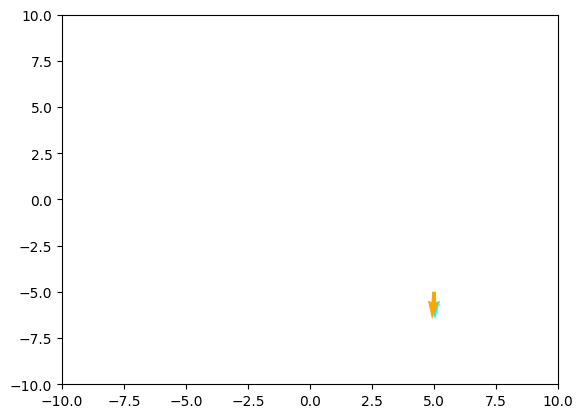

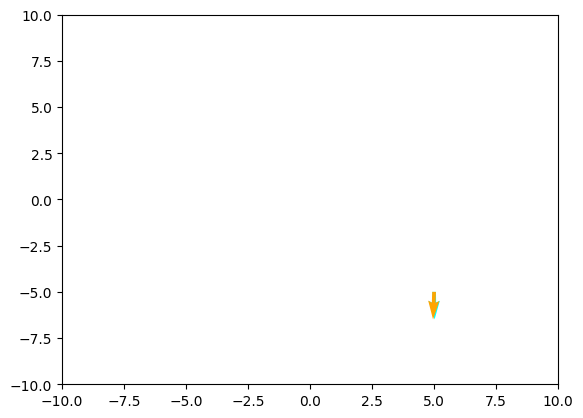

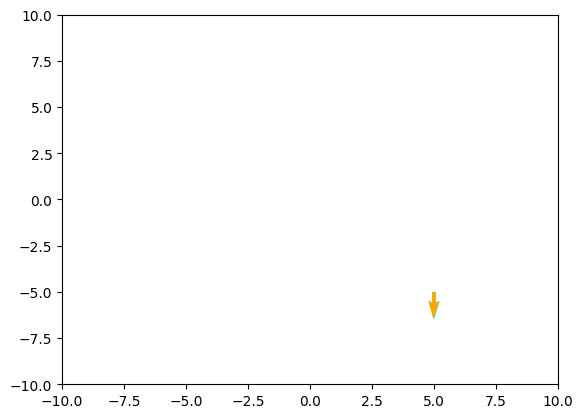

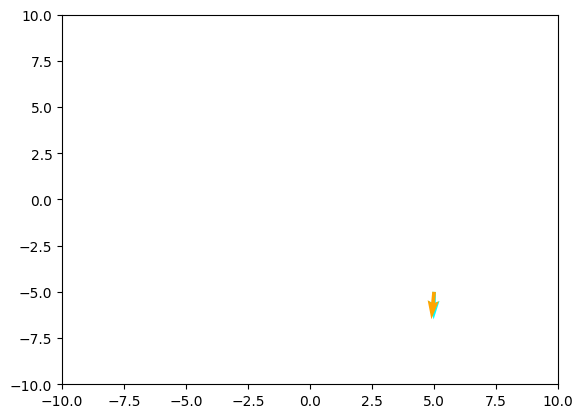

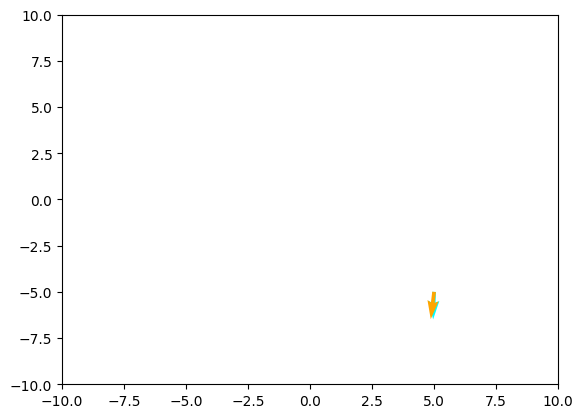

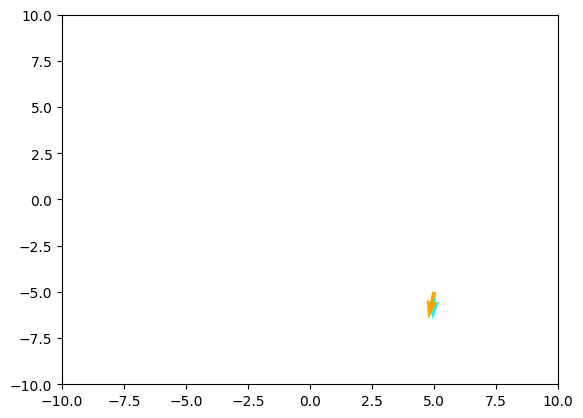

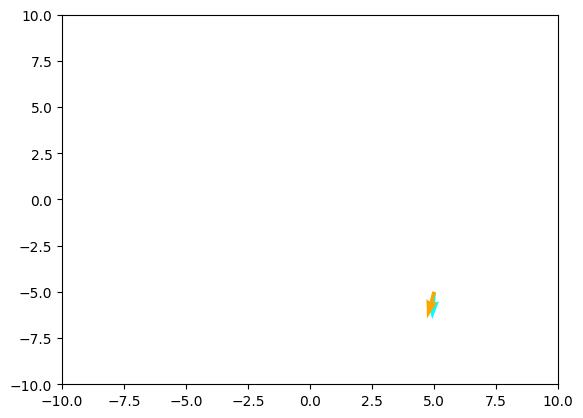

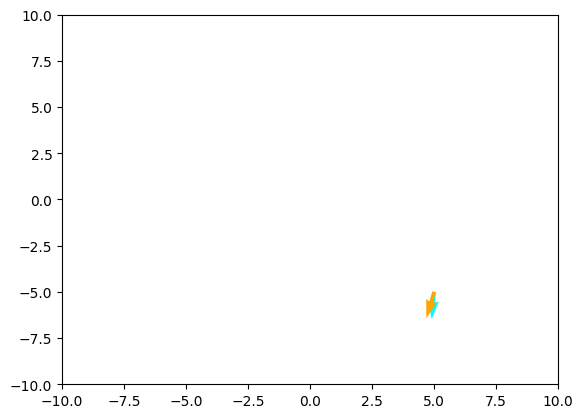

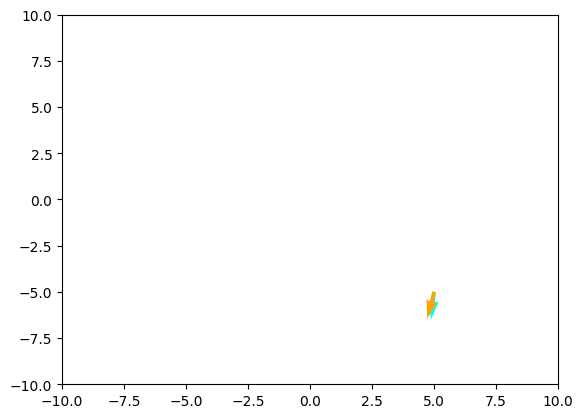

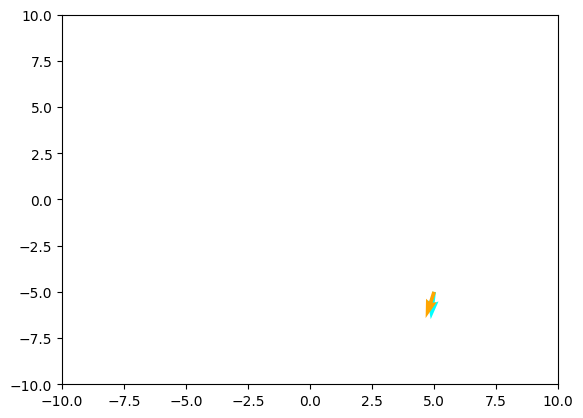

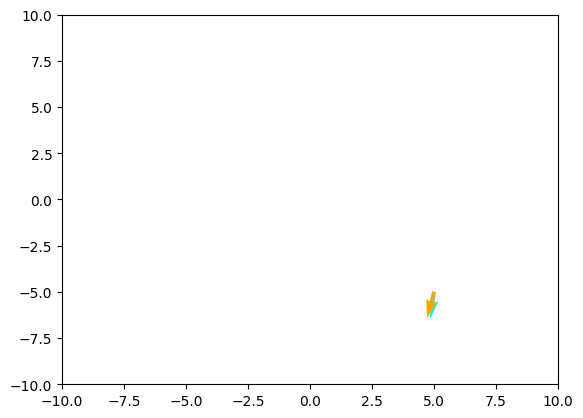

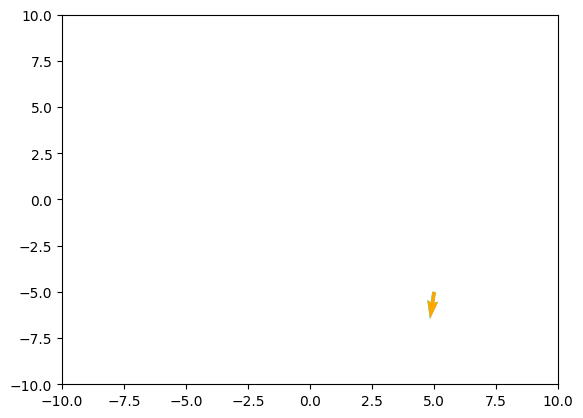

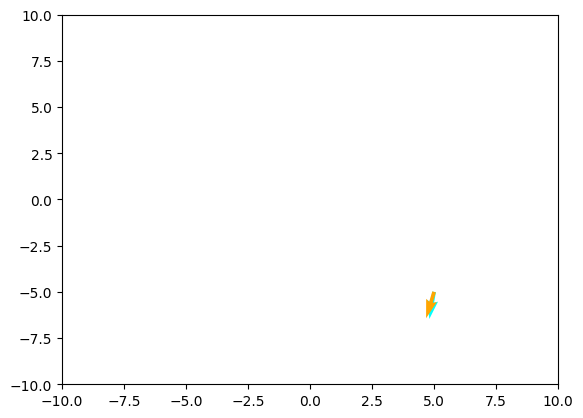

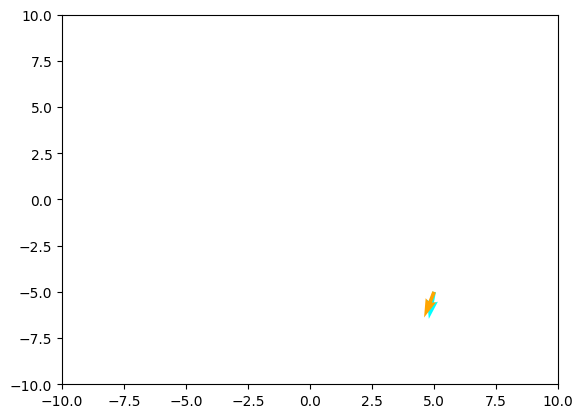

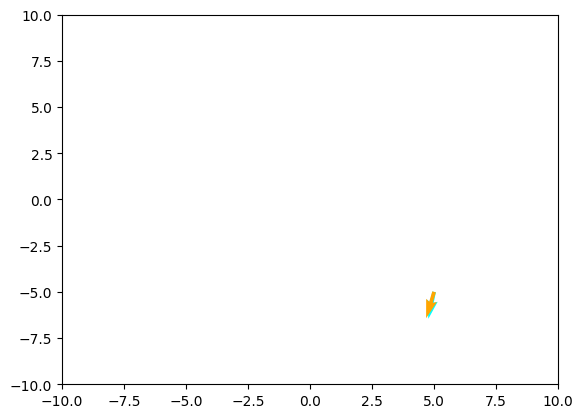

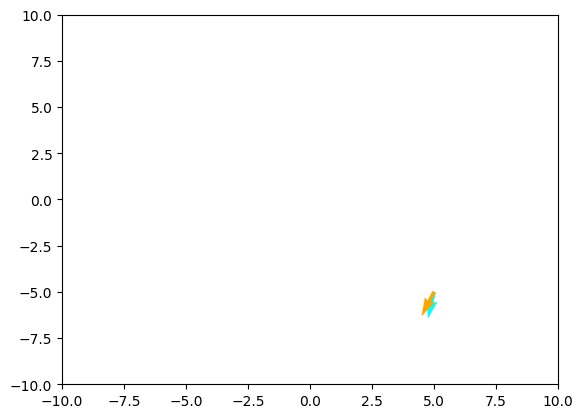

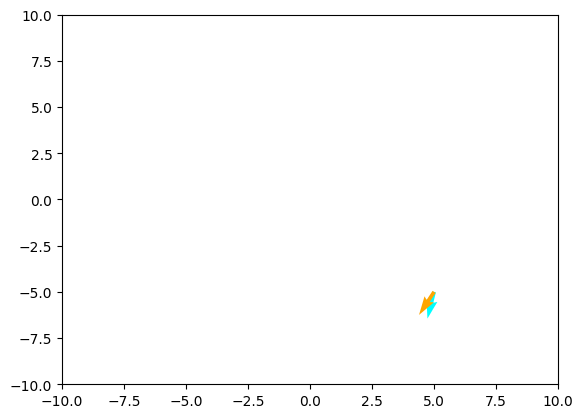

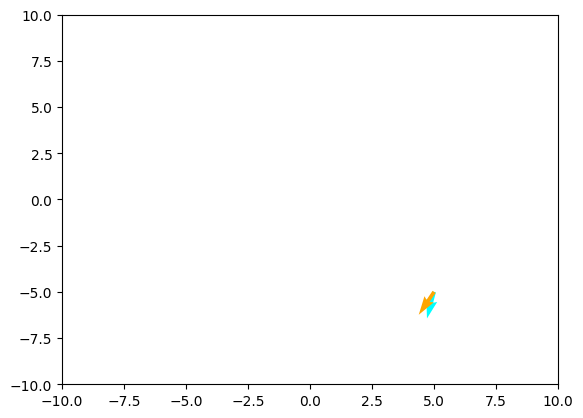

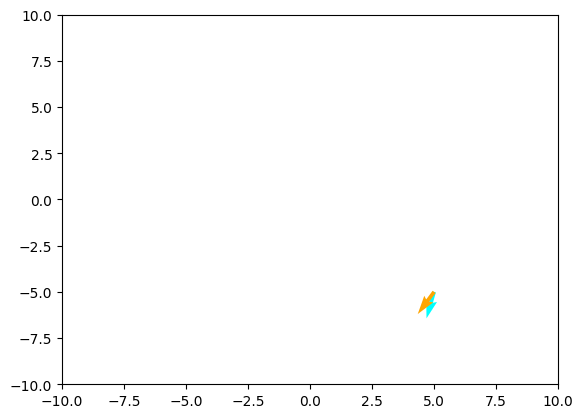

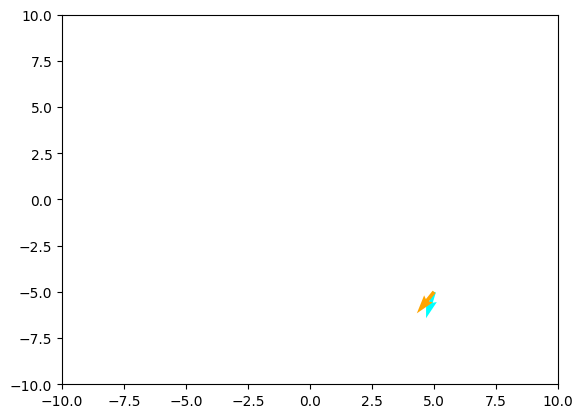

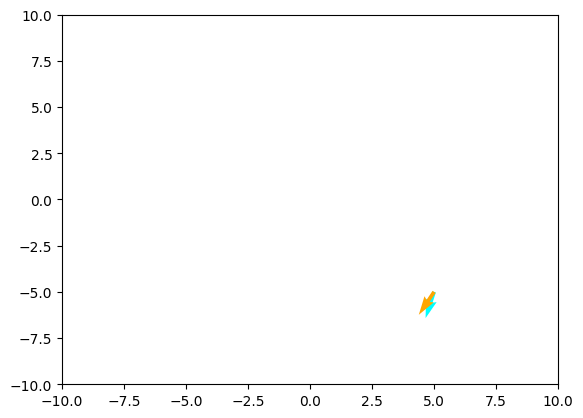

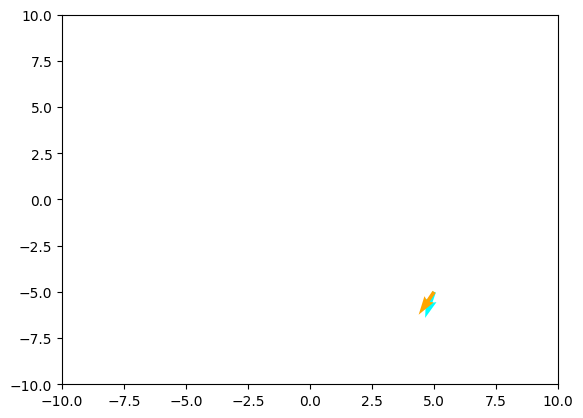

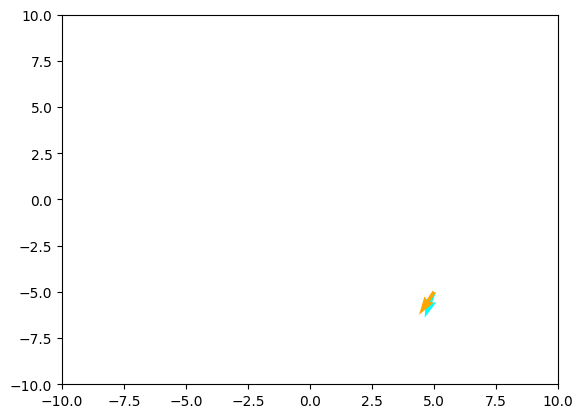

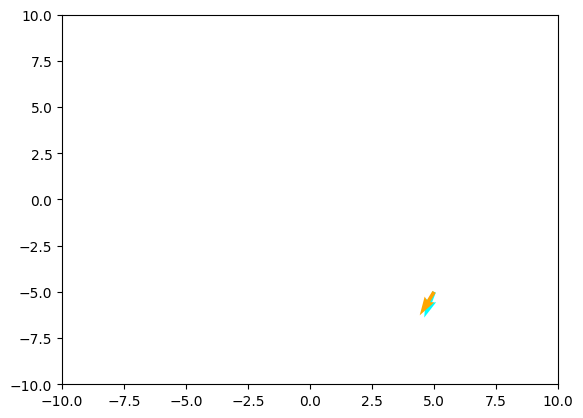

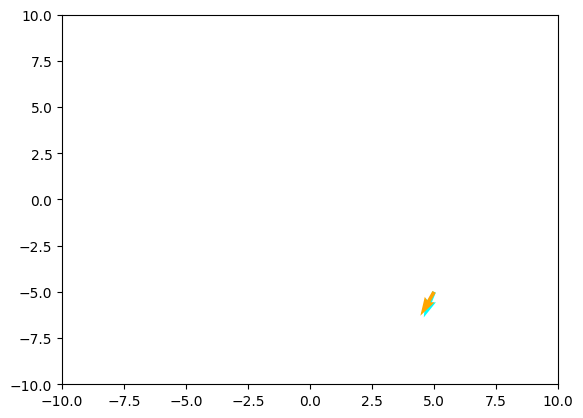

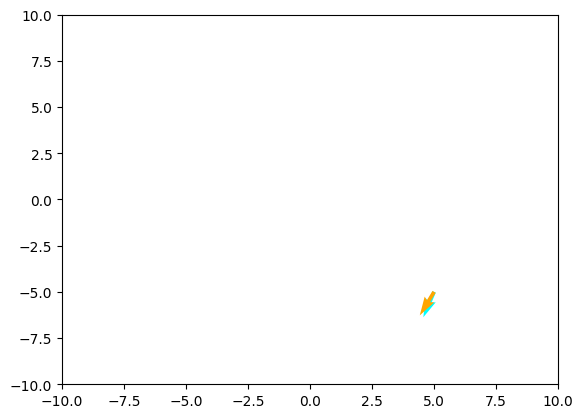

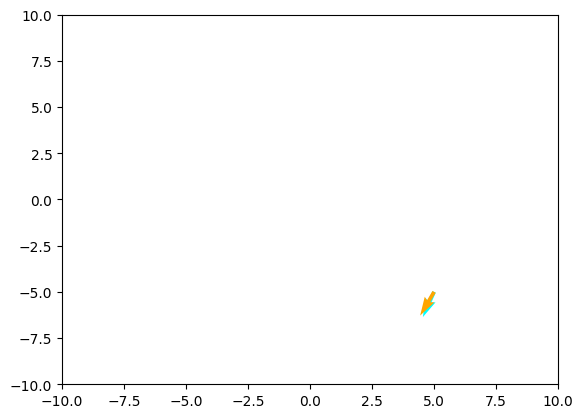

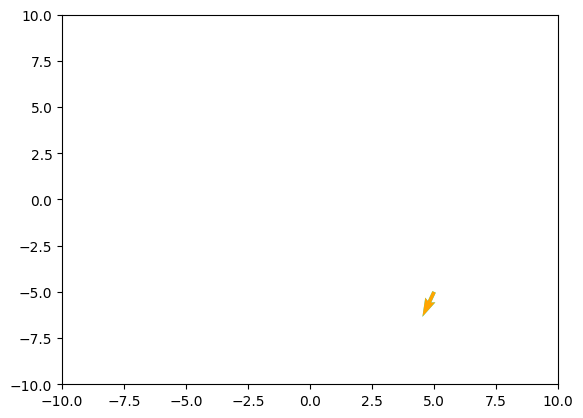

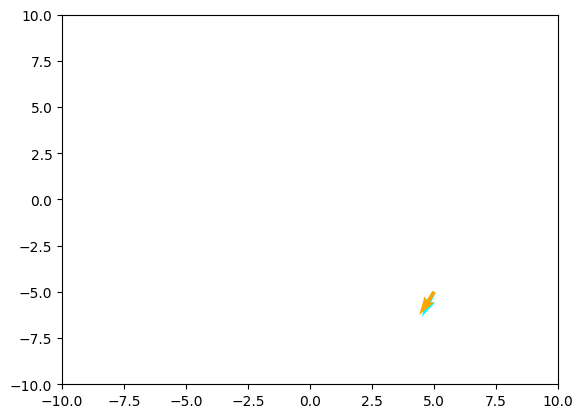

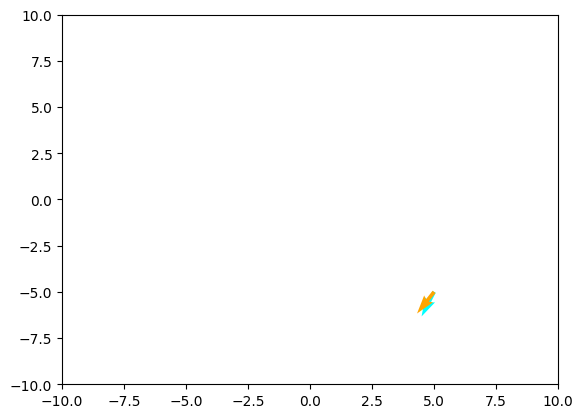

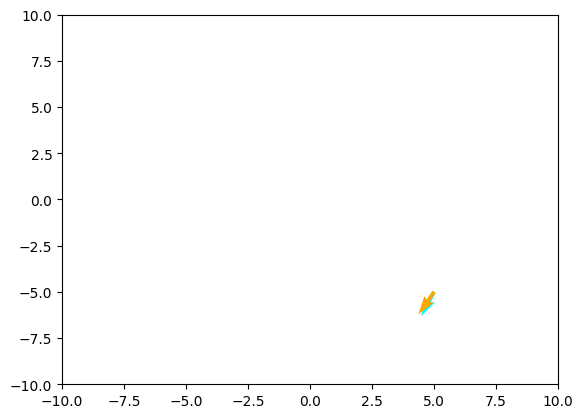

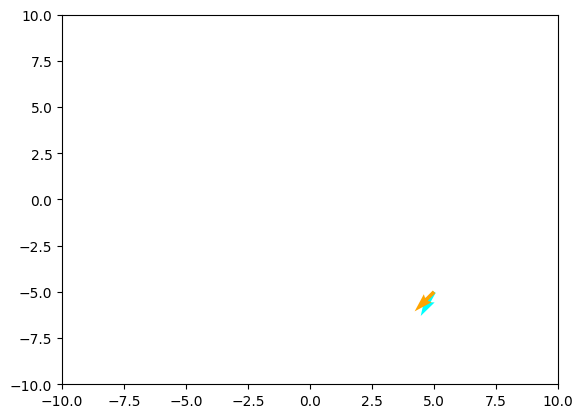

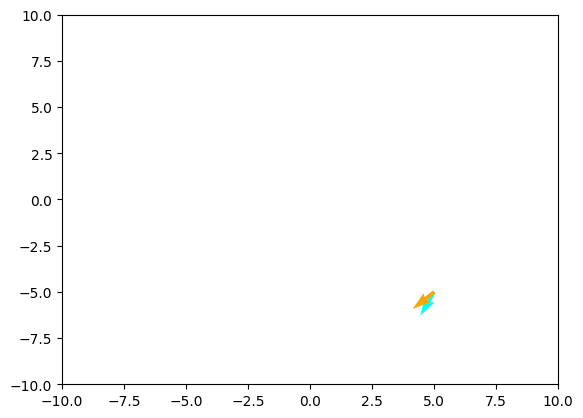

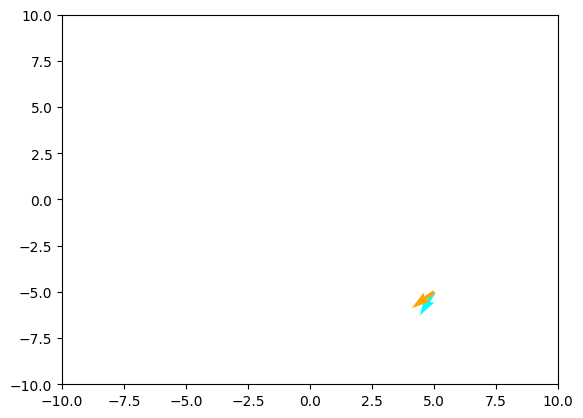

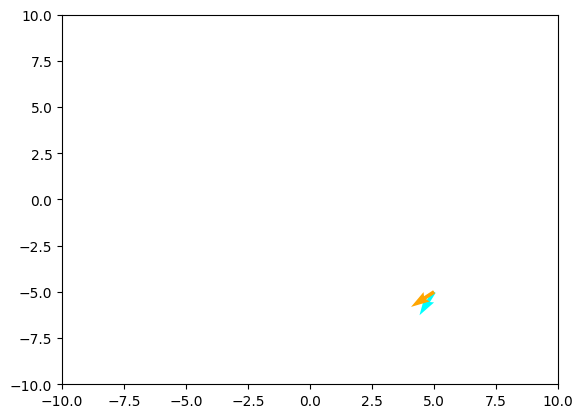

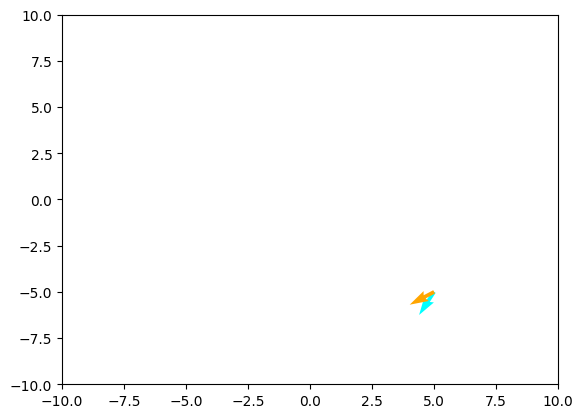

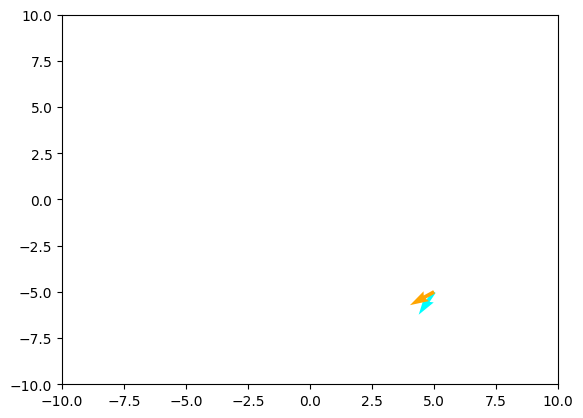

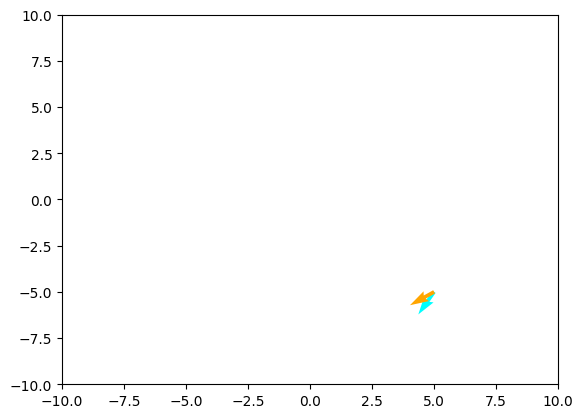

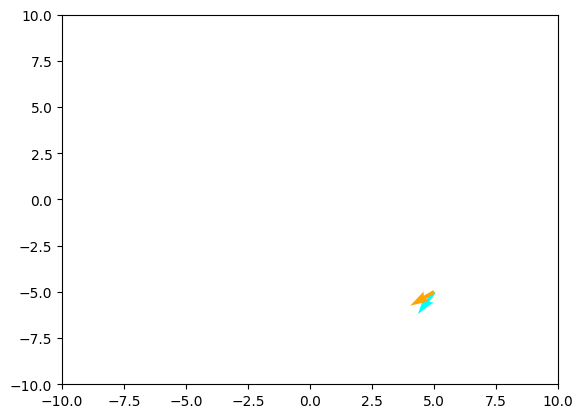

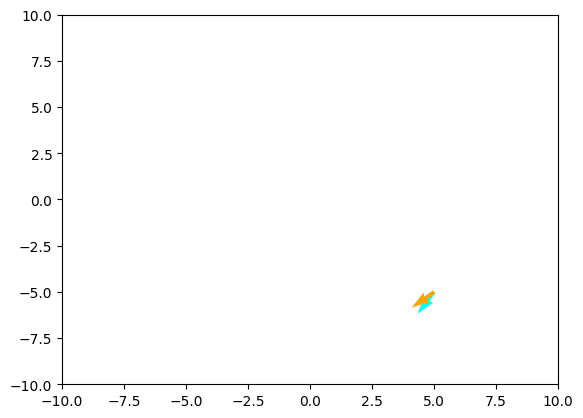

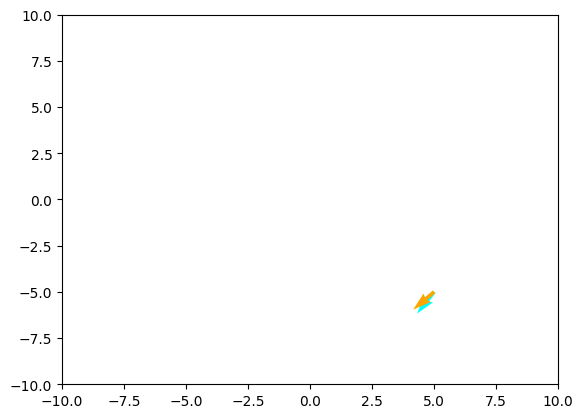

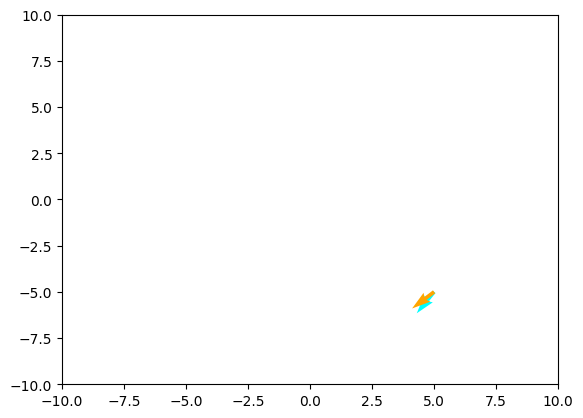

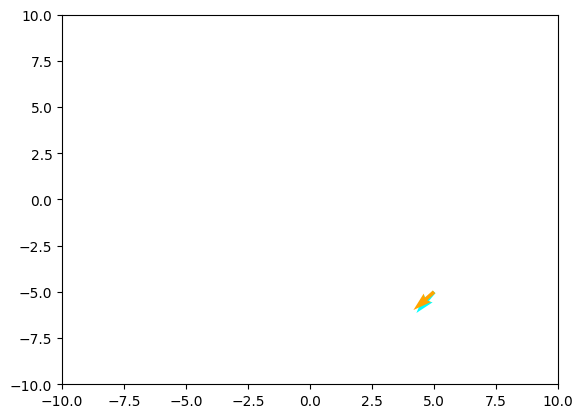

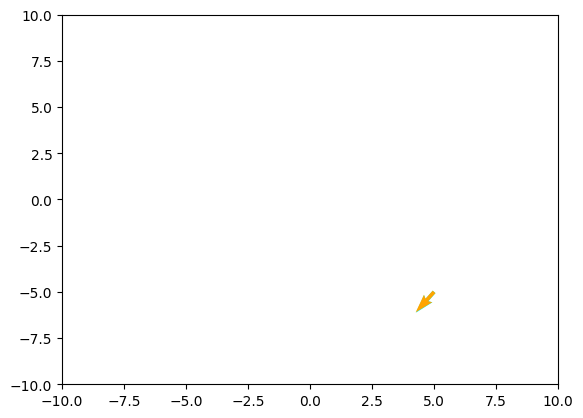

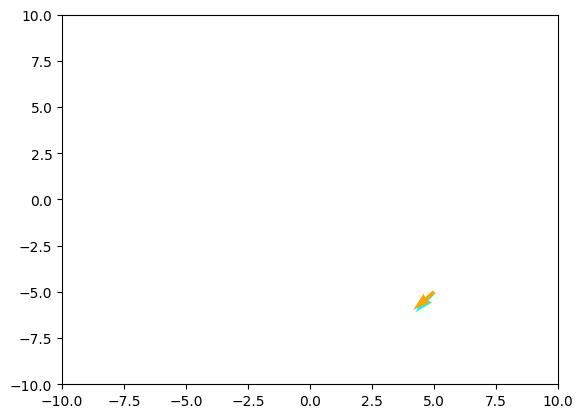

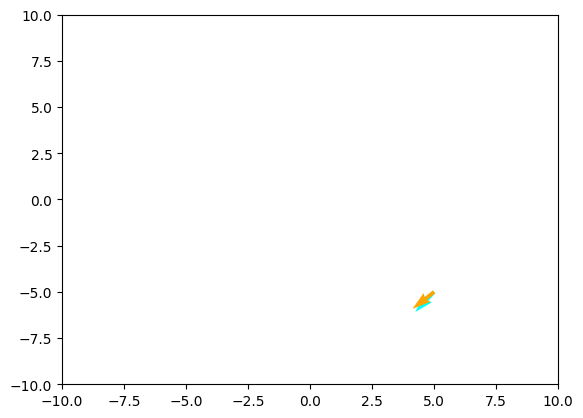

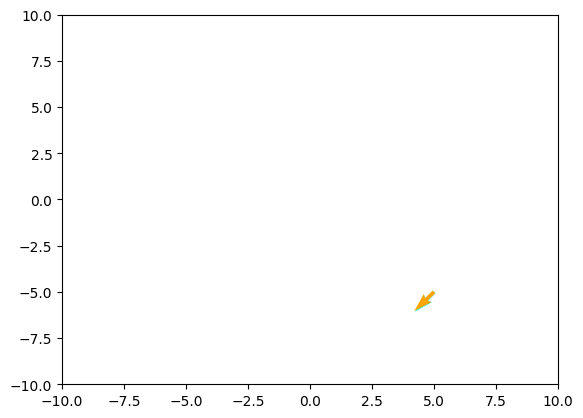

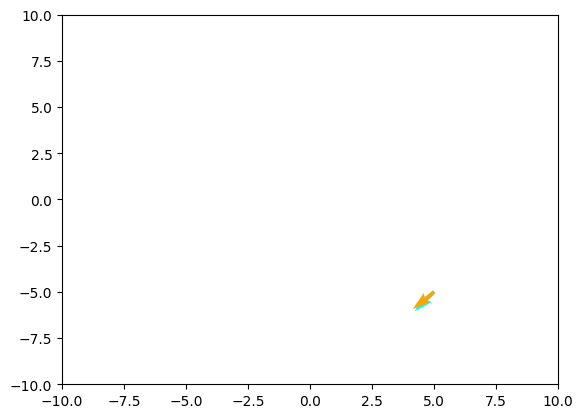

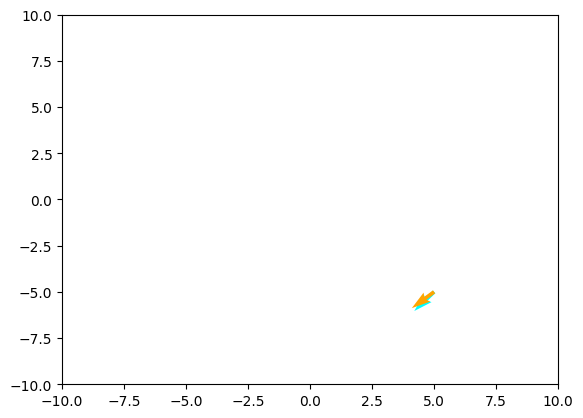

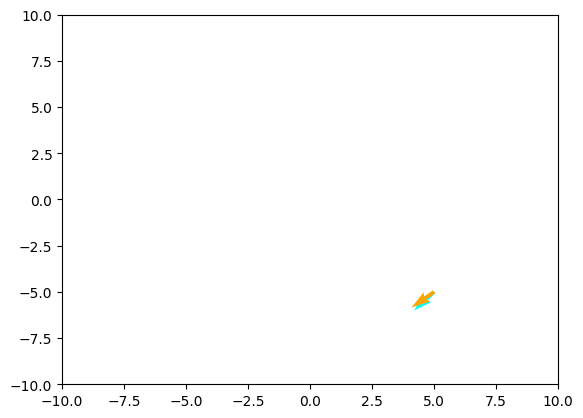

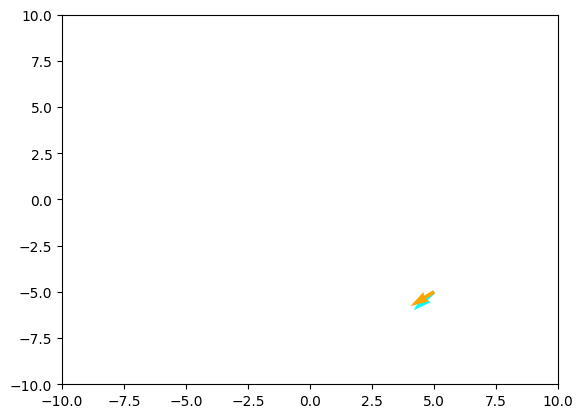

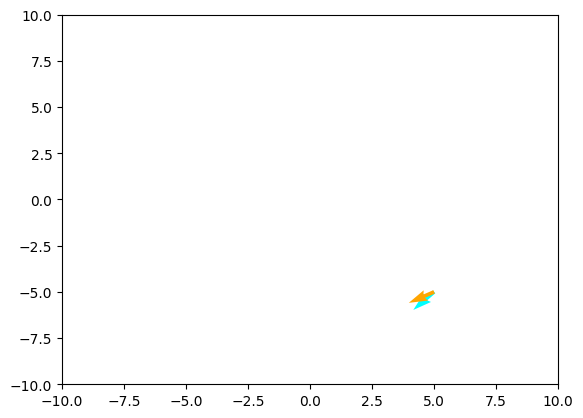

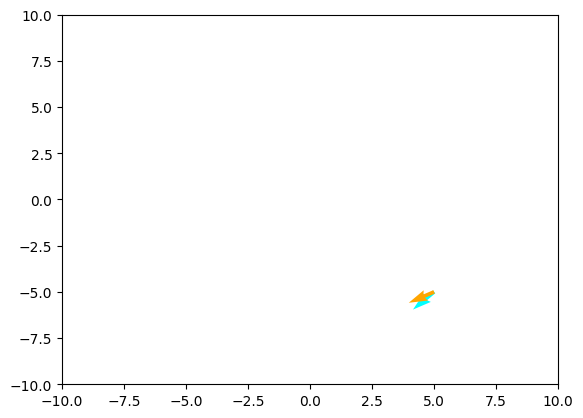

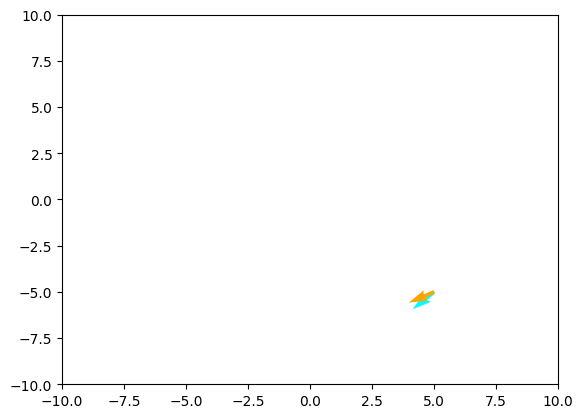

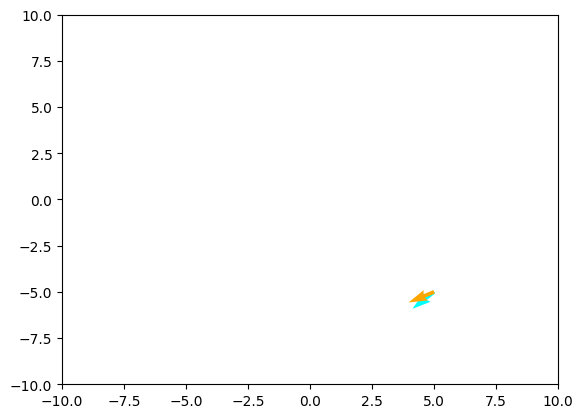

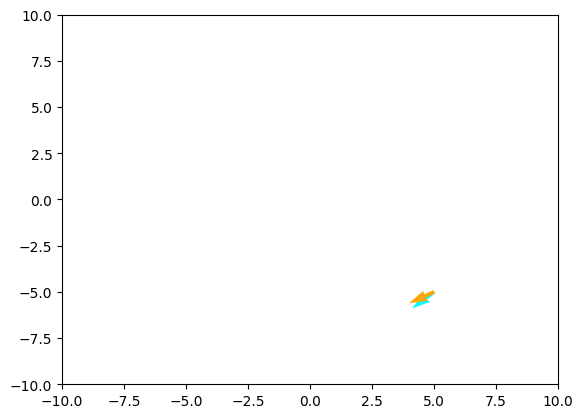

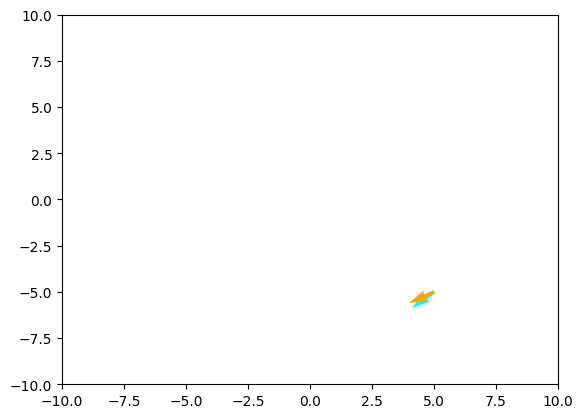

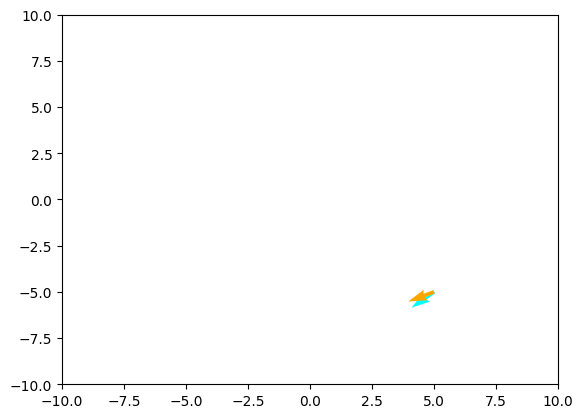

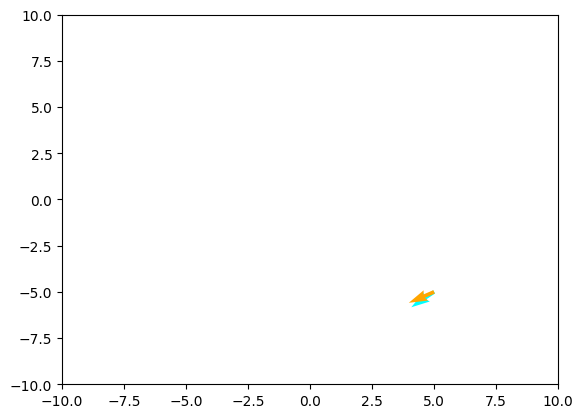

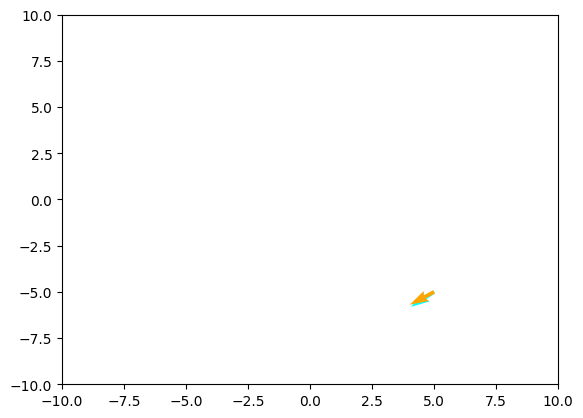

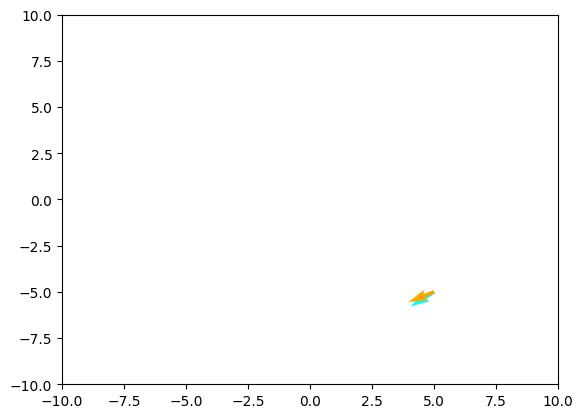

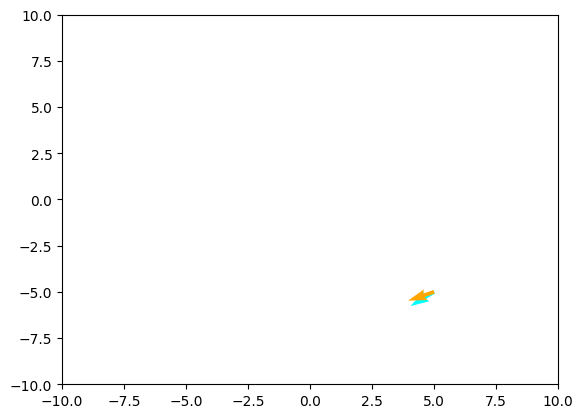

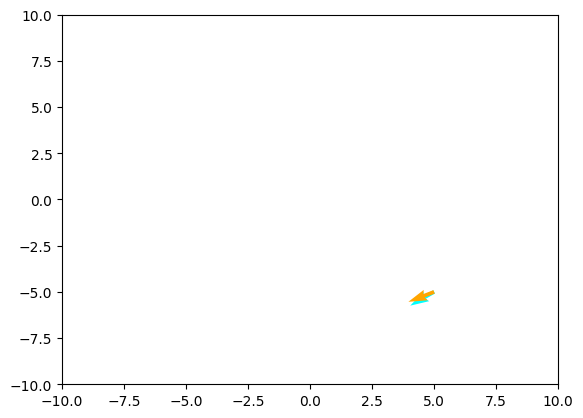

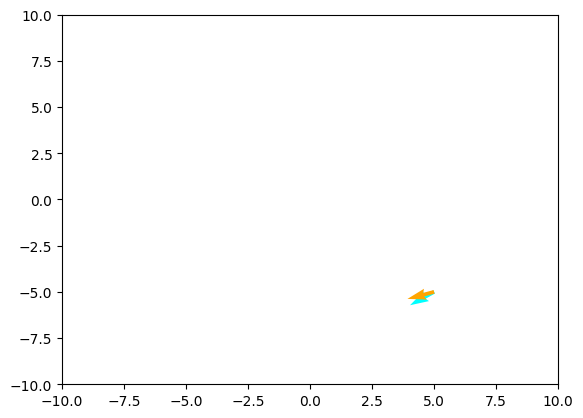

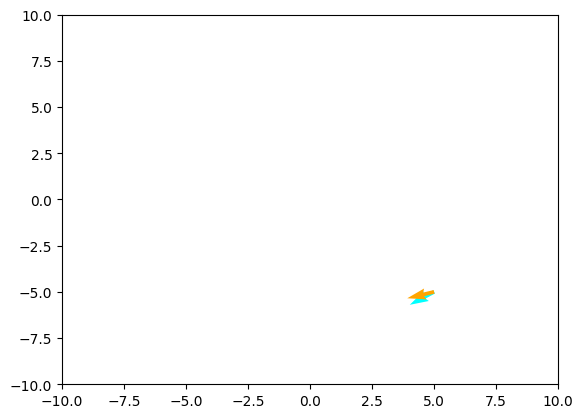

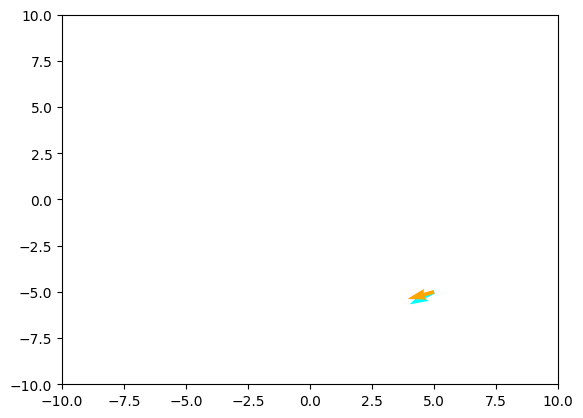

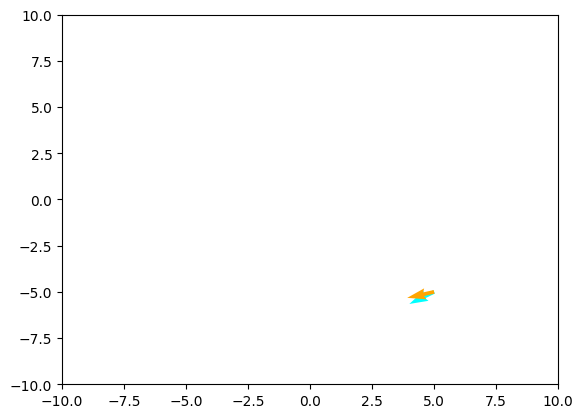

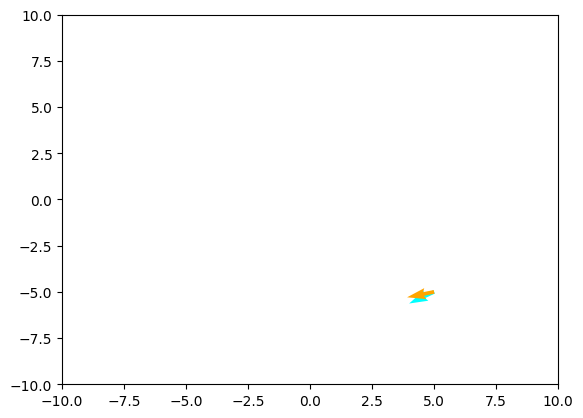

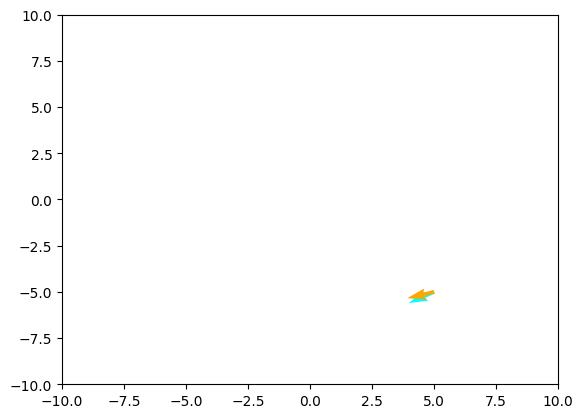

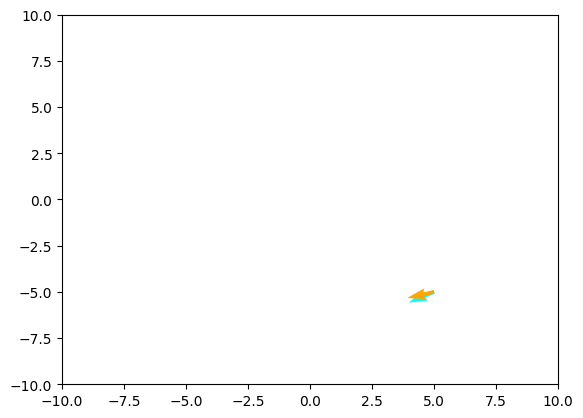

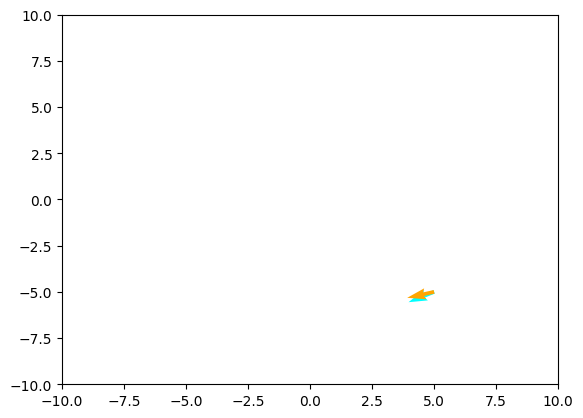

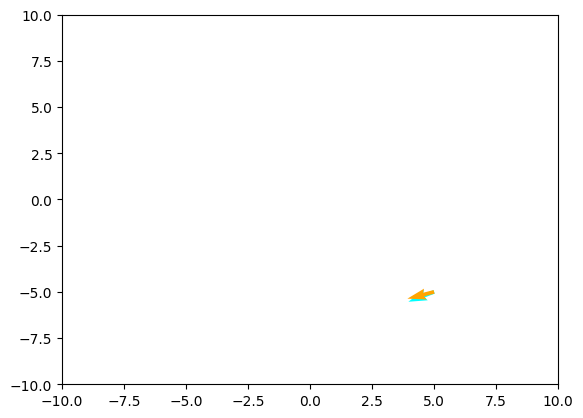

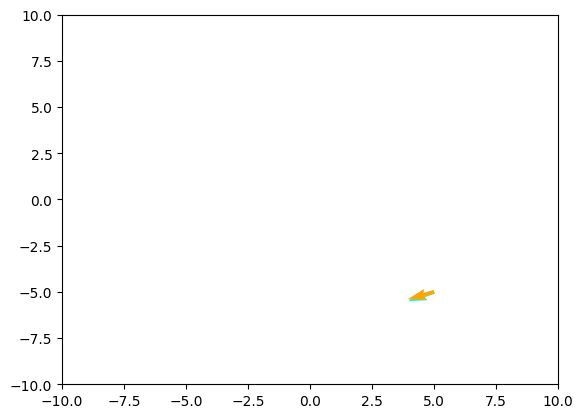

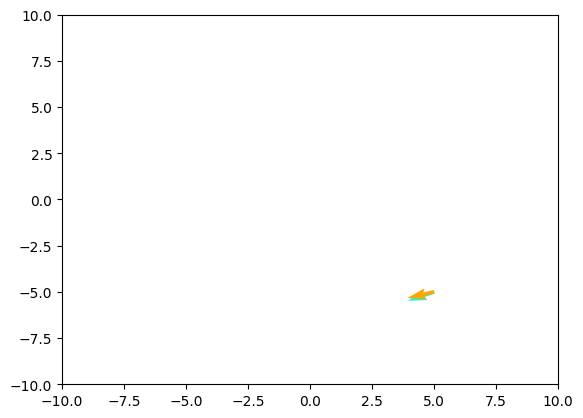

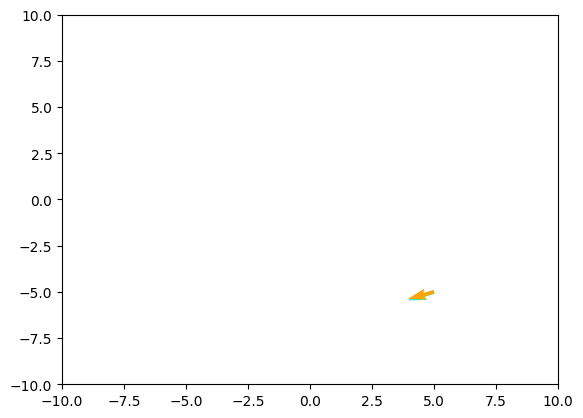

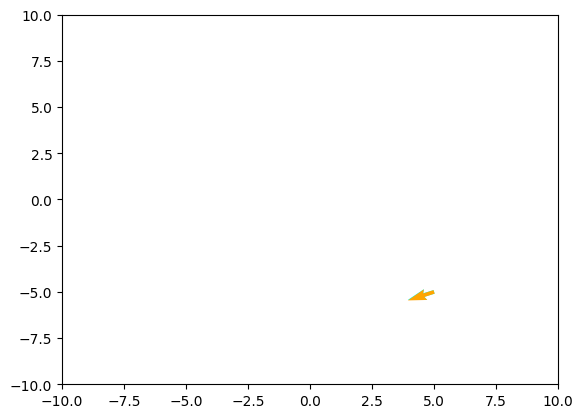

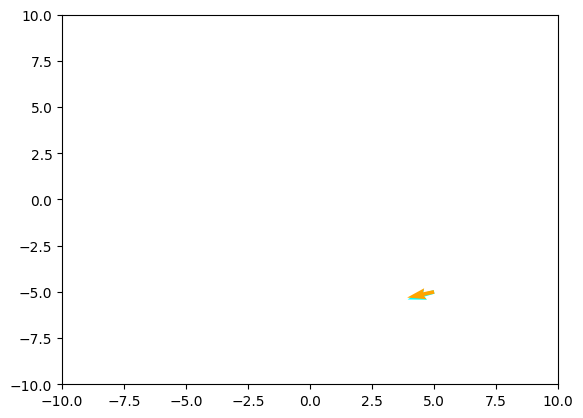

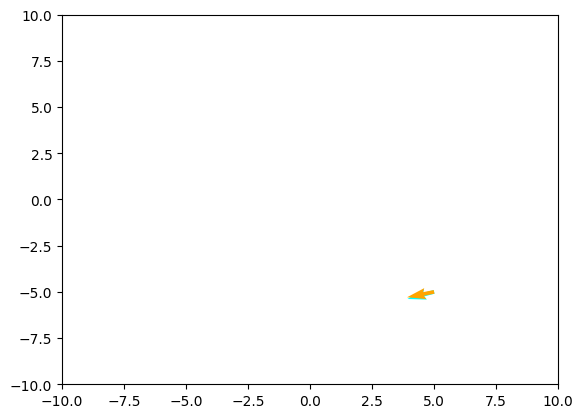

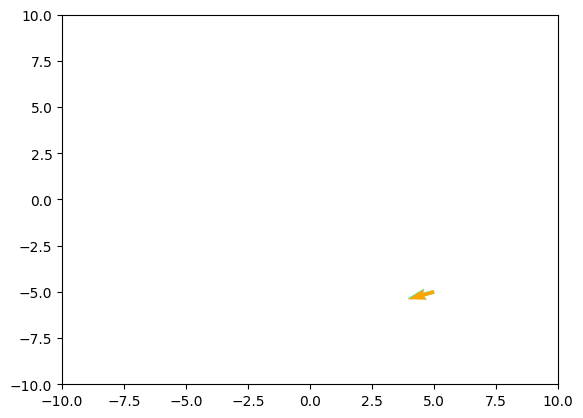

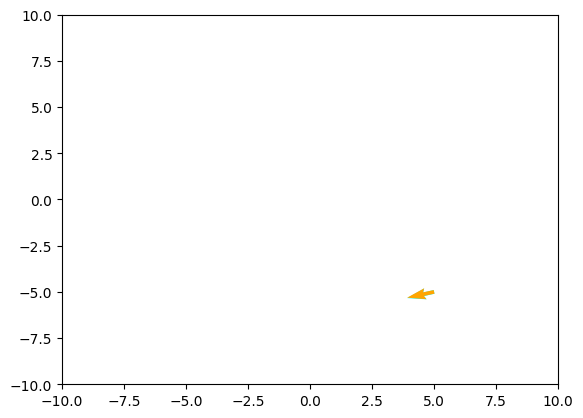

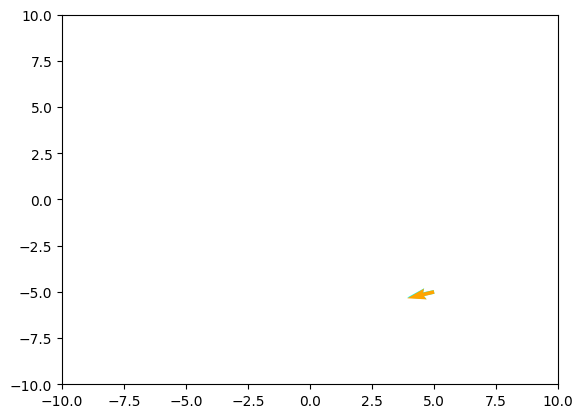

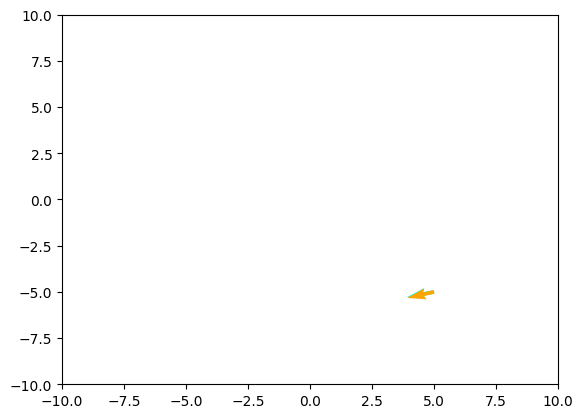

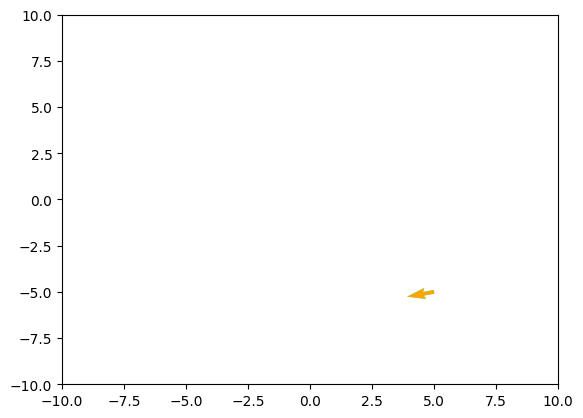

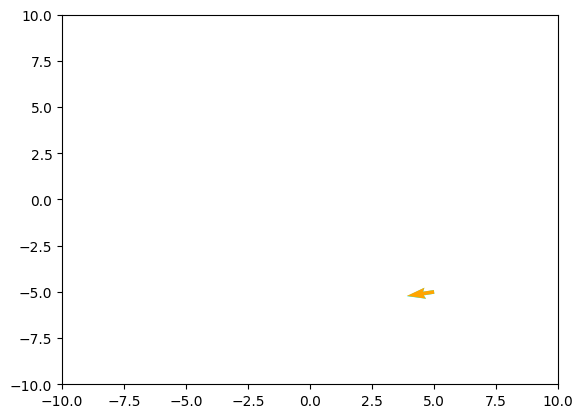

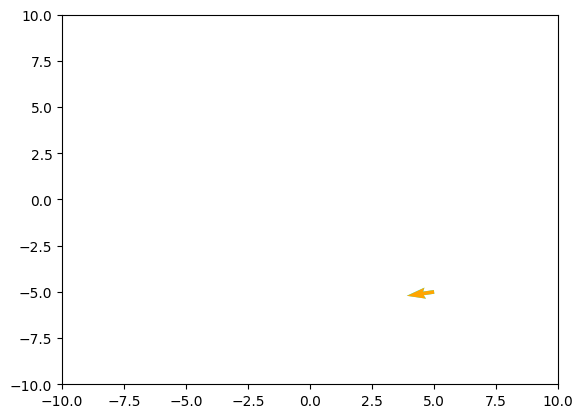

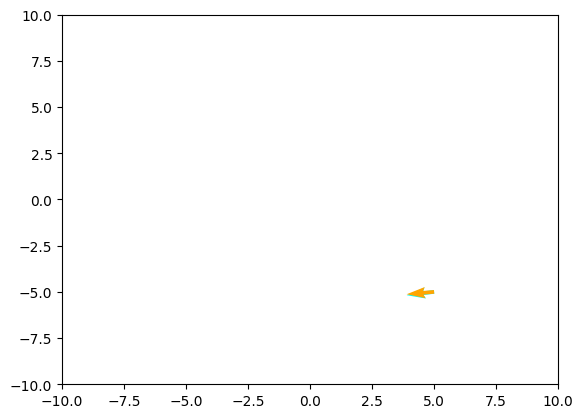

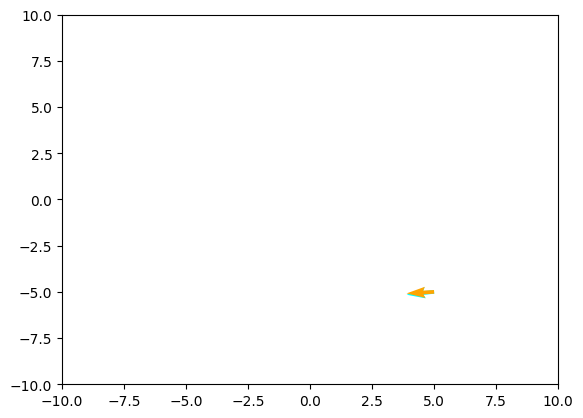

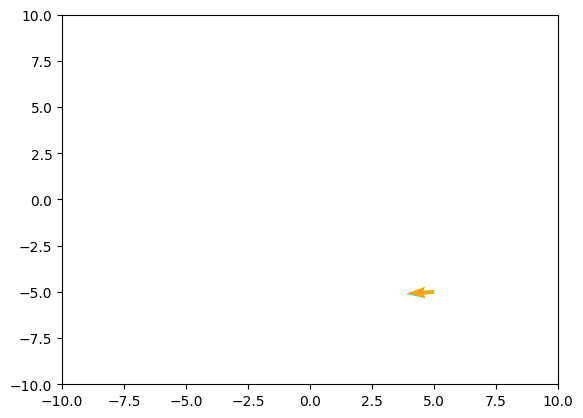

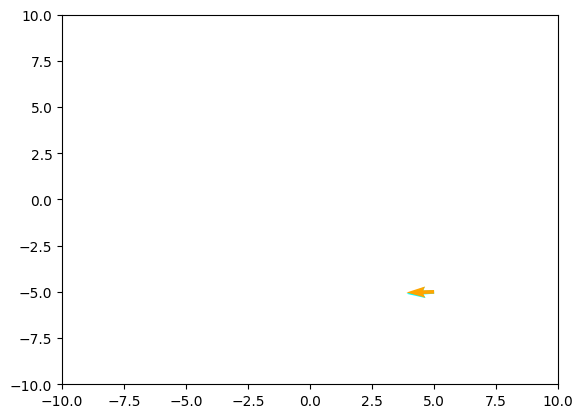

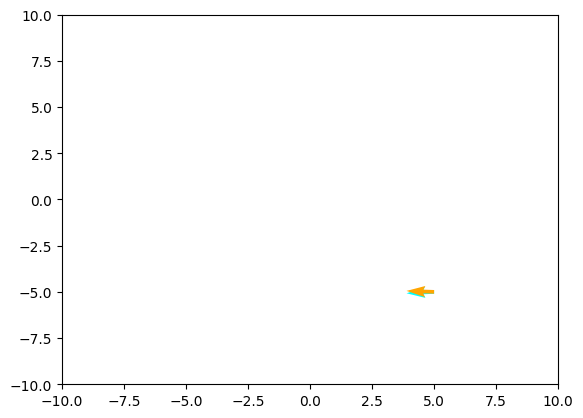

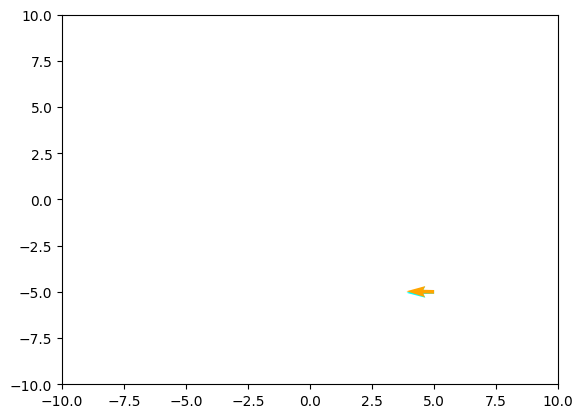

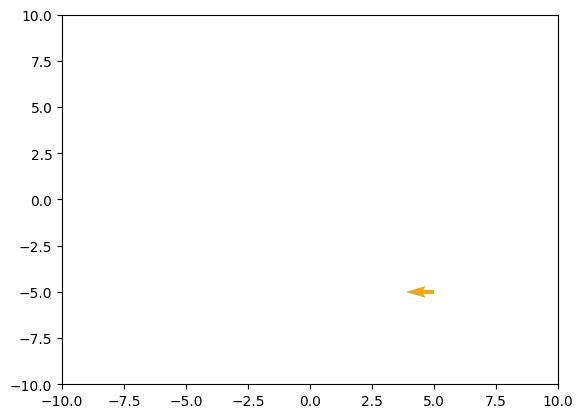

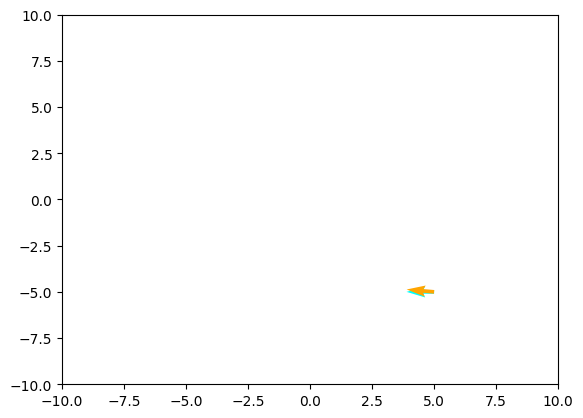

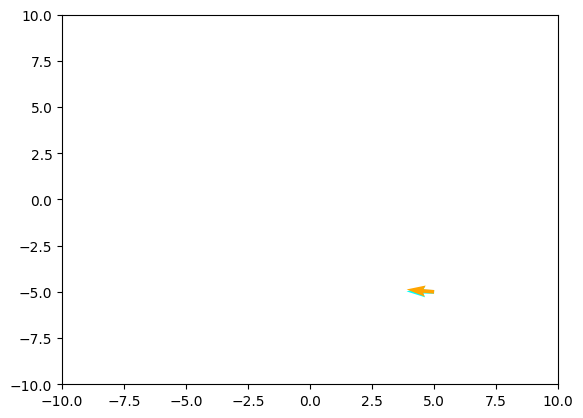

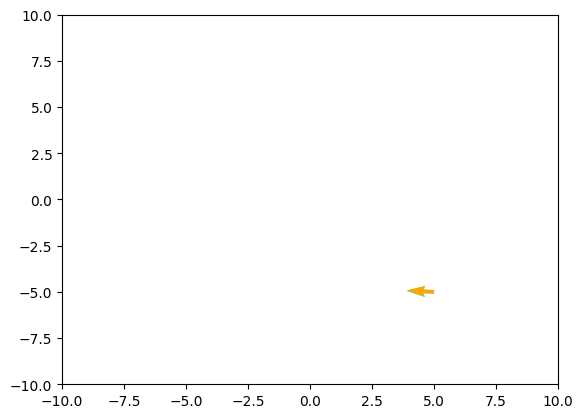

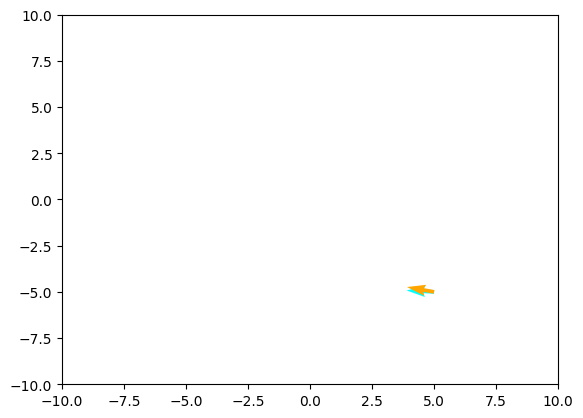

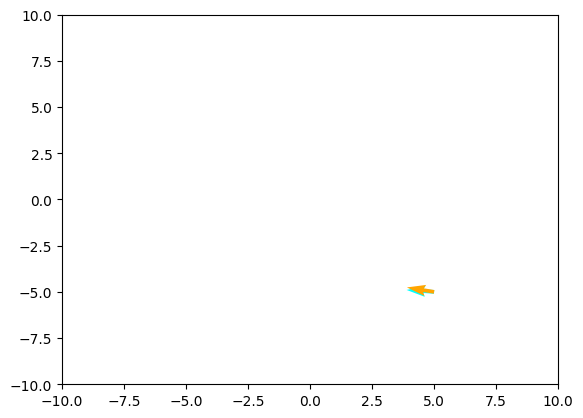

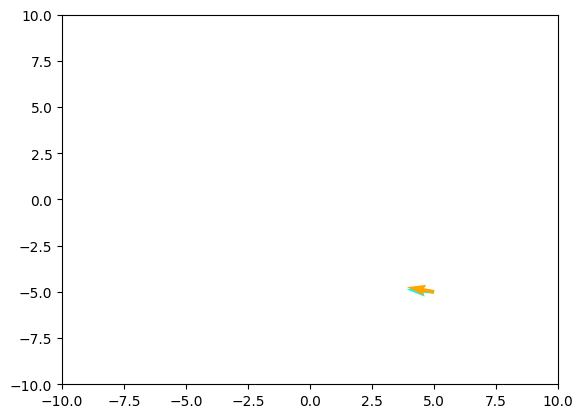

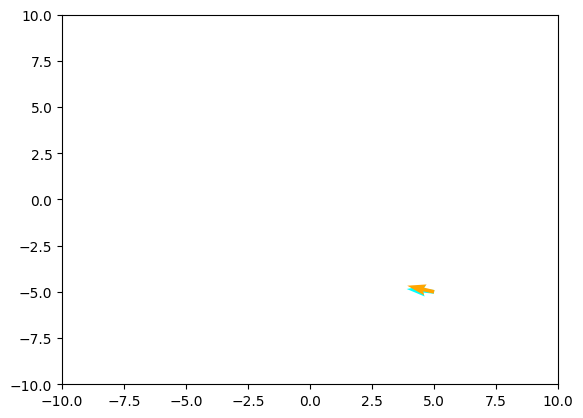

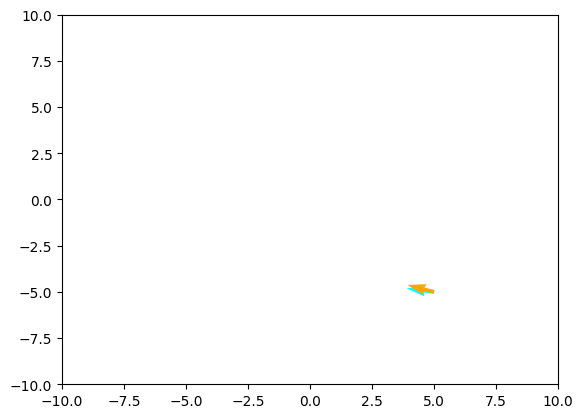

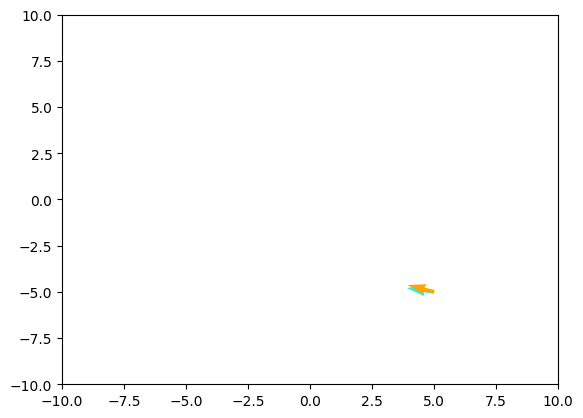

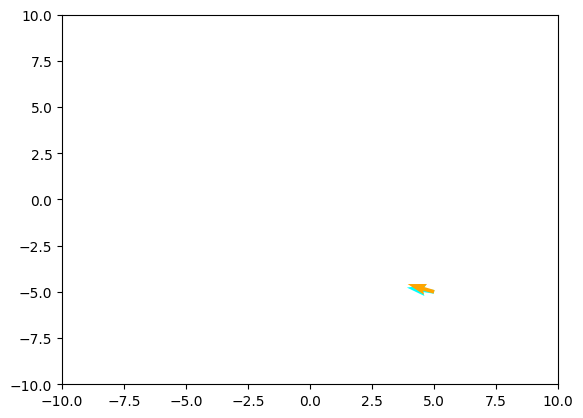

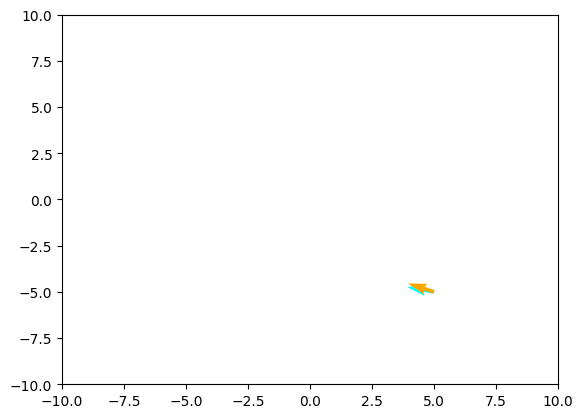

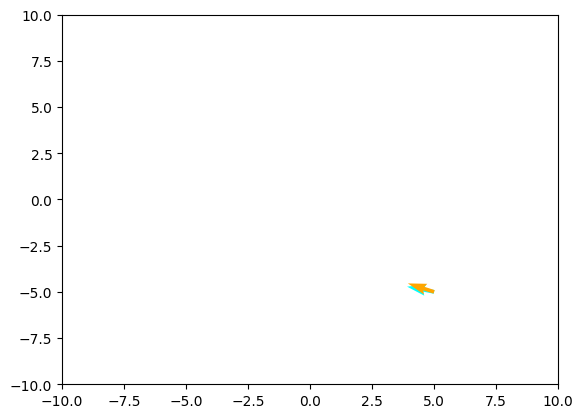

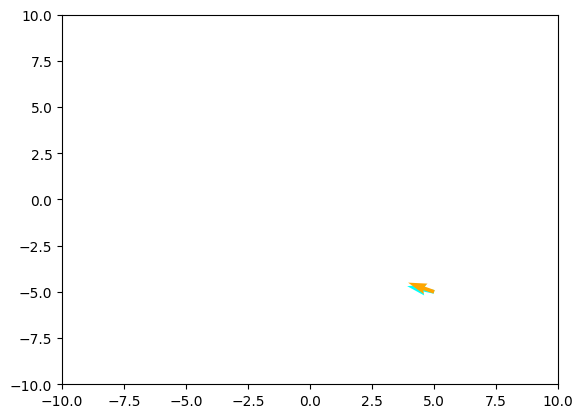

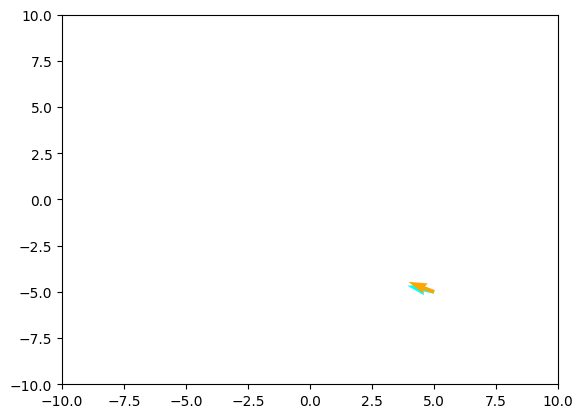

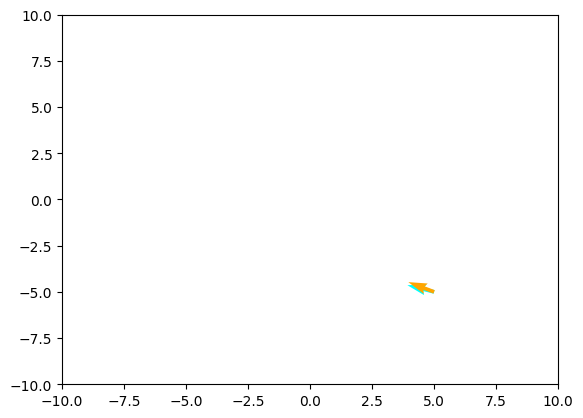

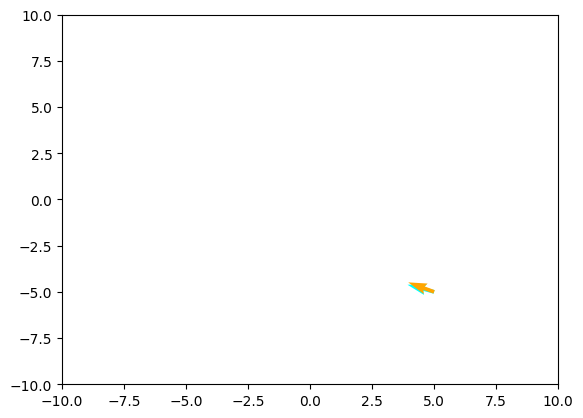

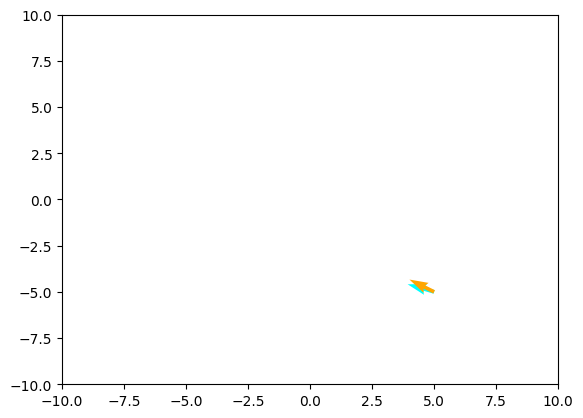

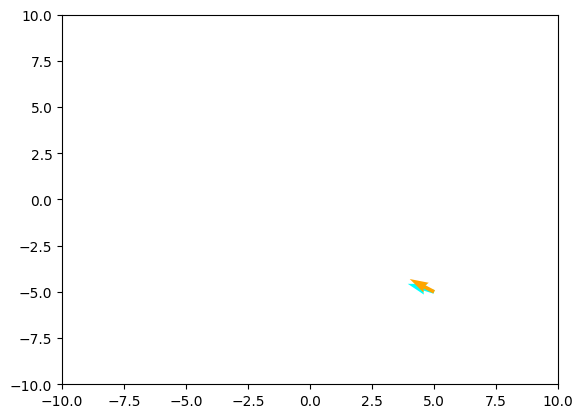

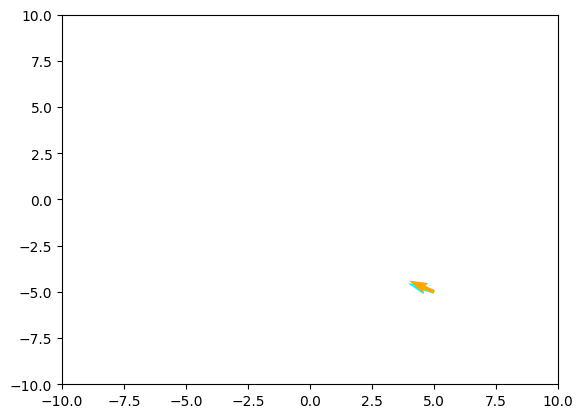

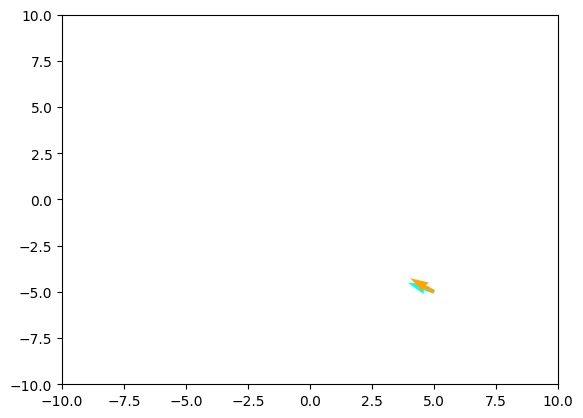

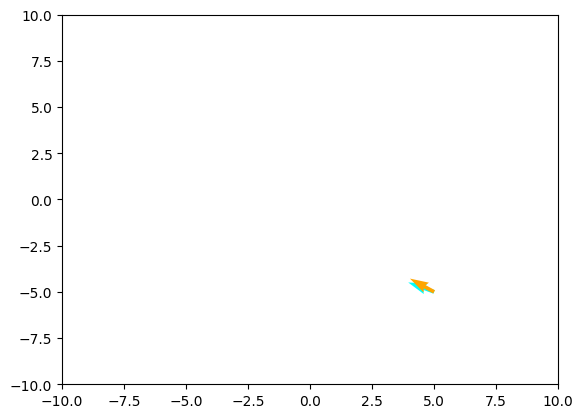

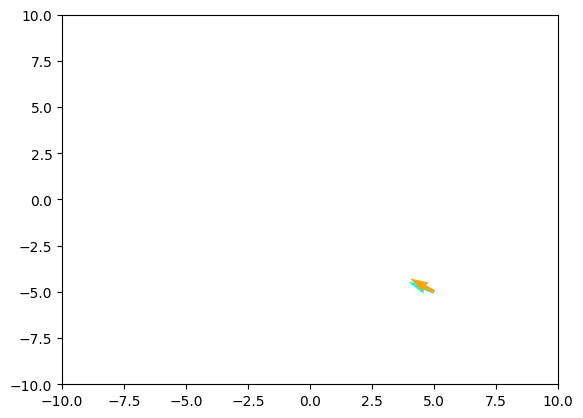

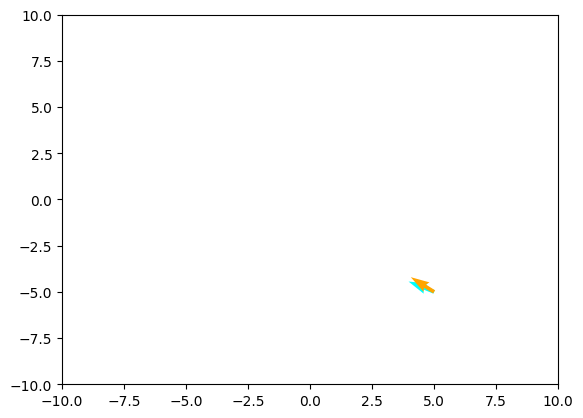

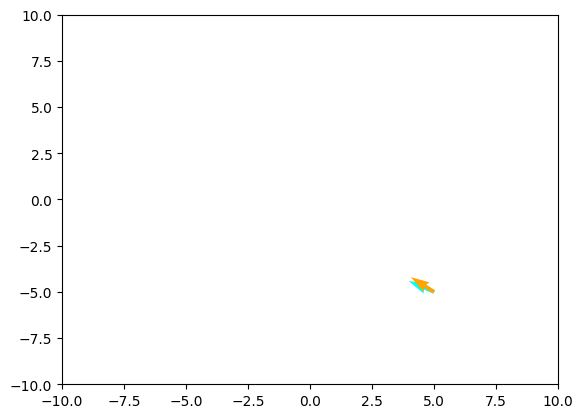

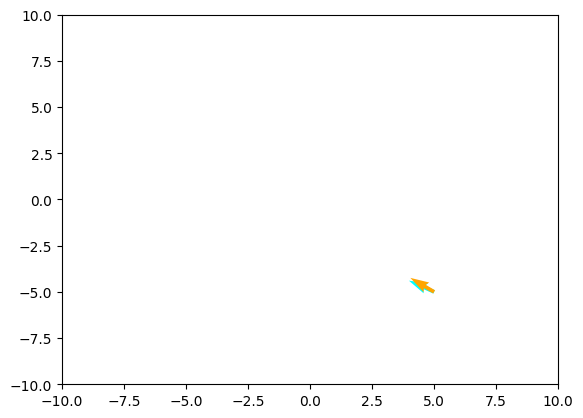

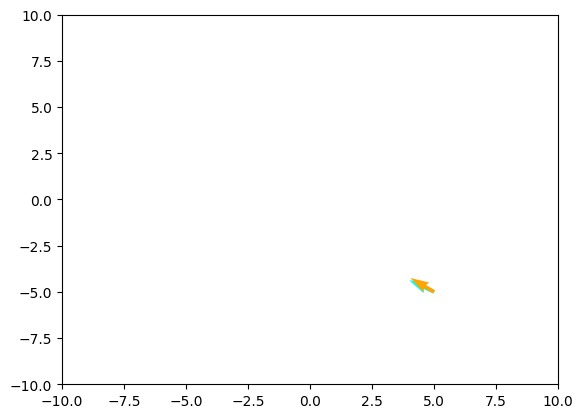

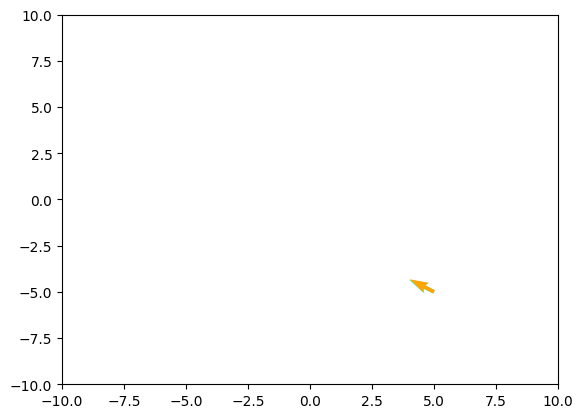

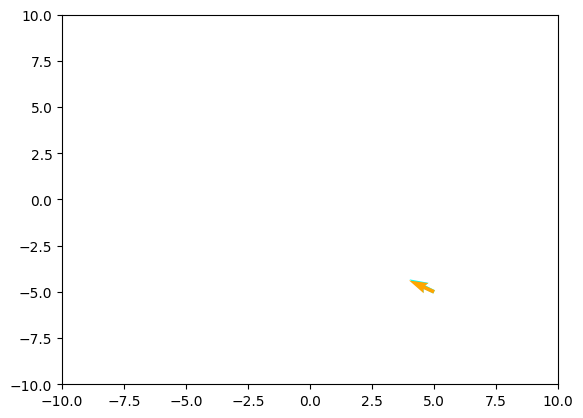

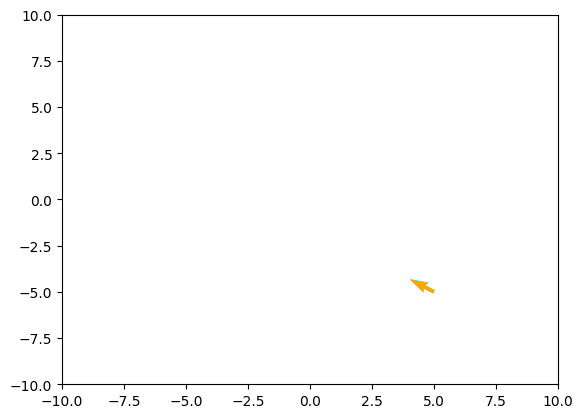

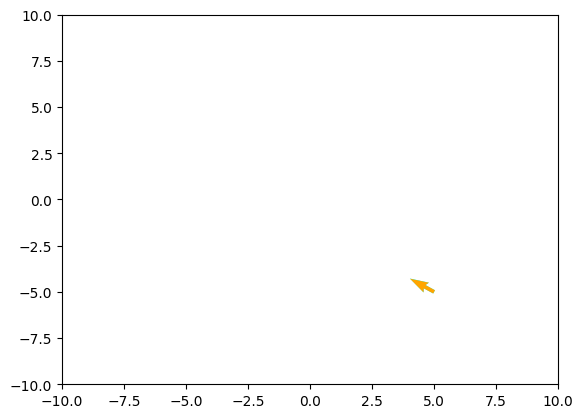

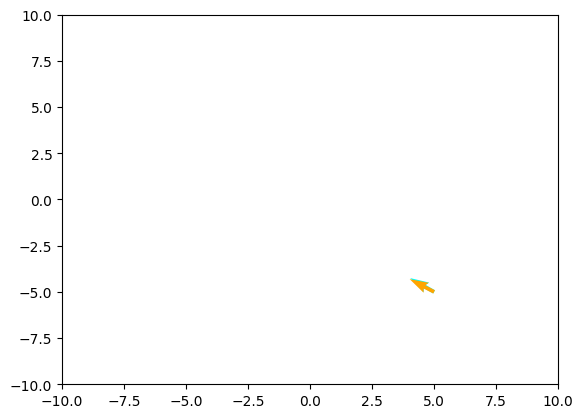

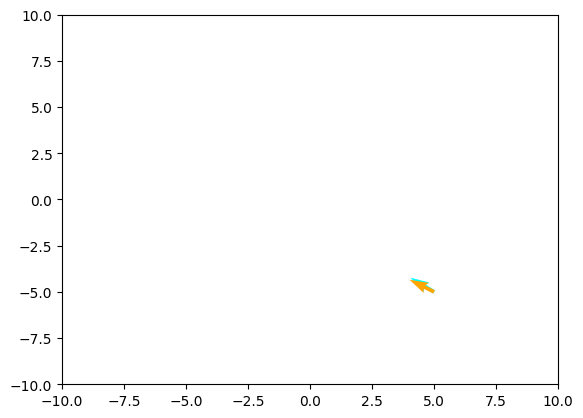

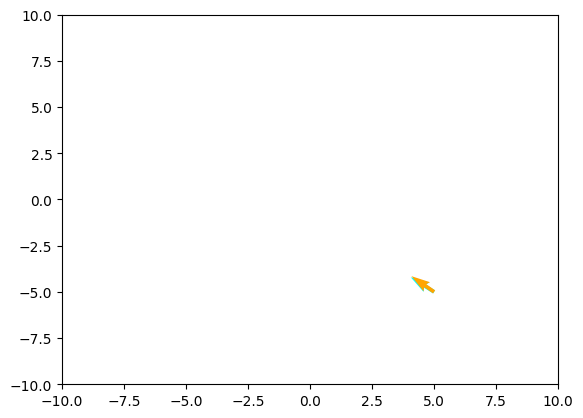

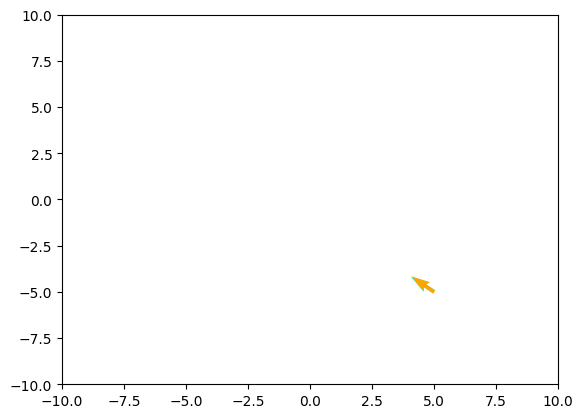

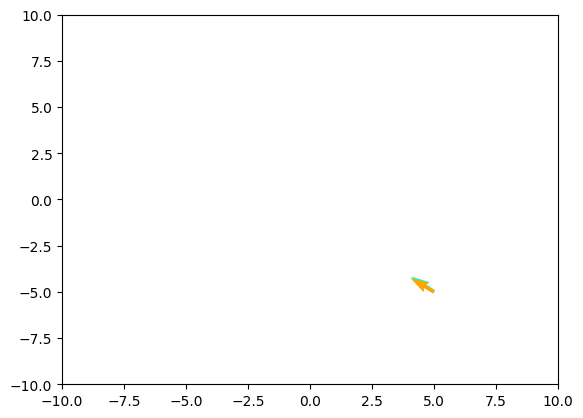

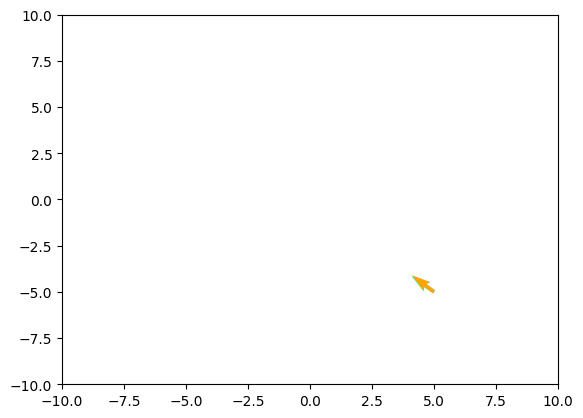

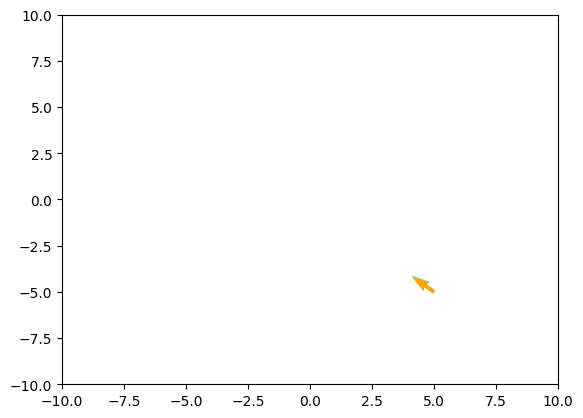

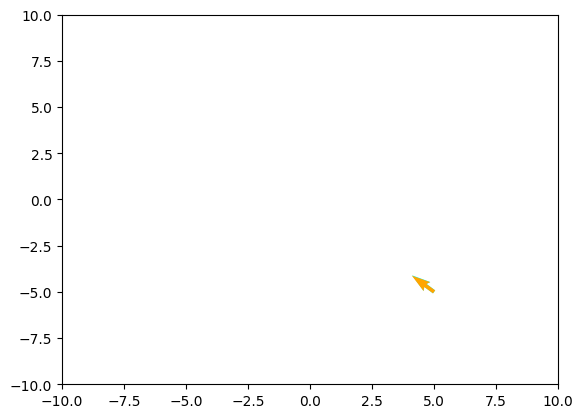

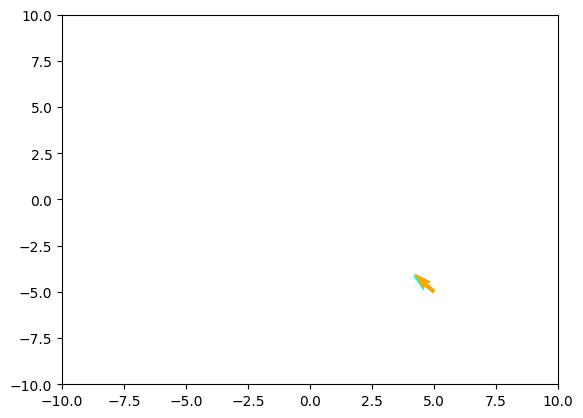

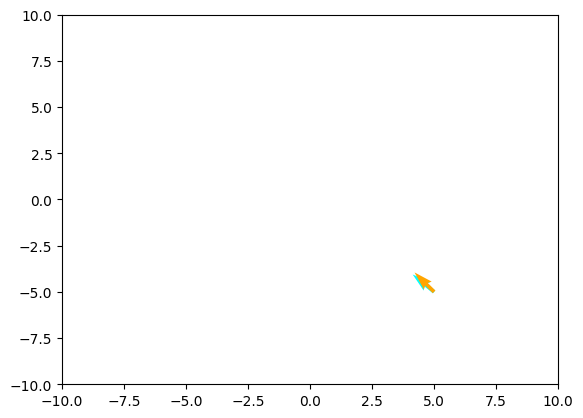

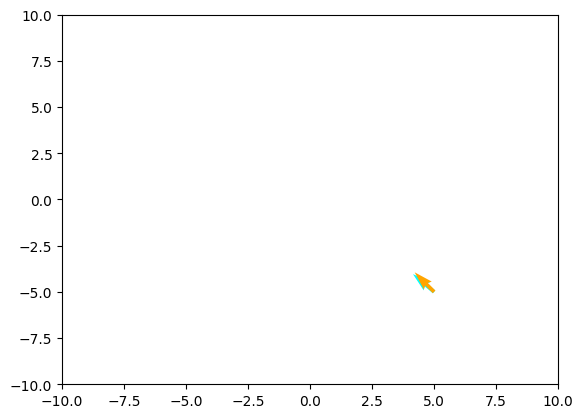

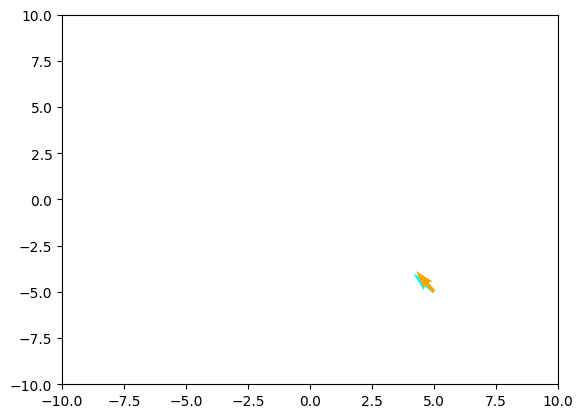

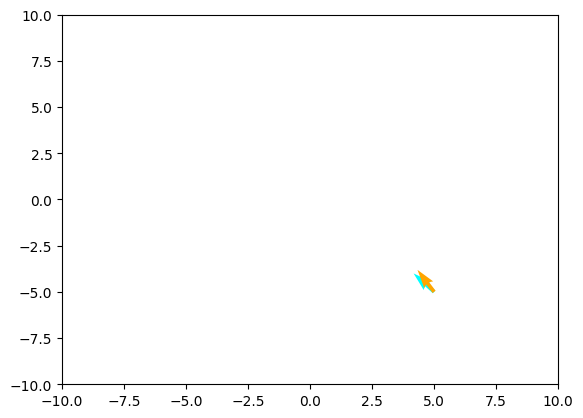

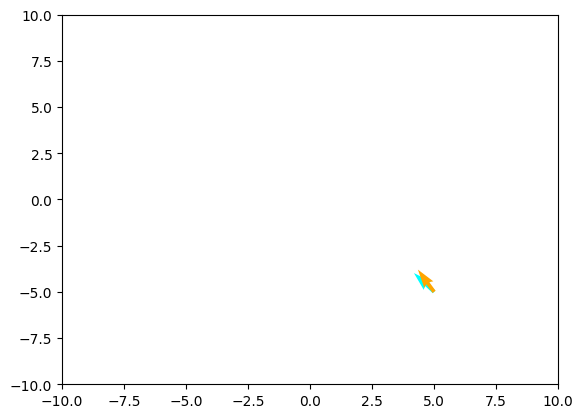

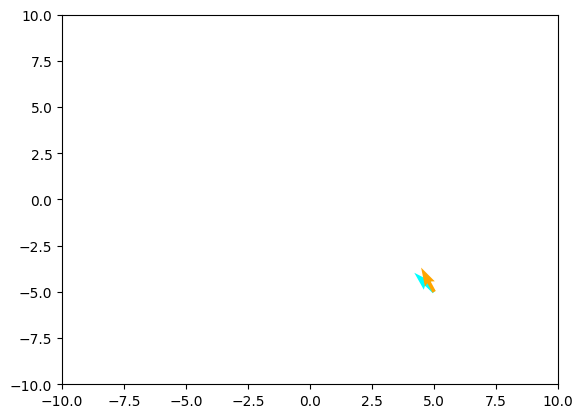

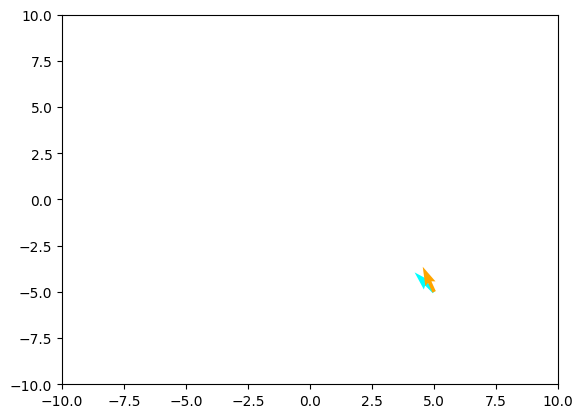

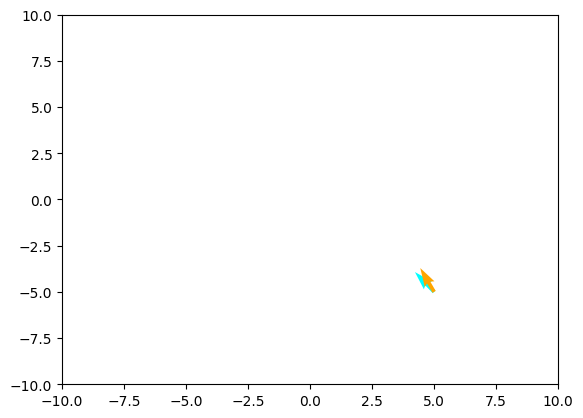

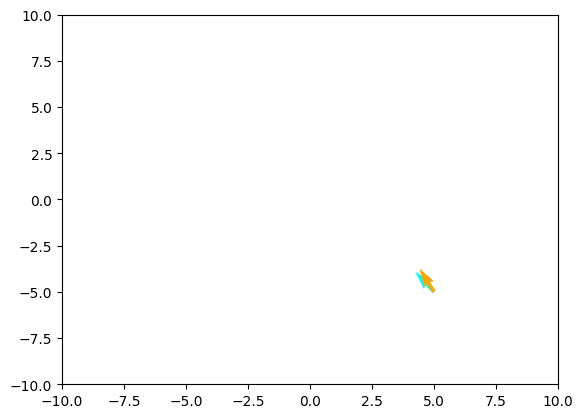

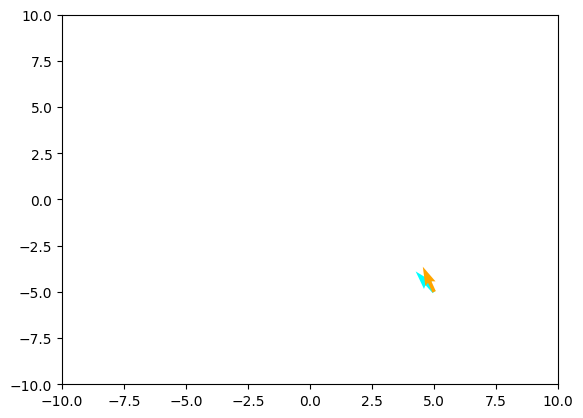

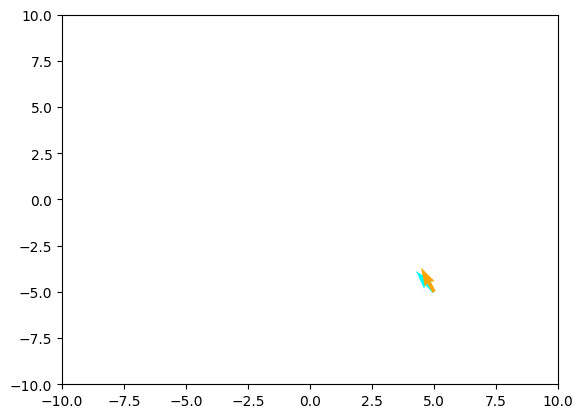

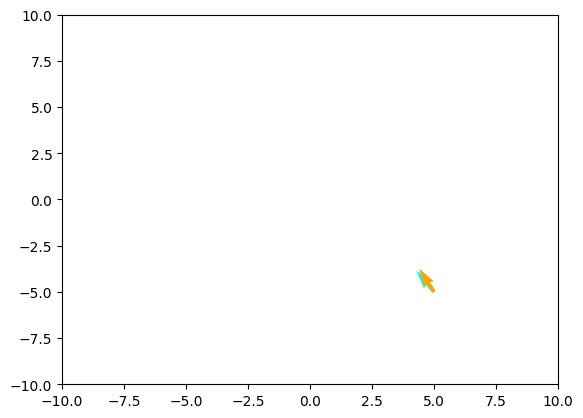

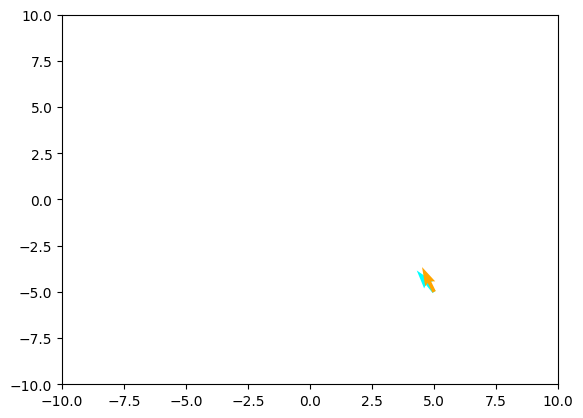

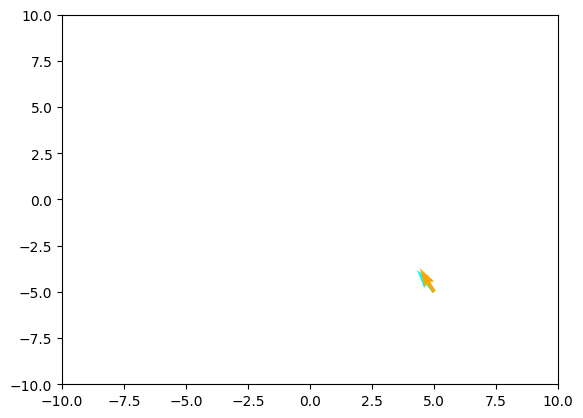

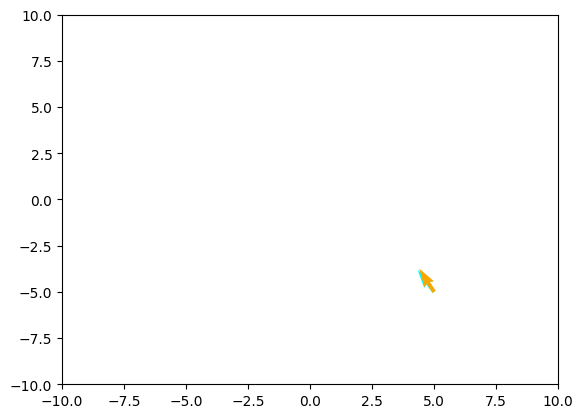

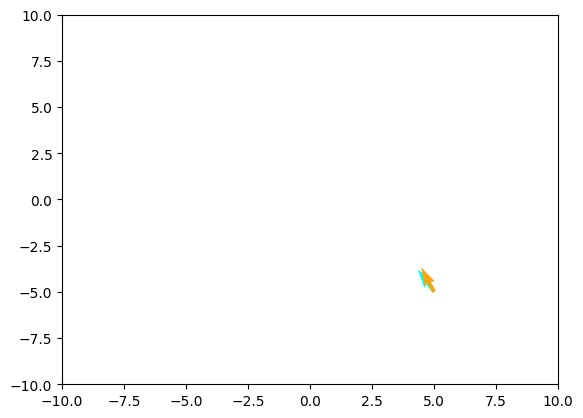

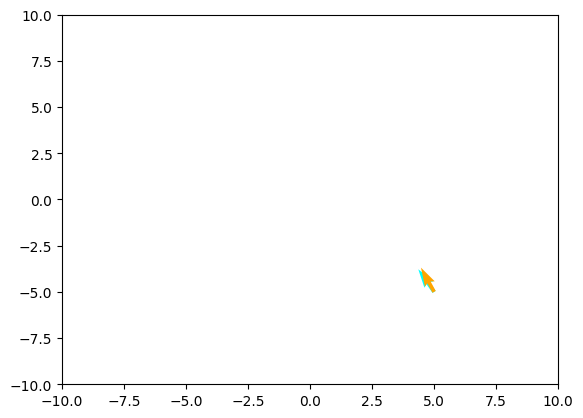

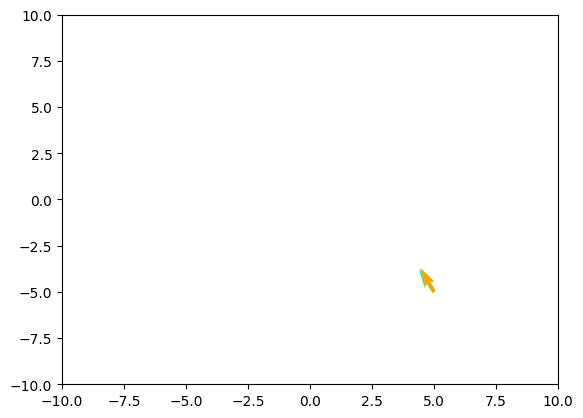

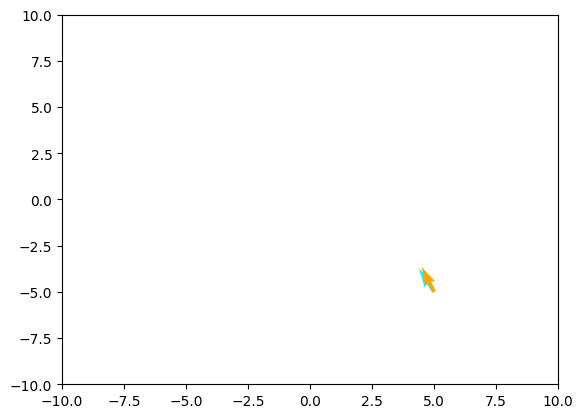

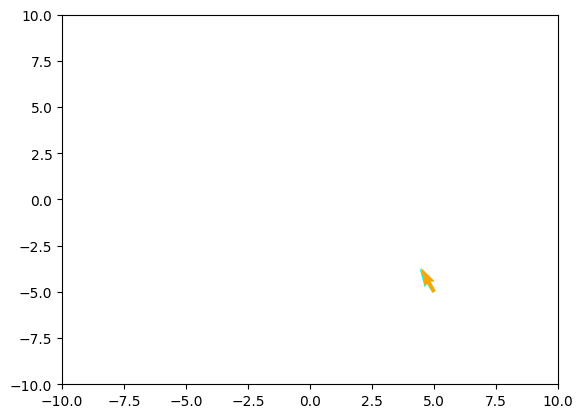

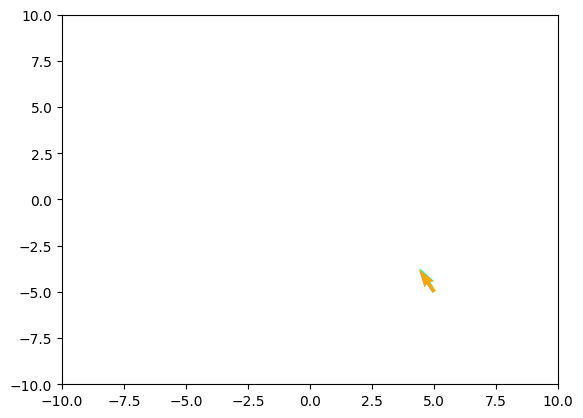

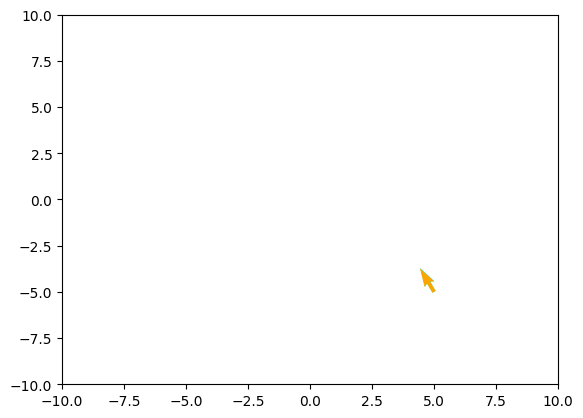

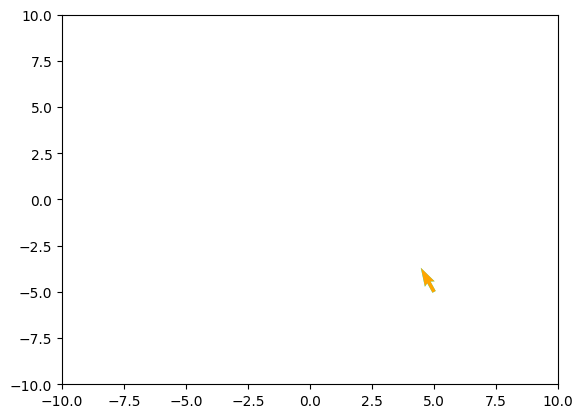

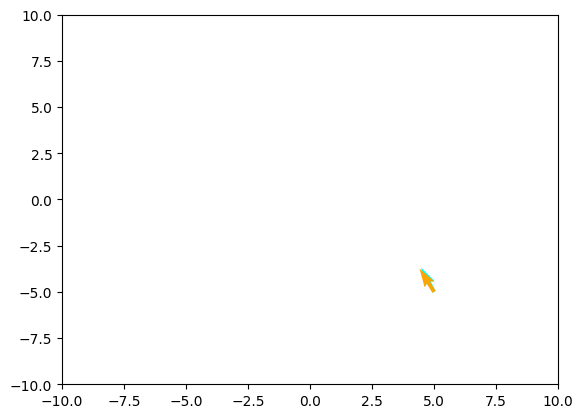

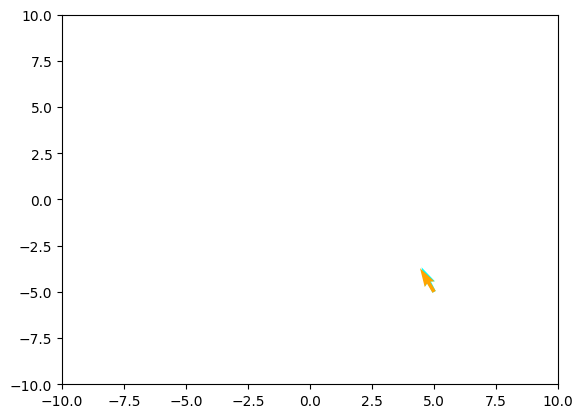

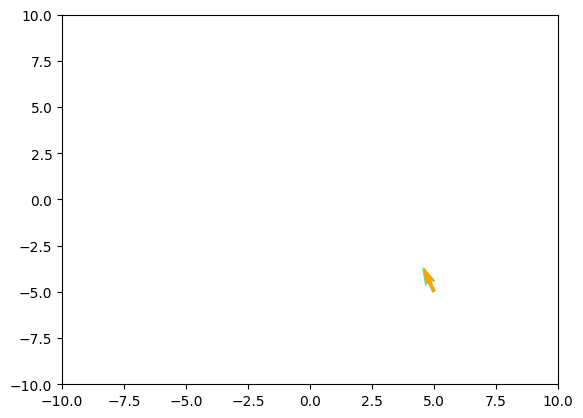

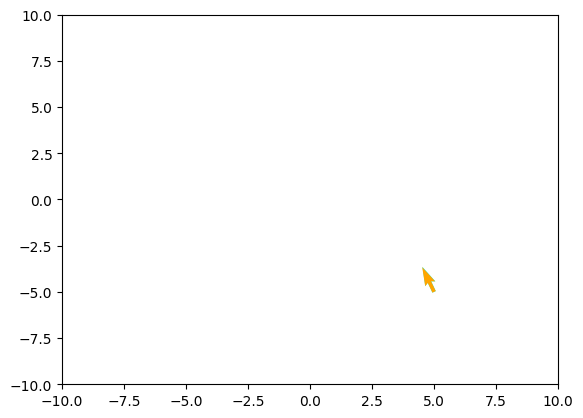

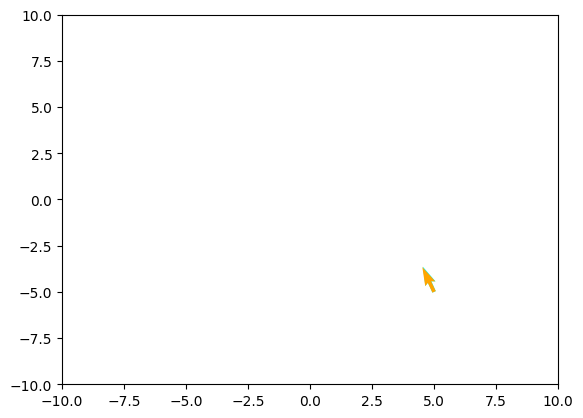

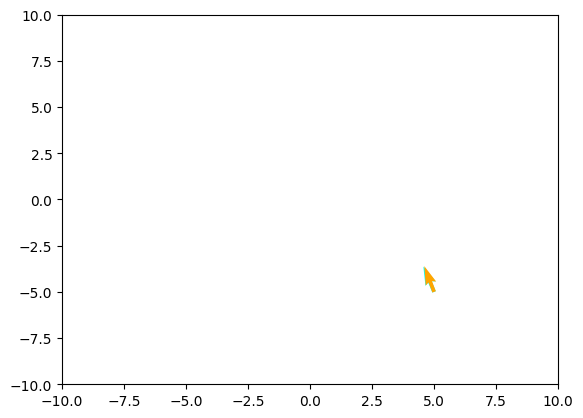

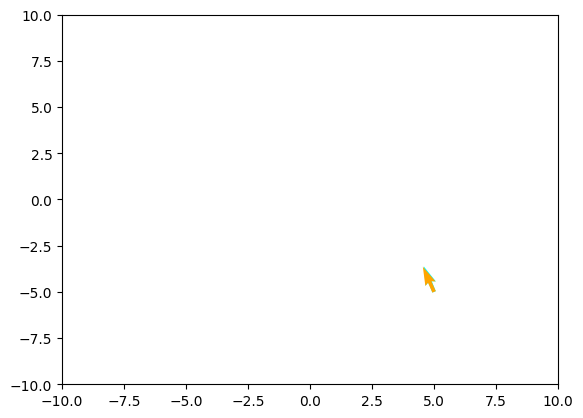

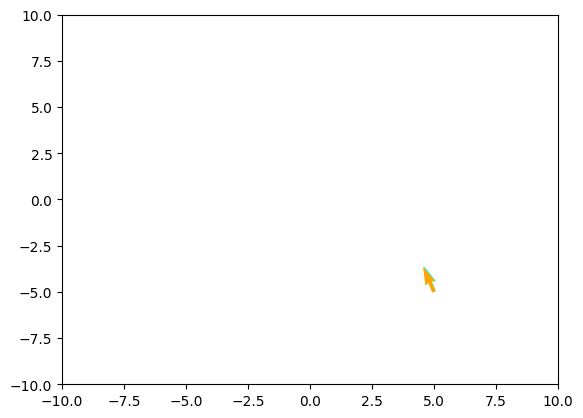

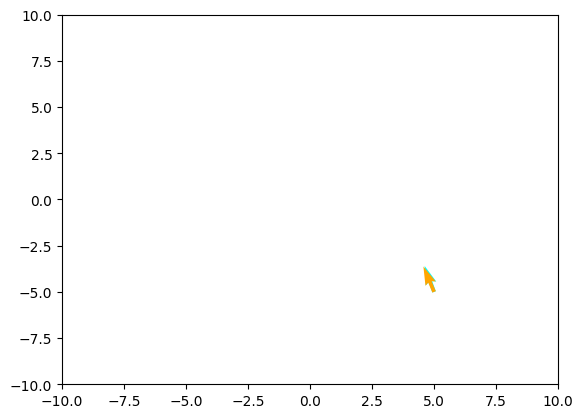

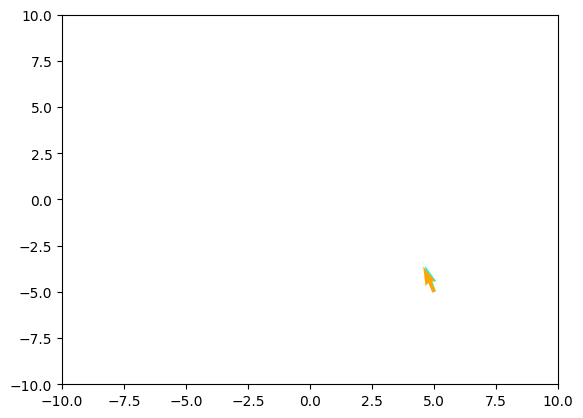

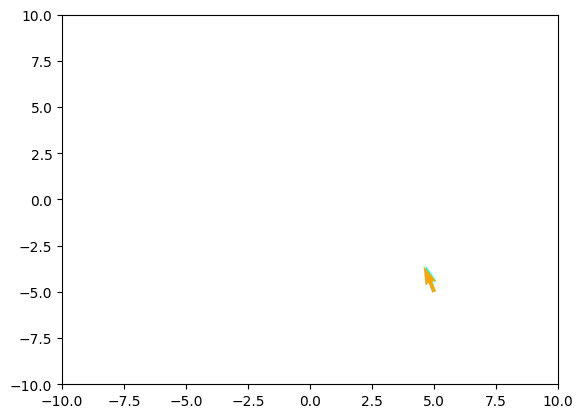

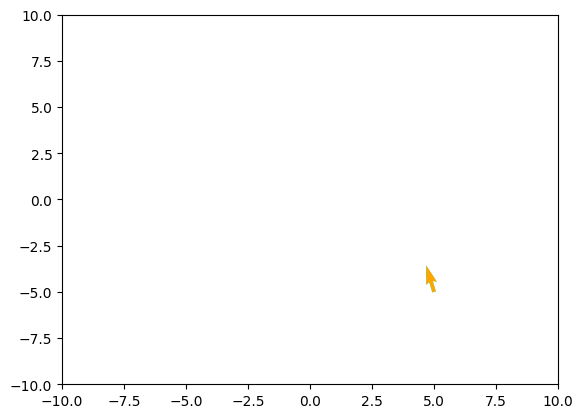

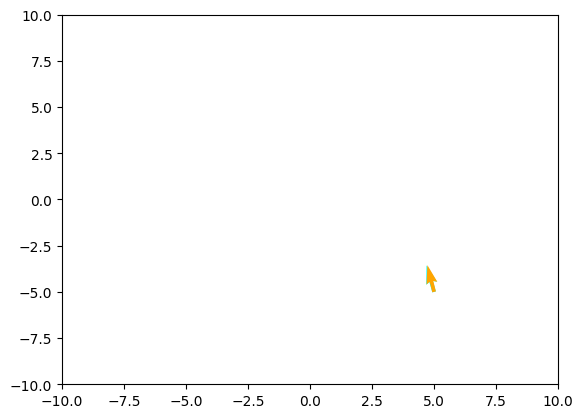

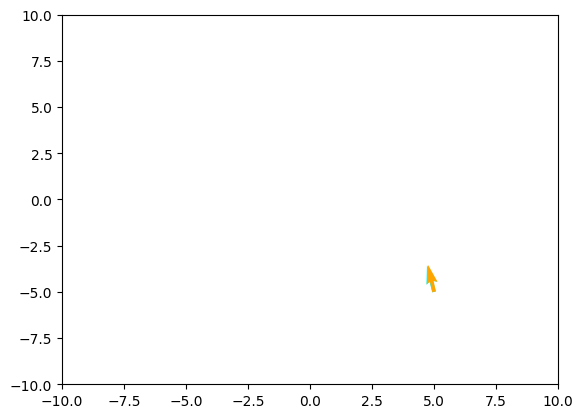

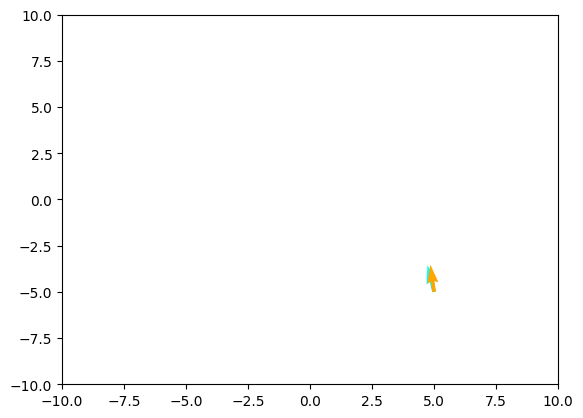

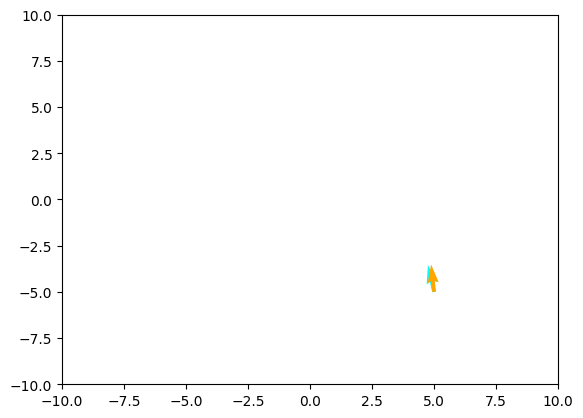

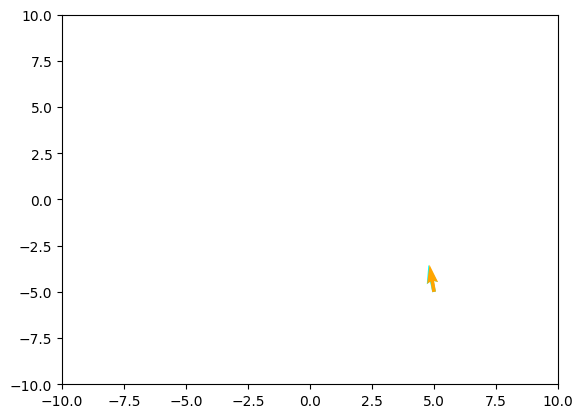

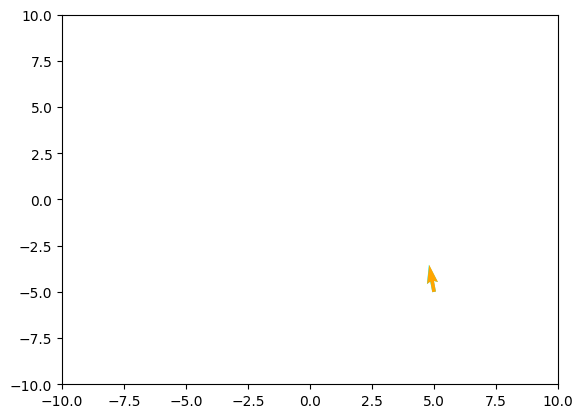

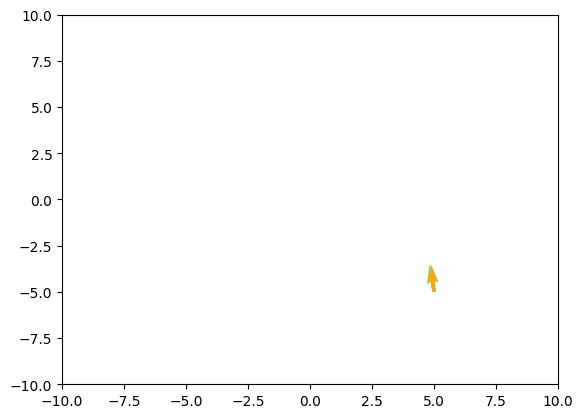

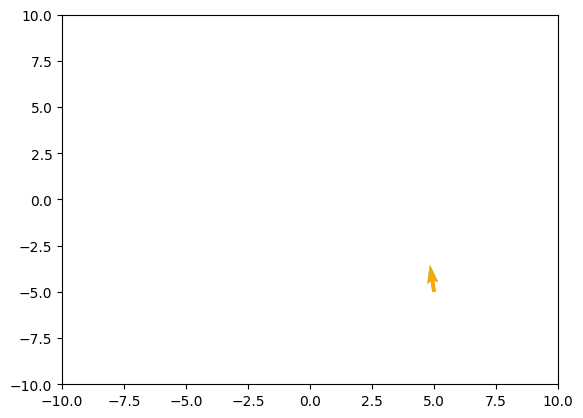

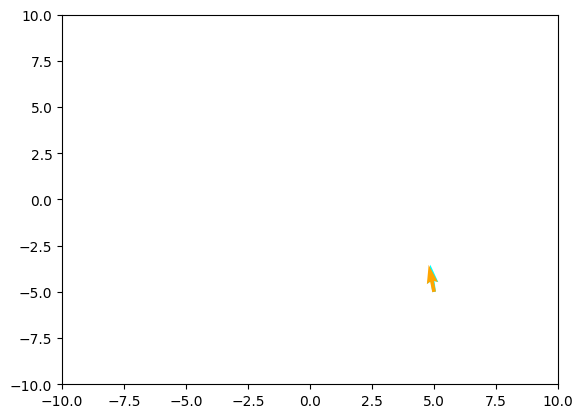

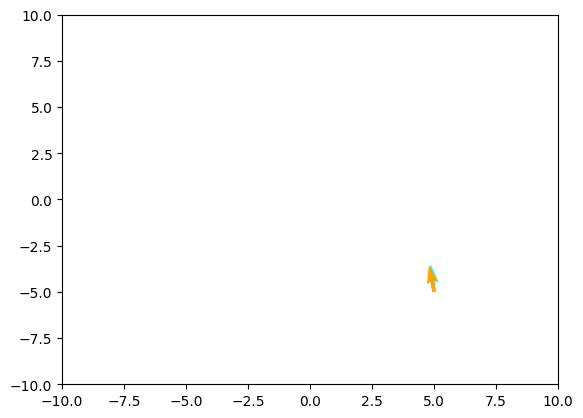

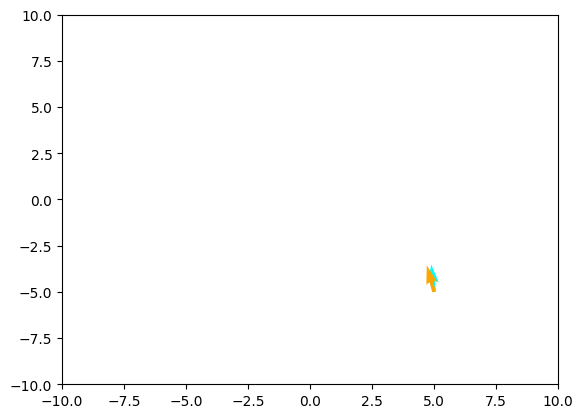

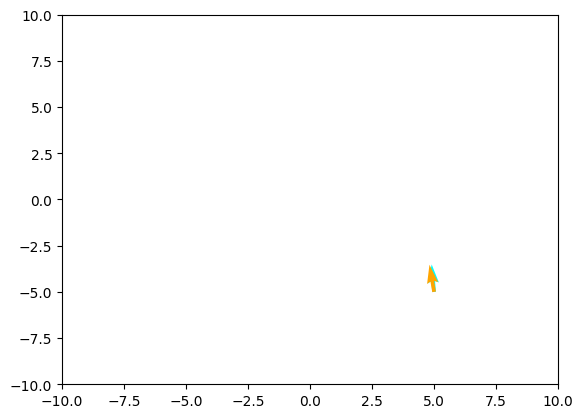

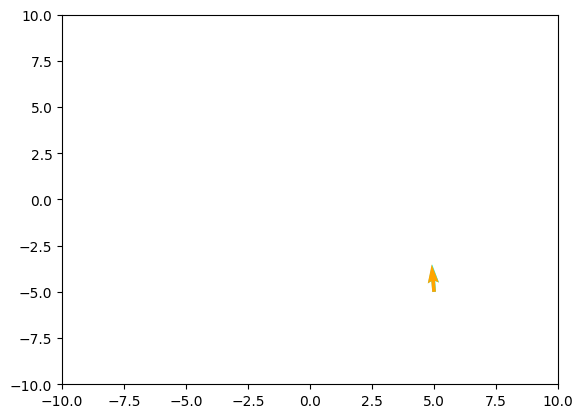

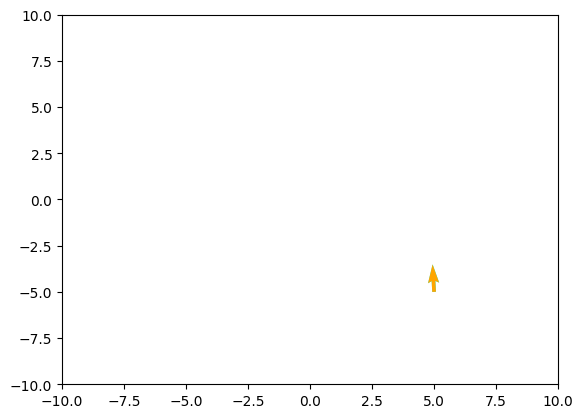

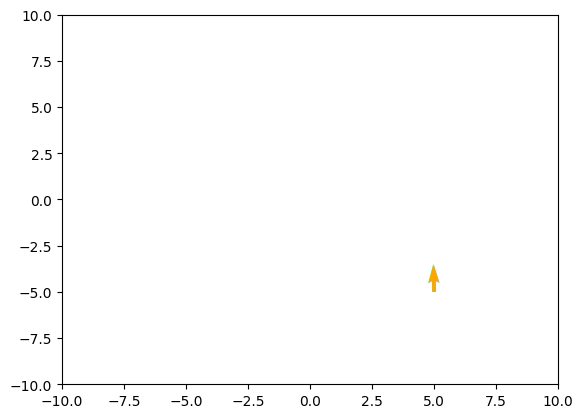

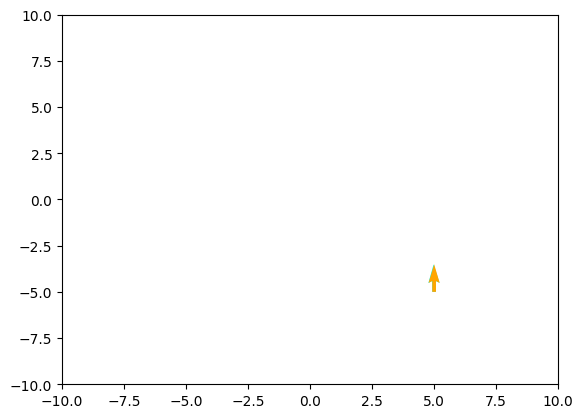

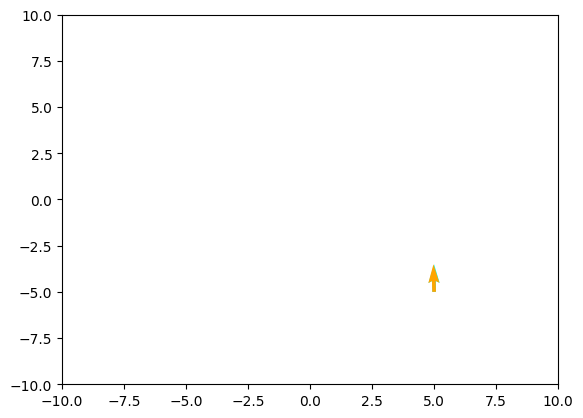

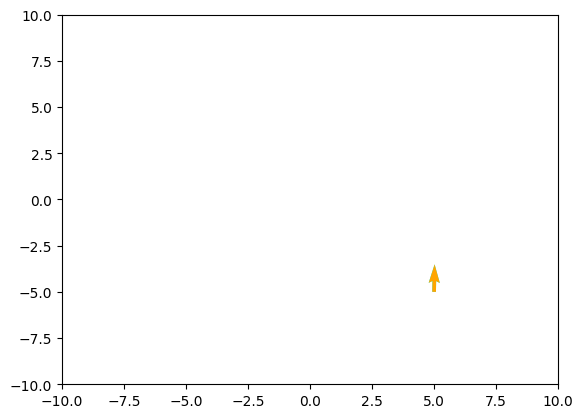

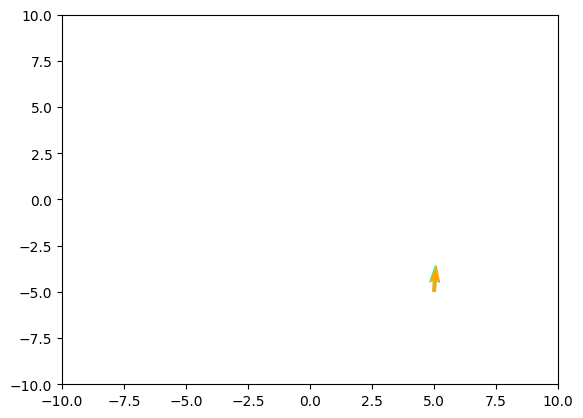

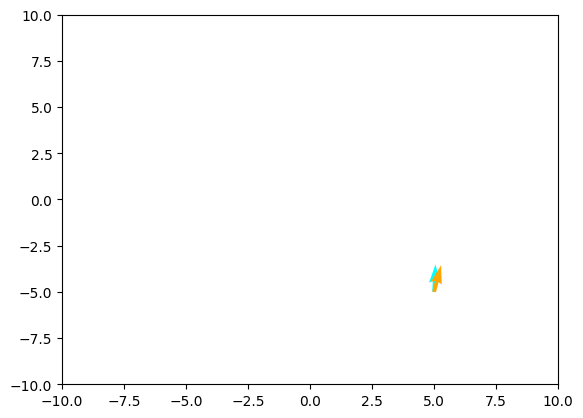

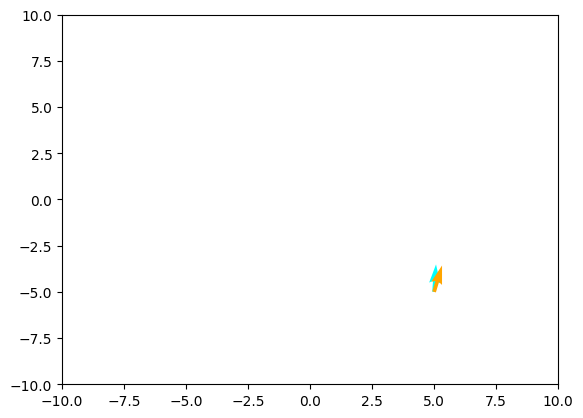

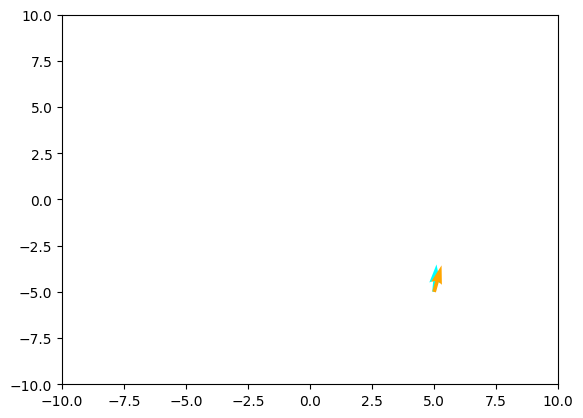

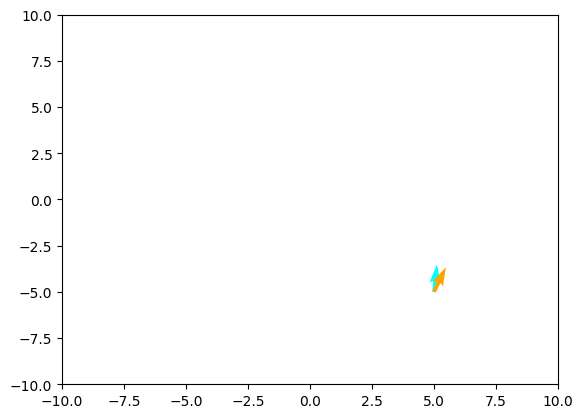

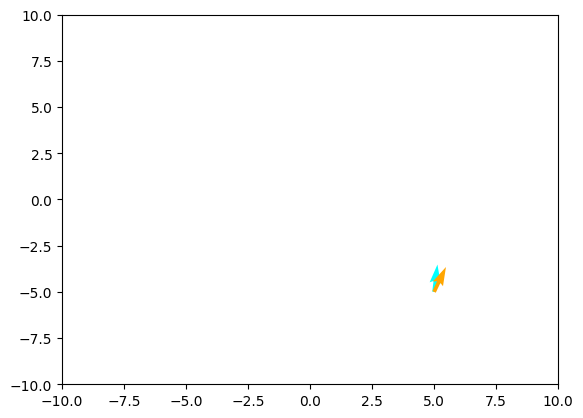

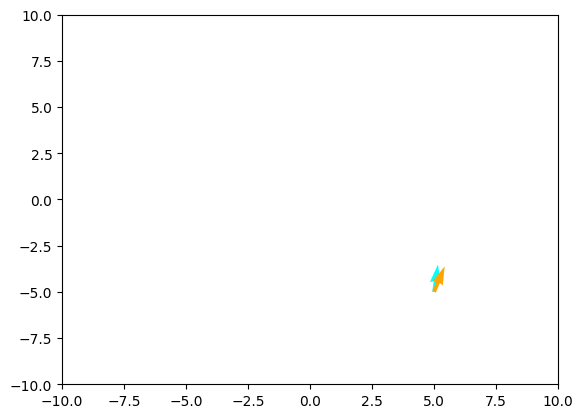

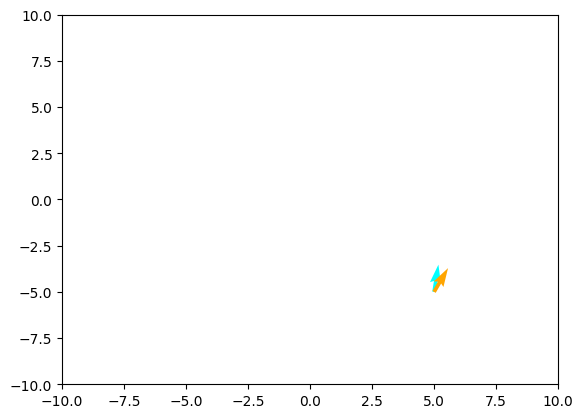

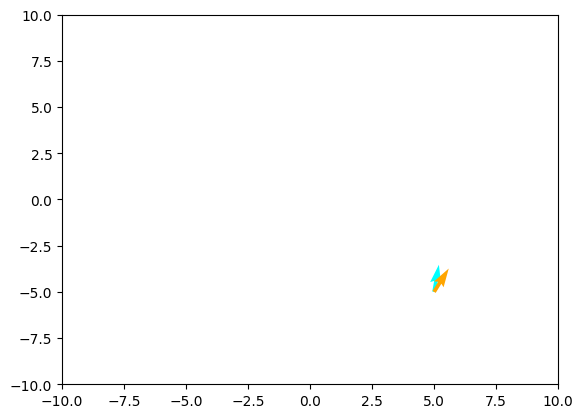

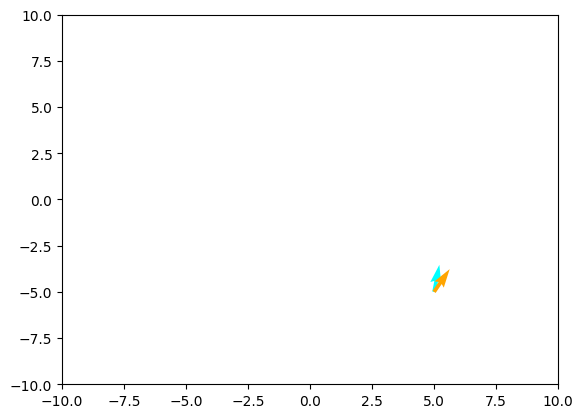

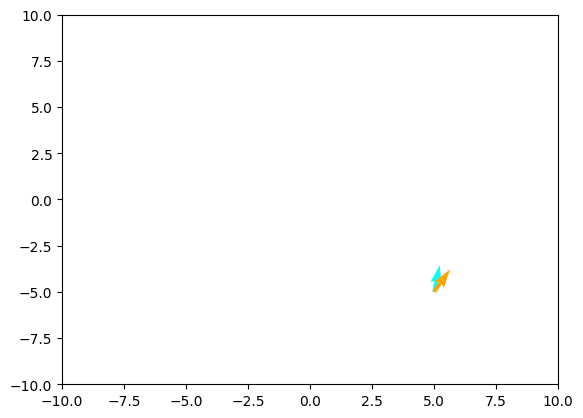

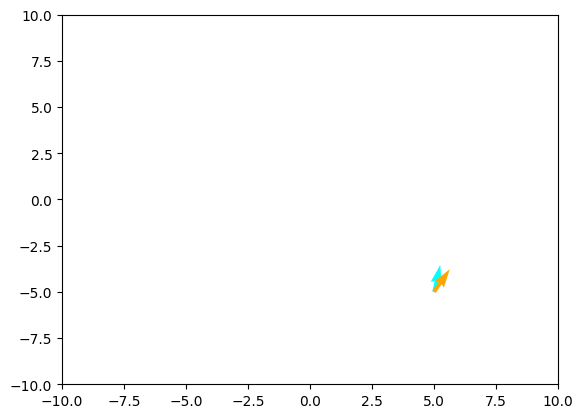

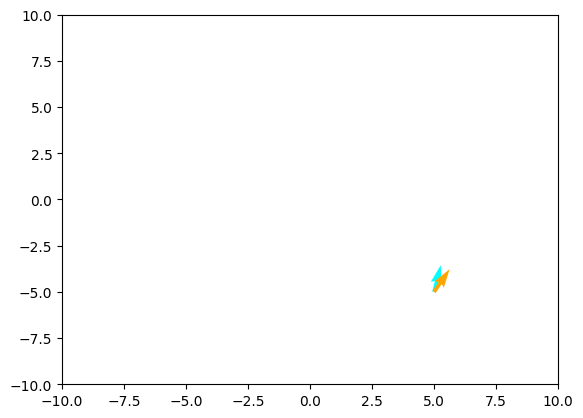

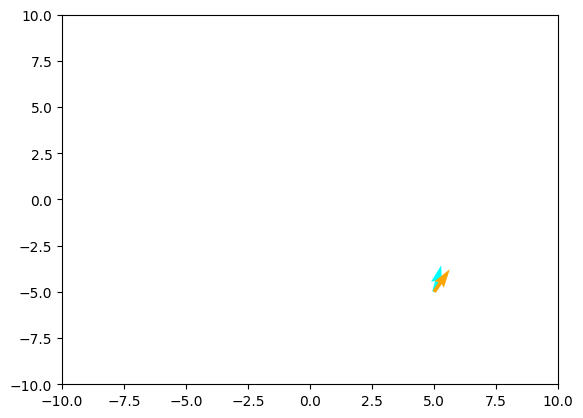

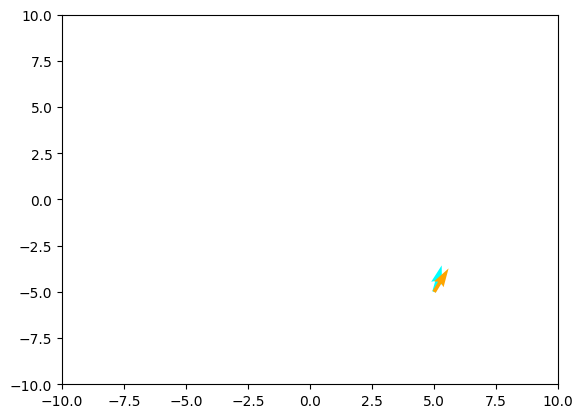

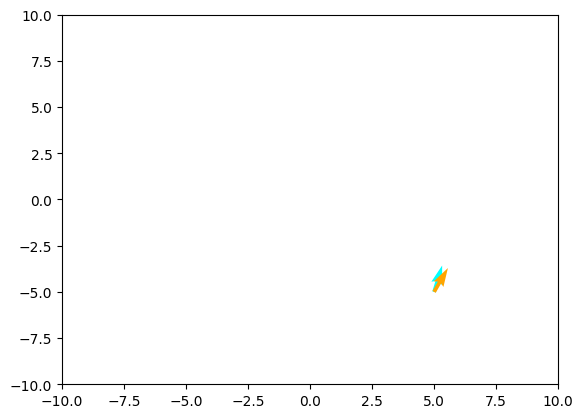

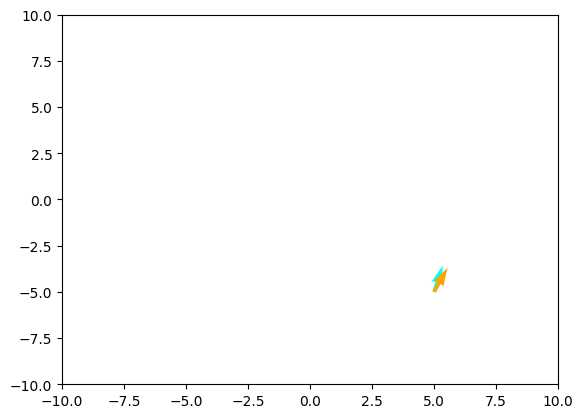

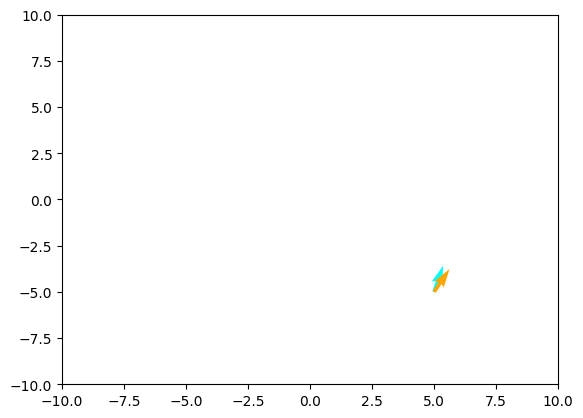

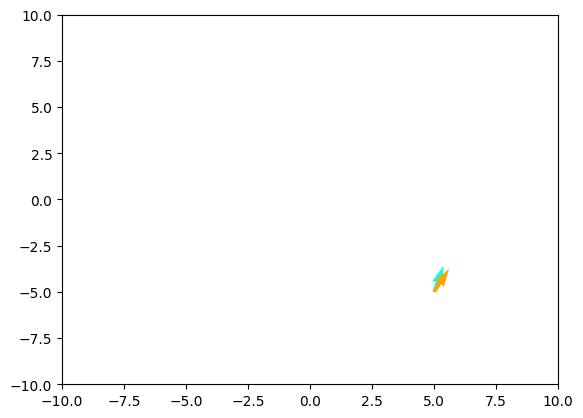

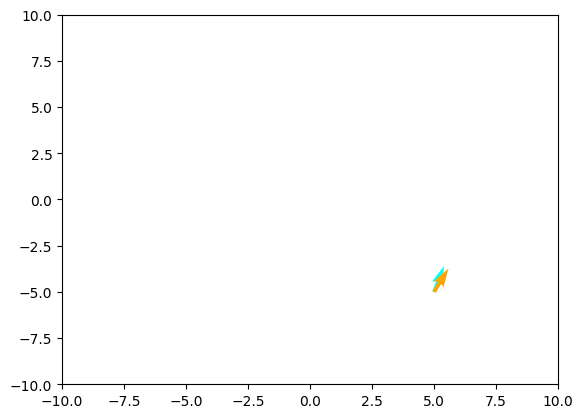

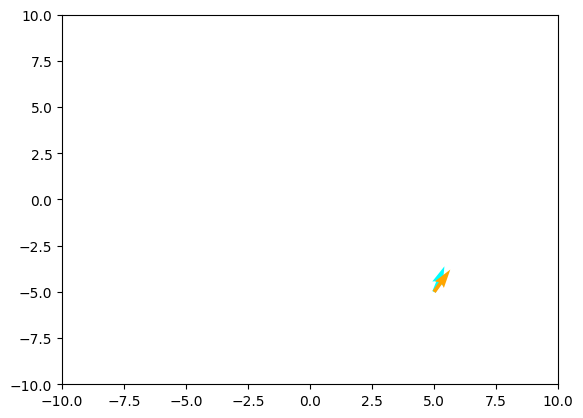

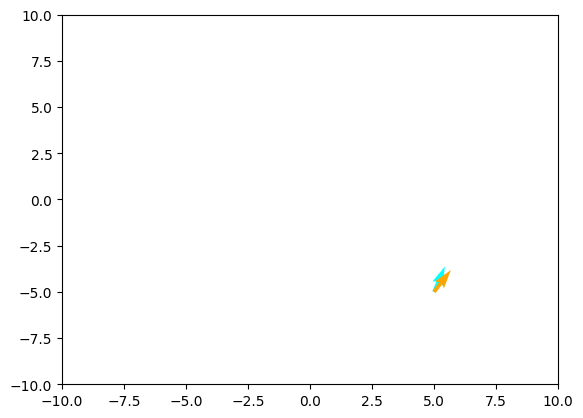

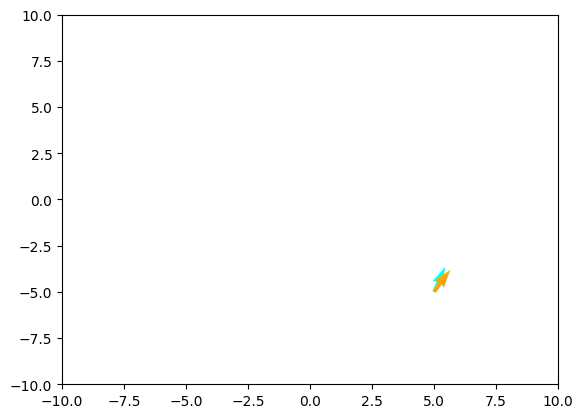

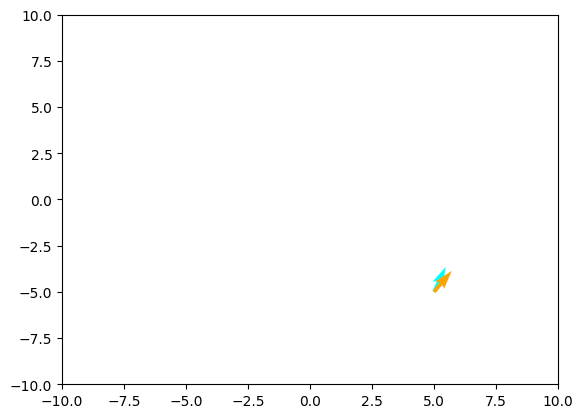

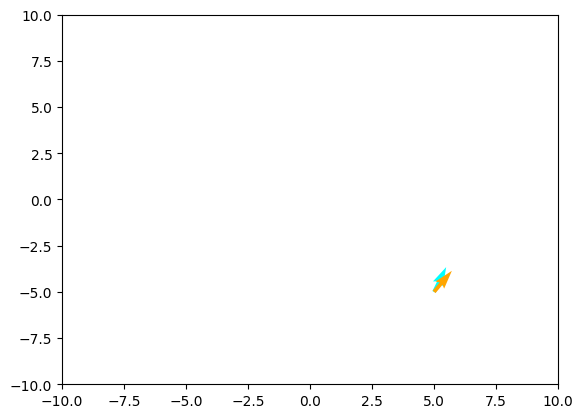

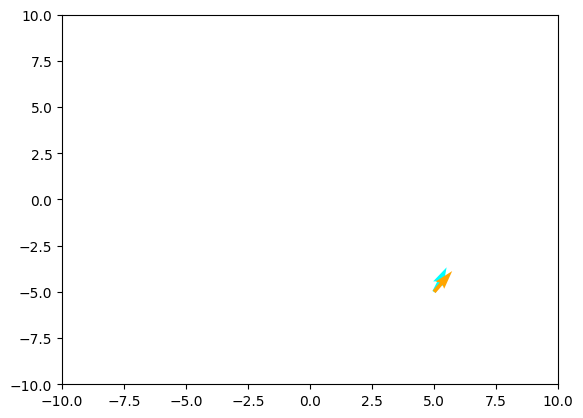

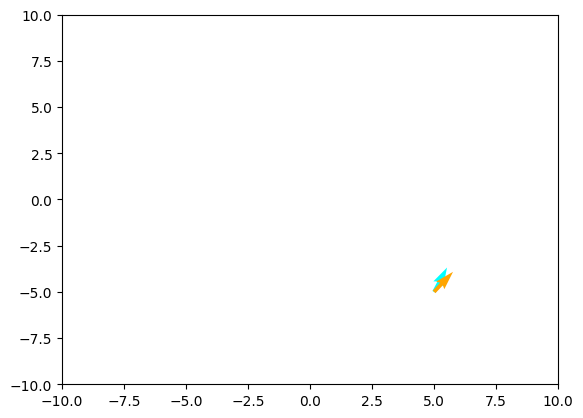

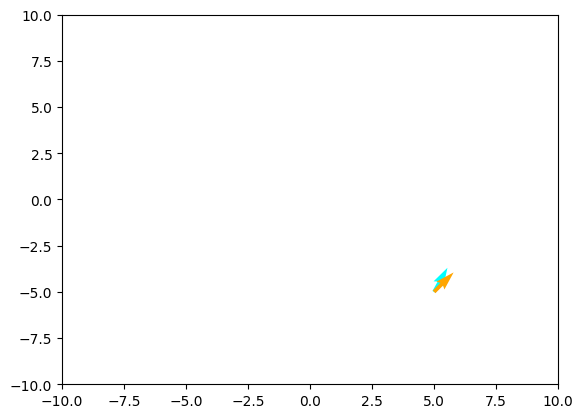

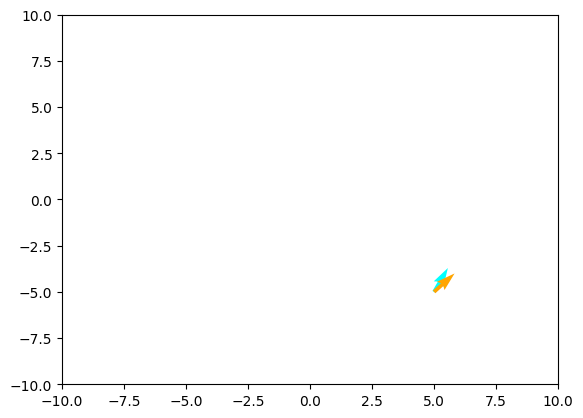

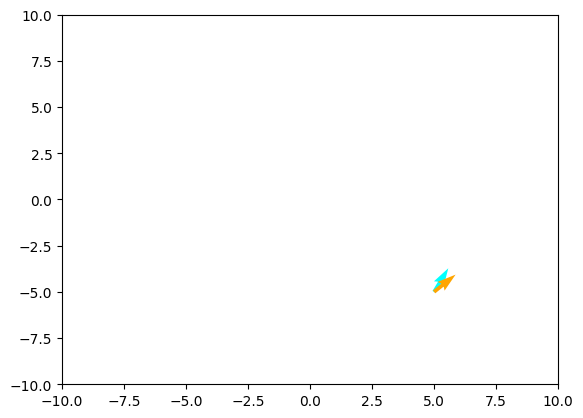

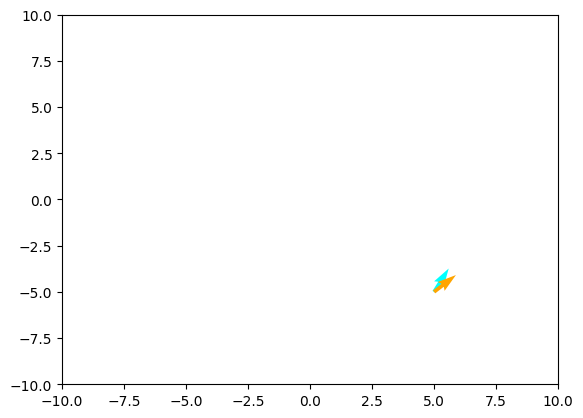

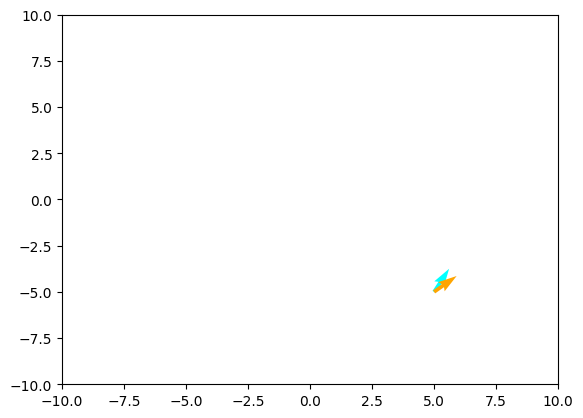

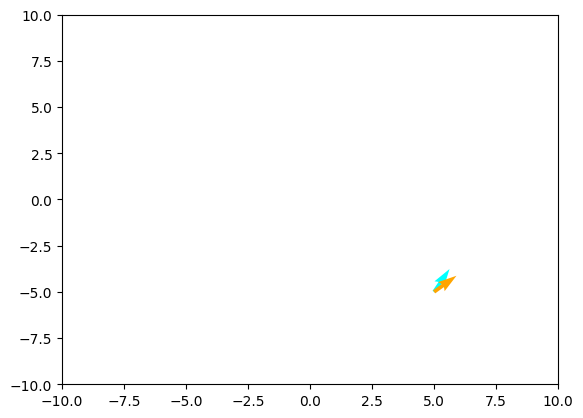

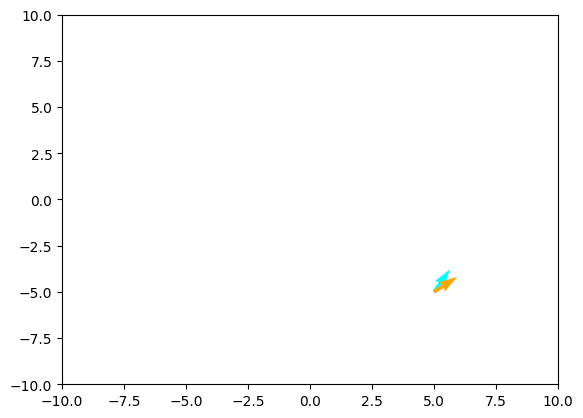

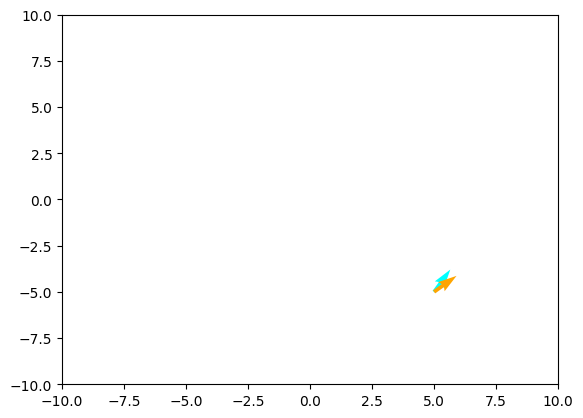

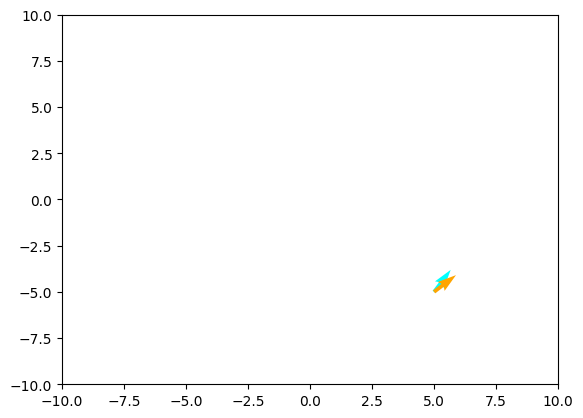

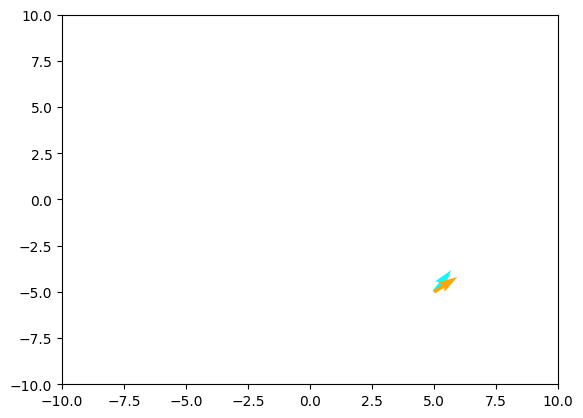

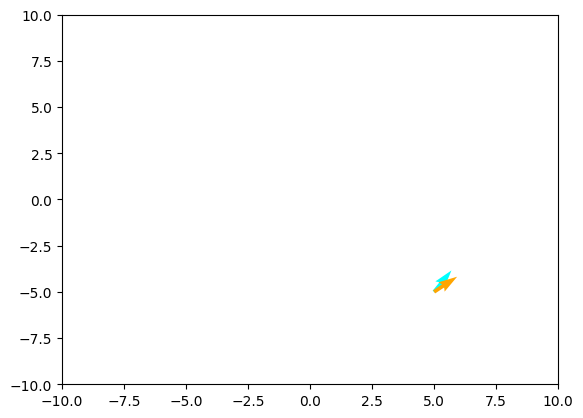

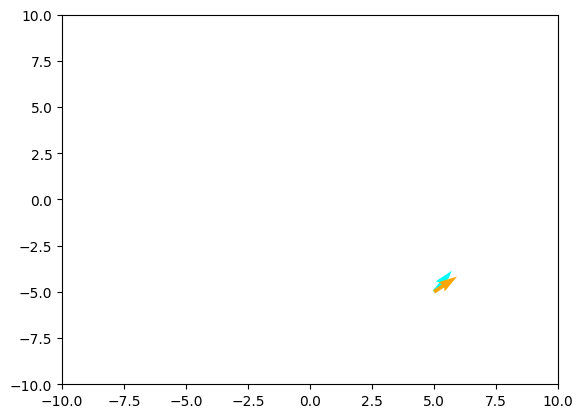

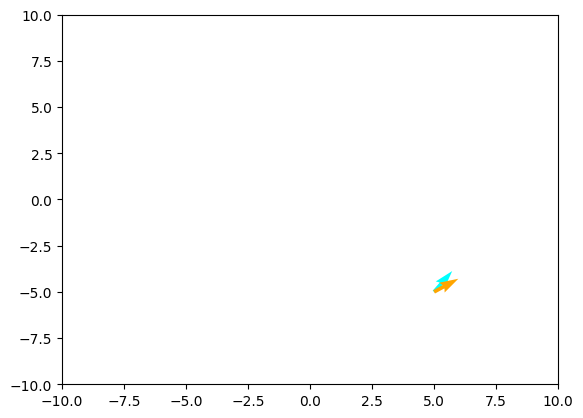

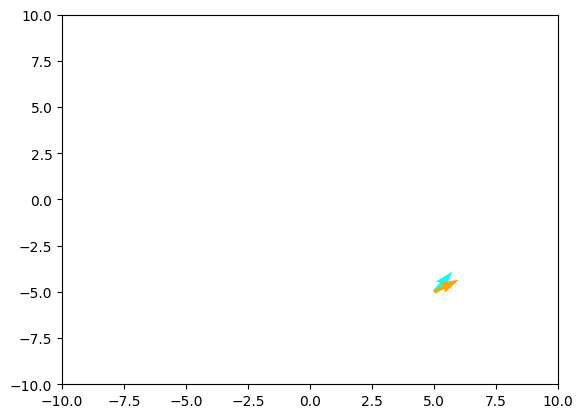

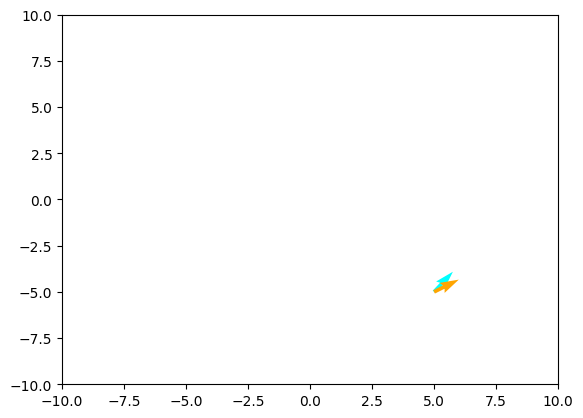

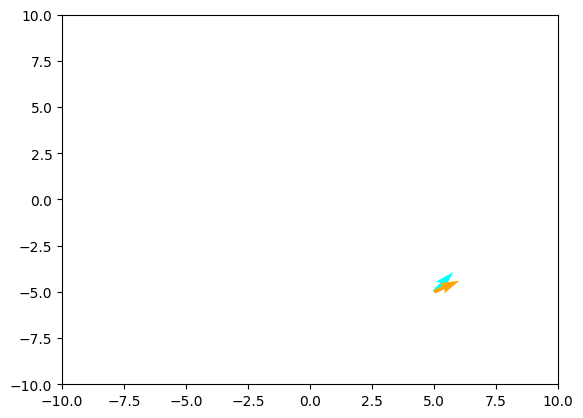

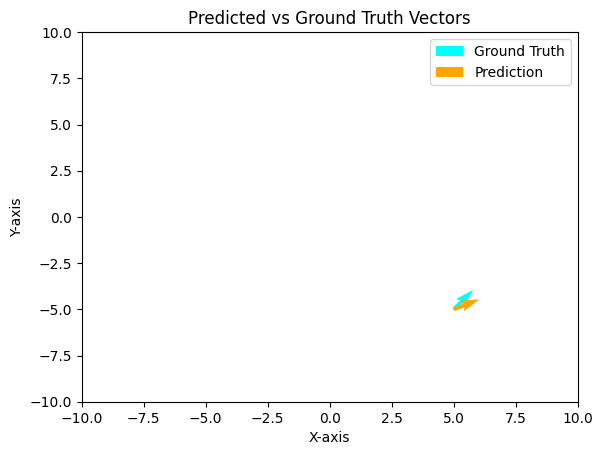

In [8]:
"""import the model saved previously gaze_net.pth"""
# import the model saved previously gaze_net.pth

import torch
import torch.nn as nn

class CompactCNN(nn.Module):
    def __init__(self):
        super(CompactCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, stride=4)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5, stride=4)
        self.fc = nn.Linear(in_features=4*12*112, out_features=2)

    def forward(self, x):
        # Checking the input dimensions
        assert x.size()[2:] == (201, 1800), "Input dimensions must be 1x201x1800"
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = x.view(-1, 4*12*112)
        x = self.fc(x)
        return x

PATH = './.gaze_net.pth'
net = CompactCNN()
net.load_state_dict(torch.load(PATH))

# define the test dataset
test_dataset = GazeDataset(
    csv_file="data_gym/processed_label.csv",
    root_dir="data_gym/training",
    transform=transform
)

# choose only the first 360 images

# define the test data loader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# plot the results
    
def plot_results(net, dataloader, csv_file):
    net.eval()
    

    annotations = pd.read_csv(csv_file)

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # record how much time needed for each image
            start_time = time.time()

            inputs, labels = data
            outputs = net(inputs)

            # record how much time needed for each image
            end_time = time.time()
            print(f'Time needed for each image: {end_time-start_time} seconds')

            # Get the corresponding row from the CSV file
            row = annotations.iloc[i]
            pos_x, pos_y = row[' pos_x'], row[' pos_y']

            # Ground truth and prediction vectors
            gt_vector = labels.numpy()[0]
            pred_vector = outputs.numpy()[0]

            # print gt, pred and pos
            print(f'Ground truth: {gt_vector}')
            print(f'Prediction: {pred_vector}')
            print(f'Position: ({pos_x}, {pos_y})')

            fig, ax = plt.subplots()
            ax.set_xlim(-10, 10)
            ax.set_ylim(-10, 10)

            # Plotting
            ax.quiver(pos_x, pos_y, gt_vector[0], -gt_vector[1], color='cyan')
            ax.quiver(pos_x, pos_y, pred_vector[0], -pred_vector[1], angles='xy', scale_units='xy', color='orange')

            if i==359:
                break

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Predicted vs Ground Truth Vectors')
    plt.legend(['Ground Truth', 'Prediction'])
    plt.show()


plot_results(net, test_dataloader, "data_gym/processed_label.csv")

